## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md


### Generally
- Never trust the data blindly

## Setup

### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, Callback, History
from keras.applications.inception_v3  import InceptionV3

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11401468844628704544
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2848473088
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13502729934657619456
physical_device_desc: "device: 0, name: GeForce GTX 780M, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


### Constants

In [31]:
TRAIN_DATA = '../data/training.csv'
TEST_DATA = '../data/test.csv'
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)
RETRAIN = False
NUM_KEYPOINTS = 30
IDX_BAD_IMAGES = np.array( [1621, 1862, 1748, 1878, 1927, 2200, 2431, 2584, 2647, 
                            2671, 2765, 4198, 1627, 1628, 1637, 1957, 4477, 1820, 
                            2064, 2089, 2091, 2109, 2195, 4264, 4491, 6490, 6493, 
                            6494, 1655, 2096, 2454, 3206, 3287, 5628, 5653, 6754, 
                            6755, 2321, 2322, 2414, 2428, 2462, 2574, 2584, 2663, 
                            2691, 2694, 2830, 2910, 2916, 3126, 3176, 3291, 3299, 
                            3361, 4061, 4483, 4484, 4494, 4766, 4809, 4837, 4880, 
                            4905, 5068, 5362, 5566, 5868, 6535, 6538, 6588, 6605, 
                            6659, 6724, 6733, 6753, 6758, 6766, 6907 ] )

### Load the Data

In [18]:
def loaderV2(test=False, seed=None, keeplabels=None):
    
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    X = np.vstack(df['Image'])
    if not test:
        Y = df[df.columns.difference(['Image'])].values
        Y = Y.astype(np.float32)
    else:
        Y = None
        
    # remove rows having bad images or labels
    X = np.delete( X, (IDX_BAD_IMAGES - 1), axis=0 )
    Y = np.delete( Y, (IDX_BAD_IMAGES - 1), axis=0 )
    
    # normalize - by pixel across the whole dataset subtract mean and divide by stdev
    X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
    X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
    X = X.astype(np.float32)
    
    if not test:
        Y = (Y - 48) / 48                     # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, Y = X[shuffle], Y[shuffle]
    else:
        y = None
    
    X = X.reshape(-1, 96, 96, 1)
    
    # split X and Y into dataset for model1 (more than 8 keypoints) and model2 (less than 8 keypoints)
    X_model1 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
    X_model2 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
    Y_model1 = np.zeros( Y.shape, dtype=float)
    Y_model2 = np.zeros( Y.shape, dtype=float)
    tempIdx1 = 0
    tempIdx2 = 0
    
    for thisIdx in range(0, Y.shape[0]):
        numKeyps  = NUM_KEYPOINTS - np.isnan(Y[thisIdx]).sum()
        
        if( ( numKeyps > 8 ) ):
            X_model1[tempIdx1] = X[thisIdx,:,:]
            Y_model1[tempIdx1] = Y[thisIdx,:]
            tempIdx1 = tempIdx1 + 1
        else:
            X_model2[tempIdx2] = X[thisIdx,:,:]
            Y_model2[tempIdx2] = Y[thisIdx,:]
            tempIdx2 = tempIdx2 + 1

    # remove empty rows
    drop_idx1 = []
    drop_idx2 = []
    
    for idx in range(0, X.shape[0]):
        if( (np.all(Y_model1[idx] == 0)) | (np.isnan(Y_model1[idx]).sum() != 0) ):
            drop_idx1.append(idx)
        if( (np.all(Y_model2[idx] == 0)) | (np.isnan(Y_model2[idx]).sum() != 22) ):
            drop_idx2.append(idx)
    
    X_model1 = np.delete( X_model1, np.array(drop_idx1), axis=0 )
    Y_model1 = np.delete( Y_model1, np.array(drop_idx1), axis=0 )
    X_model2 = np.delete( X_model2, np.array(drop_idx2), axis=0 )
    Y_model2 = np.delete( Y_model2, np.array(drop_idx2), axis=0 )            
    
    # remove empty columns, setup lists of labels
    labels = df.columns.difference(['Image'])
    labels1 = labels
    labels2 = []
    drop_idx3 = []
    for idx in range(0, Y.shape[1]):
        if( (np.all(Y_model2[:,idx] == 0)) | (np.isnan(Y_model2[:,idx]).sum() != 0) ):
            drop_idx3.append(idx)
        else:
            labels2.append(labels[idx])
    Y_model2 = np.delete( Y_model2, np.array(drop_idx3), axis=1 ) 
    
    # return the original dataset and the group splits
    return X_model1, Y_model1, labels1, X_model2, Y_model2, labels2, X, Y, labels


In [19]:
X1, Y1, labels1,   X2, Y2, labels2,   X, Y, labels = loaderV2(seed=42)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1,
                                                        test_size=0.2,
                                                        random_state=42)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2,
                                                        test_size=0.2,
                                                        random_state=42)

data1 = [X1_train, X1_test, Y1_train, Y1_test]
data2 = [X2_train, X2_test, Y2_train, Y2_test]


In [23]:
print("Model1 data Y1 shape: ", Y1.shape, ", X1 shape: ", X1.shape)
print("Model2 data Y2 shape: ", Y2.shape, ", X2 shape: ", X2.shape)


Model1 data Y1 shape:  (2137, 30) , X1 shape:  (2137, 96, 96, 1)
Model2 data Y2 shape:  (4697, 8) , X2 shape:  (4697, 96, 96, 1)


### Plot some sample images

In [21]:
# function to plot an image
def plot_image(image, points, labels=list(labels), title=None):
    """Helper function to plot images"""
    plt.figure(figsize=(4,4))
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    x = 0
    for i, label in enumerate(labels):
        if label[-1]=='x':
            x = points[i]
        else:
            if label in ['left_eye_center_y',
                         'left_eye_inner_corner_y', 
                         'left_eye_outer_corner_y', 
                         'left_eyebrow_inner_end_y', 
                         'left_eyebrow_outer_end_y',
                         'mouth_left_corner_y'
                        ]:
                plt.plot(x, points[i], 'b<')
            elif label in ['right_eye_center_y',
                         'right_eye_inner_corner_y', 
                         'right_eye_outer_corner_y', 
                         'right_eyebrow_inner_end_y', 
                         'right_eyebrow_outer_end_y',
                          'mouth_right_corner_y']:
                plt.plot(x, points[i], 'r>')
            else:
                plt.plot(x, points[i],'m*')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()


In [ ]:
# checking some images from both groups
print("\n Train dataset:")
plot_image(X[1626], 48*Y[1626]+48, labels)
plot_image(X[1627], 48*Y[1627]+48, labels)
plot_image(X[1628], 48*Y[1628]+48, labels)
plot_image(X[1629], 48*Y[1629]+48, labels)

print("\n Model1 dataset:")
plot_image(X1[1626], 48*Y1[1626]+48, labels1)
plot_image(X1[1627], 48*Y1[1627]+48, labels1)
plot_image(X1[1628], 48*Y1[1628]+48, labels1)
plot_image(X1[1629], 48*Y1[1629]+48, labels1)

print("\n Model2 dataset:")
plot_image(X2[0], 48*Y2[0]+48, labels2)
plot_image(X2[1], 48*Y2[1]+48, labels2)
plot_image(X2[2], 48*Y2[2]+48, labels2)
plot_image(X2[3], 48*Y2[3]+48, labels2)


### Model Fitting Function

In [32]:
def fit_model(model, data, modelname,
              generator=None,retrain=RETRAIN,
              epochs=10000, patience=1000):
    if retrain or not os.path.exists('../saved-models/' + modelname + '.h5'):
        X_train = data[0]
        y_train = data[2]
        if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None

        model.compile(loss='mse', optimizer=Nadam())
        
        if valid_dat:
            earlystop = EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     verbose=1,
                                     mode="auto")
            callbacks = [earlystop]
        else:
            callbacks = None
        
        if generator:
            history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=valid_dat
             )
        else:
            history = model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=32,
                                callbacks=callbacks,
                                validation_data=valid_dat
                     )
        model.save('../saved-models/'+ modelname + '.h5')
        with open('../saved-models/histories/'+modelname+'_hist',
                  'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        history = history.history
    else:
        model = load_model('../saved-models/'+modelname+'.h5')
        history = pickle.load(open( "../saved-models/histories/" + modelname + '_hist',
                                   "rb" ))
        
    return history, model

### Helper function to plot the loss

In [25]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r',
        3 : 'o',
        4 : 'p'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist['val_loss']],
                 color=colordict[i],
                 linestyle=':',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

## Models for group1 dataset (images with more than 8 keypoints)
### 1 Dense Hidden Layer with 100 units

In [36]:
g1_model1 = Sequential()
g1_model1.add(Flatten(input_shape=INPUT_SHAPE))
g1_model1.add(Dense(100, activation='relu'))
g1_model1.add(Dense(30))
print(g1_model1.summary())
g1_model1_hist, g1_model1 = fit_model(g1_model1, data1, 'g1_1dense100neuronlayer')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               921700    
_________________________________________________________________
dense_14 (Dense)             (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None
10000
Train on 1709 samples, validate on 428 samples
Epoch 1/10000
1709/1709 [==============================] - 1s 448us/step - loss: 9.0740 - val_loss: 0.9377
Epoch 2/10000
1709/1709 [==============================] - 0s 285us/step - loss: 21.6629 - val_loss: 3.2093
Epoch 3/10000
1709/1709 [==============================] - 0s 292us/step - loss: 1.4428 - val_loss: 1.3366
Epoch 4/10000
1709/1

1709/1709 [==============================] - 0s 273us/step - loss: 0.0435 - val_loss: 0.0854
Epoch 70/10000
1709/1709 [==============================] - 0s 289us/step - loss: 0.0492 - val_loss: 0.0491
Epoch 71/10000
1709/1709 [==============================] - 0s 271us/step - loss: 0.0416 - val_loss: 0.0646
Epoch 72/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0506 - val_loss: 0.0750
Epoch 73/10000
1709/1709 [==============================] - 0s 286us/step - loss: 0.0419 - val_loss: 0.0666
Epoch 74/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0375 - val_loss: 0.0547
Epoch 75/10000
1709/1709 [==============================] - 0s 272us/step - loss: 102.9080 - val_loss: 29.8408
Epoch 76/10000
1709/1709 [==============================] - 0s 269us/step - loss: 6.4214 - val_loss: 1.8584
Epoch 77/10000
1709/1709 [==============================] - 0s 278us/step - loss: 1.0391 - val_loss: 0.8941
Epoch 78/10000
1709/1709 [==============

1709/1709 [==============================] - 0s 278us/step - loss: 0.0360 - val_loss: 0.1031
Epoch 145/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0425 - val_loss: 0.1118
Epoch 146/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0431 - val_loss: 0.1769
Epoch 147/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0577 - val_loss: 0.1299
Epoch 148/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0704 - val_loss: 0.1117
Epoch 149/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0547 - val_loss: 0.1234
Epoch 150/10000
1709/1709 [==============================] - 0s 274us/step - loss: 0.0654 - val_loss: 0.1456
Epoch 151/10000
1709/1709 [==============================] - 0s 268us/step - loss: 0.1039 - val_loss: 0.1439
Epoch 152/10000
1709/1709 [==============================] - 0s 274us/step - loss: 0.0954 - val_loss: 0.1579
Epoch 153/10000
1709/1709 [========

1709/1709 [==============================] - 1s 300us/step - loss: 0.0083 - val_loss: 0.0214
Epoch 220/10000
1709/1709 [==============================] - 1s 299us/step - loss: 0.0080 - val_loss: 0.0207
Epoch 221/10000
1709/1709 [==============================] - 1s 313us/step - loss: 0.0079 - val_loss: 0.0219
Epoch 222/10000
1709/1709 [==============================] - 1s 354us/step - loss: 0.0078 - val_loss: 0.0228
Epoch 223/10000
1709/1709 [==============================] - 1s 351us/step - loss: 0.0073 - val_loss: 0.0225
Epoch 224/10000
1709/1709 [==============================] - 1s 391us/step - loss: 0.0062 - val_loss: 0.0190
Epoch 225/10000
1709/1709 [==============================] - 1s 466us/step - loss: 0.0056 - val_loss: 0.0176
Epoch 226/10000
1709/1709 [==============================] - 1s 403us/step - loss: 0.0055 - val_loss: 0.0236
Epoch 227/10000
1709/1709 [==============================] - 1s 607us/step - loss: 0.0082 - val_loss: 0.0208
Epoch 228/10000
1709/1709 [========

1709/1709 [==============================] - 1s 313us/step - loss: 0.0199 - val_loss: 0.0368
Epoch 295/10000
1709/1709 [==============================] - 1s 316us/step - loss: 0.0174 - val_loss: 0.0345
Epoch 296/10000
1709/1709 [==============================] - 1s 365us/step - loss: 0.0158 - val_loss: 0.0325
Epoch 297/10000
1709/1709 [==============================] - 0s 290us/step - loss: 0.0144 - val_loss: 0.0300
Epoch 298/10000
1709/1709 [==============================] - 0s 291us/step - loss: 0.0128 - val_loss: 0.0287
Epoch 299/10000
1709/1709 [==============================] - 1s 323us/step - loss: 0.0118 - val_loss: 0.0272
Epoch 300/10000
1709/1709 [==============================] - ETA: 0s - loss: 0.010 - 1s 317us/step - loss: 0.0108 - val_loss: 0.0260
Epoch 301/10000
1709/1709 [==============================] - 1s 323us/step - loss: 0.0105 - val_loss: 0.0260
Epoch 302/10000
1709/1709 [==============================] - 1s 325us/step - loss: 0.0094 - val_loss: 0.0246
Epoch 303/1

1709/1709 [==============================] - 1s 337us/step - loss: 0.0027 - val_loss: 0.0054
Epoch 370/10000
1709/1709 [==============================] - 1s 316us/step - loss: 0.0031 - val_loss: 0.0075
Epoch 371/10000
1709/1709 [==============================] - 0s 277us/step - loss: 0.0031 - val_loss: 0.0058
Epoch 372/10000
1709/1709 [==============================] - 1s 319us/step - loss: 0.0031 - val_loss: 0.0260
Epoch 373/10000
1709/1709 [==============================] - 0s 289us/step - loss: 0.0084 - val_loss: 0.0056
Epoch 374/10000
1709/1709 [==============================] - 1s 322us/step - loss: 0.0033 - val_loss: 0.0076
Epoch 375/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0106 - val_loss: 0.0057
Epoch 376/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0035 - val_loss: 0.0054
Epoch 377/10000
1709/1709 [==============================] - 1s 302us/step - loss: 0.0029 - val_loss: 0.0068
Epoch 378/10000
1709/1709 [========

1709/1709 [==============================] - 0s 279us/step - loss: 0.0016 - val_loss: 0.0050
Epoch 445/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0019 - val_loss: 0.0035
Epoch 446/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0017 - val_loss: 0.0041
Epoch 447/10000
1709/1709 [==============================] - 0s 277us/step - loss: 0.0016 - val_loss: 0.0060
Epoch 448/10000
1709/1709 [==============================] - 0s 291us/step - loss: 0.0023 - val_loss: 0.0038
Epoch 449/10000
1709/1709 [==============================] - 1s 303us/step - loss: 0.0015 - val_loss: 0.0037
Epoch 450/10000
1709/1709 [==============================] - 1s 295us/step - loss: 0.0014 - val_loss: 0.0033
Epoch 451/10000
1709/1709 [==============================] - 1s 299us/step - loss: 0.0013 - val_loss: 0.0032
Epoch 452/10000
1709/1709 [==============================] - 0s 284us/step - loss: 0.0013 - val_loss: 0.0039
Epoch 453/10000
1709/1709 [========

1709/1709 [==============================] - 1s 323us/step - loss: 0.0064 - val_loss: 0.0104
Epoch 520/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0056 - val_loss: 0.0106
Epoch 521/10000
1709/1709 [==============================] - 0s 289us/step - loss: 0.0053 - val_loss: 0.0117
Epoch 522/10000
1709/1709 [==============================] - 1s 298us/step - loss: 0.0051 - val_loss: 0.0086
Epoch 523/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0052 - val_loss: 0.0089
Epoch 524/10000
1709/1709 [==============================] - 1s 301us/step - loss: 0.0051 - val_loss: 0.0095
Epoch 525/10000
1709/1709 [==============================] - 0s 291us/step - loss: 0.0048 - val_loss: 0.0083
Epoch 526/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0044 - val_loss: 0.0085
Epoch 527/10000
1709/1709 [==============================] - 1s 317us/step - loss: 0.0041 - val_loss: 0.0086
Epoch 528/10000
1709/1709 [========

1709/1709 [==============================] - 0s 282us/step - loss: 0.0050 - val_loss: 0.0131
Epoch 595/10000
1709/1709 [==============================] - 0s 265us/step - loss: 0.0056 - val_loss: 0.0073
Epoch 596/10000
1709/1709 [==============================] - 0s 286us/step - loss: 0.0033 - val_loss: 0.0074
Epoch 597/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0033 - val_loss: 0.0043
Epoch 598/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0035 - val_loss: 0.0059
Epoch 599/10000
1709/1709 [==============================] - 0s 266us/step - loss: 0.0042 - val_loss: 0.0047
Epoch 600/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0042 - val_loss: 0.0229
Epoch 601/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0085 - val_loss: 0.0058
Epoch 602/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0041 - val_loss: 0.0047
Epoch 603/10000
1709/1709 [========

1709/1709 [==============================] - 0s 273us/step - loss: 0.0013 - val_loss: 0.0037
Epoch 670/10000
1709/1709 [==============================] - 0s 283us/step - loss: 0.0013 - val_loss: 0.0038
Epoch 671/10000
1709/1709 [==============================] - 0s 268us/step - loss: 0.0014 - val_loss: 0.0052
Epoch 672/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0018 - val_loss: 0.0046
Epoch 673/10000
1709/1709 [==============================] - 0s 268us/step - loss: 0.0026 - val_loss: 0.0064
Epoch 674/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0017 - val_loss: 0.0038
Epoch 675/10000
1709/1709 [==============================] - 0s 285us/step - loss: 0.0015 - val_loss: 0.0037
Epoch 676/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0013 - val_loss: 0.0097
Epoch 677/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0017 - val_loss: 0.0040
Epoch 678/10000
1709/1709 [========

1709/1709 [==============================] - 0s 266us/step - loss: 0.0112 - val_loss: 0.0200
Epoch 744/10000
1709/1709 [==============================] - 0s 283us/step - loss: 0.0102 - val_loss: 0.0209
Epoch 745/10000
1709/1709 [==============================] - 0s 271us/step - loss: 0.0095 - val_loss: 0.0196
Epoch 746/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0087 - val_loss: 0.0174
Epoch 747/10000
1709/1709 [==============================] - 0s 267us/step - loss: 0.0081 - val_loss: 0.0176
Epoch 748/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0077 - val_loss: 0.0173
Epoch 749/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0074 - val_loss: 0.0168
Epoch 750/10000
1709/1709 [==============================] - 0s 267us/step - loss: 0.0070 - val_loss: 0.0152
Epoch 751/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0067 - val_loss: 0.0193
Epoch 752/10000
1709/1709 [========

1709/1709 [==============================] - 0s 268us/step - loss: 0.0049 - val_loss: 0.0056
Epoch 819/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0060 - val_loss: 0.0076
Epoch 820/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0045 - val_loss: 0.0065
Epoch 821/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0116 - val_loss: 0.0125
Epoch 822/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0065 - val_loss: 0.0055
Epoch 823/10000
1709/1709 [==============================] - 0s 282us/step - loss: 0.0049 - val_loss: 0.0057
Epoch 824/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0038 - val_loss: 0.0523
Epoch 825/10000
1709/1709 [==============================] - 0s 266us/step - loss: 0.0065 - val_loss: 0.0054
Epoch 826/10000
1709/1709 [==============================] - 0s 290us/step - loss: 0.0041 - val_loss: 0.0070
Epoch 827/10000
1709/1709 [========

1709/1709 [==============================] - 0s 274us/step - loss: 0.0015 - val_loss: 0.0038
Epoch 894/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0015 - val_loss: 0.0035
Epoch 895/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0014 - val_loss: 0.0043
Epoch 896/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0014 - val_loss: 0.0041
Epoch 897/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0014 - val_loss: 0.0037
Epoch 898/10000
1709/1709 [==============================] - 0s 281us/step - loss: 0.0014 - val_loss: 0.0037
Epoch 899/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0014 - val_loss: 0.0038
Epoch 900/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0014 - val_loss: 0.0080
Epoch 901/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0017 - val_loss: 0.0089
Epoch 902/10000
1709/1709 [========

Epoch 968/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0010 - val_loss: 0.0044
Epoch 969/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0011 - val_loss: 0.0042
Epoch 970/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0011 - val_loss: 0.0050
Epoch 971/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0011 - val_loss: 0.0049
Epoch 972/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0011 - val_loss: 0.0049
Epoch 973/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0010 - val_loss: 0.0060
Epoch 974/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0011 - val_loss: 0.0057
Epoch 975/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0012 - val_loss: 0.0049
Epoch 976/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0014 - val_loss: 0.0057
Epoch 977/10000
170

1709/1709 [==============================] - 0s 268us/step - loss: 0.0060 - val_loss: 0.0069
Epoch 1043/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0041 - val_loss: 0.0250
Epoch 1044/10000
1709/1709 [==============================] - 0s 270us/step - loss: 0.0133 - val_loss: 0.0052
Epoch 1045/10000
1709/1709 [==============================] - 0s 290us/step - loss: 0.0036 - val_loss: 0.0056
Epoch 1046/10000
1709/1709 [==============================] - 0s 283us/step - loss: 0.0154 - val_loss: 0.0084
Epoch 1047/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0056 - val_loss: 0.0047
Epoch 1048/10000
1709/1709 [==============================] - 0s 264us/step - loss: 0.0046 - val_loss: 0.0044
Epoch 1049/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0037 - val_loss: 0.0046
Epoch 1050/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0034 - val_loss: 0.0059
Epoch 1051/10000
1709/1709 

1709/1709 [==============================] - 0s 271us/step - loss: 0.0026 - val_loss: 0.0056
Epoch 1117/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0028 - val_loss: 0.0052
Epoch 1118/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0025 - val_loss: 0.0120
Epoch 1119/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 1120/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0033 - val_loss: 0.0045
Epoch 1121/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0033 - val_loss: 0.0049
Epoch 1122/10000
1709/1709 [==============================] - 0s 277us/step - loss: 0.0025 - val_loss: 0.0058
Epoch 1123/10000
1709/1709 [==============================] - 0s 288us/step - loss: 0.0027 - val_loss: 0.0039
Epoch 1124/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0019 - val_loss: 0.0037
Epoch 1125/10000
1709/1709 

1709/1709 [==============================] - 0s 279us/step - loss: 0.0011 - val_loss: 0.0043
Epoch 1191/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0010 - val_loss: 0.0046
Epoch 1192/10000
1709/1709 [==============================] - 0s 269us/step - loss: 0.0011 - val_loss: 0.0041
Epoch 1193/10000
1709/1709 [==============================] - 0s 271us/step - loss: 9.8112e-04 - val_loss: 0.0045
Epoch 1194/10000
1709/1709 [==============================] - 0s 262us/step - loss: 9.7015e-04 - val_loss: 0.0040
Epoch 1195/10000
1709/1709 [==============================] - 0s 280us/step - loss: 9.3093e-04 - val_loss: 0.0040
Epoch 1196/10000
1709/1709 [==============================] - 0s 275us/step - loss: 9.2976e-04 - val_loss: 0.0041
Epoch 1197/10000
1709/1709 [==============================] - 0s 277us/step - loss: 9.4023e-04 - val_loss: 0.0049
Epoch 1198/10000
1709/1709 [==============================] - 0s 276us/step - loss: 9.4378e-04 - val_loss: 0.0042
Epo

1709/1709 [==============================] - 1s 296us/step - loss: 0.0062 - val_loss: 0.0278
Epoch 1265/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0059 - val_loss: 0.0263
Epoch 1266/10000
1709/1709 [==============================] - 0s 290us/step - loss: 0.0056 - val_loss: 0.0309
Epoch 1267/10000
1709/1709 [==============================] - 0s 277us/step - loss: 0.0053 - val_loss: 0.0259
Epoch 1268/10000
1709/1709 [==============================] - 0s 286us/step - loss: 0.0054 - val_loss: 0.0264
Epoch 1269/10000
1709/1709 [==============================] - 0s 279us/step - loss: 0.0051 - val_loss: 0.0273
Epoch 1270/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0051 - val_loss: 0.0254
Epoch 1271/10000
1709/1709 [==============================] - 0s 287us/step - loss: 0.0052 - val_loss: 0.0354
Epoch 1272/10000
1709/1709 [==============================] - 0s 284us/step - loss: 0.0051 - val_loss: 0.0258
Epoch 1273/10000
1709/1709 

1709/1709 [==============================] - 0s 283us/step - loss: 0.0024 - val_loss: 0.0067
Epoch 1339/10000
1709/1709 [==============================] - 0s 275us/step - loss: 0.0030 - val_loss: 0.0088
Epoch 1340/10000
1709/1709 [==============================] - 0s 272us/step - loss: 0.0026 - val_loss: 0.0062
Epoch 1341/10000
1709/1709 [==============================] - 0s 271us/step - loss: 0.0027 - val_loss: 0.0062
Epoch 1342/10000
1709/1709 [==============================] - 0s 268us/step - loss: 0.0031 - val_loss: 0.0071
Epoch 1343/10000
1709/1709 [==============================] - 0s 265us/step - loss: 0.0027 - val_loss: 0.0060
Epoch 1344/10000
1709/1709 [==============================] - 0s 274us/step - loss: 0.0028 - val_loss: 0.0059
Epoch 1345/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0026 - val_loss: 0.0057
Epoch 1346/10000
1709/1709 [==============================] - 0s 273us/step - loss: 0.0024 - val_loss: 0.0068
Epoch 1347/10000
1709/1709 

1709/1709 [==============================] - 0s 283us/step - loss: 0.0012 - val_loss: 0.0046
Epoch 1413/10000
1709/1709 [==============================] - 0s 291us/step - loss: 0.0014 - val_loss: 0.0049
Epoch 1414/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0013 - val_loss: 0.0039
Epoch 1415/10000
1709/1709 [==============================] - 0s 283us/step - loss: 0.0012 - val_loss: 0.0039
Epoch 1416/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0011 - val_loss: 0.0040
Epoch 1417/10000
1709/1709 [==============================] - 0s 278us/step - loss: 0.0012 - val_loss: 0.0040
Epoch 1418/10000
1709/1709 [==============================] - 0s 276us/step - loss: 0.0013 - val_loss: 0.0046
Epoch 1419/10000
1709/1709 [==============================] - 0s 285us/step - loss: 0.0011 - val_loss: 0.0042
Epoch 1420/10000
1709/1709 [==============================] - 0s 280us/step - loss: 0.0011 - val_loss: 0.0077
Epoch 1421/10000
1709/1709 

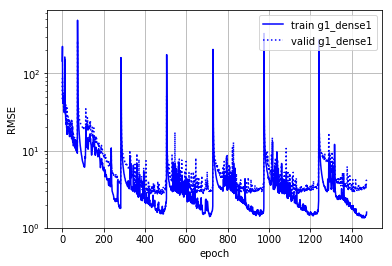

In [37]:
plot_loss([g1_model1_hist],['g1_dense1'])

In [38]:
g1_model1BN = Sequential()
g1_model1BN.add(Flatten(input_shape=INPUT_SHAPE))
g1_model1BN.add(Dense(100, activation='relu'))
g1_model1BN.add(BatchNormalization())
g1_model1BN.add(Dense(30))
print(g1_model1BN.summary())
g1_model1BN_hist, g1_model1BN = fit_model(g1_model1BN, data1,
                                    'g1_1dense100neuronlayer_wbatchnormalization')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               921700    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_16 (Dense)             (None, 30)                3030      
Total params: 925,130
Trainable params: 924,930
Non-trainable params: 200
_________________________________________________________________
None
10000
Train on 1709 samples, validate on 428 samples
Epoch 1/10000
1709/1709 [==============================] - 1s 627us/step - loss: 0.2881 - val_loss: 0.0576
Epoch 2/10000
1709/1709 [==============================] - 1s 323us/step - loss: 0.0197 - val_loss: 0

1709/1709 [==============================] - 1s 321us/step - loss: 0.0016 - val_loss: 0.0050
Epoch 69/10000
1709/1709 [==============================] - 1s 339us/step - loss: 0.0020 - val_loss: 0.0049
Epoch 70/10000
1709/1709 [==============================] - 1s 320us/step - loss: 0.0019 - val_loss: 0.0059
Epoch 71/10000
1709/1709 [==============================] - 1s 329us/step - loss: 0.0018 - val_loss: 0.0093
Epoch 72/10000
1709/1709 [==============================] - 1s 333us/step - loss: 0.0020 - val_loss: 0.0037
Epoch 73/10000
1709/1709 [==============================] - 1s 337us/step - loss: 0.0016 - val_loss: 0.0047
Epoch 74/10000
1709/1709 [==============================] - 1s 330us/step - loss: 0.0018 - val_loss: 0.0043
Epoch 75/10000
1709/1709 [==============================] - 1s 331us/step - loss: 0.0016 - val_loss: 0.0051
Epoch 76/10000
1709/1709 [==============================] - 1s 320us/step - loss: 0.0021 - val_loss: 0.0038
Epoch 77/10000
1709/1709 [=================

1709/1709 [==============================] - 1s 320us/step - loss: 0.0012 - val_loss: 0.0039
Epoch 144/10000
1709/1709 [==============================] - 1s 316us/step - loss: 0.0012 - val_loss: 0.0031
Epoch 145/10000
1709/1709 [==============================] - 1s 315us/step - loss: 0.0010 - val_loss: 0.0028
Epoch 146/10000
1709/1709 [==============================] - 1s 325us/step - loss: 0.0013 - val_loss: 0.0033
Epoch 147/10000
1709/1709 [==============================] - 1s 316us/step - loss: 0.0010 - val_loss: 0.0045
Epoch 148/10000
1709/1709 [==============================] - 1s 321us/step - loss: 0.0012 - val_loss: 0.0028
Epoch 149/10000
1709/1709 [==============================] - 1s 319us/step - loss: 0.0010 - val_loss: 0.0032
Epoch 150/10000
1709/1709 [==============================] - 1s 328us/step - loss: 0.0012 - val_loss: 0.0037
Epoch 151/10000
1709/1709 [==============================] - 1s 331us/step - loss: 0.0013 - val_loss: 0.0040
Epoch 152/10000
1709/1709 [========

1709/1709 [==============================] - 1s 323us/step - loss: 8.9580e-04 - val_loss: 0.0025
Epoch 218/10000
1709/1709 [==============================] - 1s 323us/step - loss: 9.4131e-04 - val_loss: 0.0034
Epoch 219/10000
1709/1709 [==============================] - 1s 313us/step - loss: 9.8445e-04 - val_loss: 0.0032
Epoch 220/10000
1709/1709 [==============================] - 1s 318us/step - loss: 9.8741e-04 - val_loss: 0.0032
Epoch 221/10000
1709/1709 [==============================] - 1s 314us/step - loss: 8.7984e-04 - val_loss: 0.0026
Epoch 222/10000
1709/1709 [==============================] - 1s 320us/step - loss: 8.7905e-04 - val_loss: 0.0032
Epoch 223/10000
1709/1709 [==============================] - 1s 319us/step - loss: 9.4438e-04 - val_loss: 0.0028
Epoch 224/10000
1709/1709 [==============================] - 1s 317us/step - loss: 8.7378e-04 - val_loss: 0.0031
Epoch 225/10000
1709/1709 [==============================] - 1s 320us/step - loss: 8.3458e-04 - val_loss: 0.0028

1709/1709 [==============================] - 1s 319us/step - loss: 7.5033e-04 - val_loss: 0.0027
Epoch 290/10000
1709/1709 [==============================] - 1s 319us/step - loss: 7.3597e-04 - val_loss: 0.0026
Epoch 291/10000
1709/1709 [==============================] - 1s 329us/step - loss: 7.0543e-04 - val_loss: 0.0025
Epoch 292/10000
1709/1709 [==============================] - 1s 324us/step - loss: 6.7796e-04 - val_loss: 0.0024
Epoch 293/10000
1709/1709 [==============================] - 1s 328us/step - loss: 6.8308e-04 - val_loss: 0.0026
Epoch 294/10000
1709/1709 [==============================] - 1s 322us/step - loss: 7.0669e-04 - val_loss: 0.0026
Epoch 295/10000
1709/1709 [==============================] - 1s 320us/step - loss: 7.0688e-04 - val_loss: 0.0027
Epoch 296/10000
1709/1709 [==============================] - 1s 334us/step - loss: 7.2111e-04 - val_loss: 0.0026
Epoch 297/10000
1709/1709 [==============================] - 1s 330us/step - loss: 6.6778e-04 - val_loss: 0.0025

1709/1709 [==============================] - 1s 314us/step - loss: 6.8784e-04 - val_loss: 0.0032
Epoch 362/10000
1709/1709 [==============================] - 1s 319us/step - loss: 7.9114e-04 - val_loss: 0.0026
Epoch 363/10000
1709/1709 [==============================] - 1s 317us/step - loss: 6.4953e-04 - val_loss: 0.0025
Epoch 364/10000
1709/1709 [==============================] - 1s 317us/step - loss: 6.4149e-04 - val_loss: 0.0026
Epoch 365/10000
1709/1709 [==============================] - 1s 314us/step - loss: 7.1246e-04 - val_loss: 0.0027
Epoch 366/10000
1709/1709 [==============================] - 1s 319us/step - loss: 5.9852e-04 - val_loss: 0.0027
Epoch 367/10000
1709/1709 [==============================] - 1s 329us/step - loss: 6.3301e-04 - val_loss: 0.0024
Epoch 368/10000
1709/1709 [==============================] - 1s 317us/step - loss: 6.0794e-04 - val_loss: 0.0026
Epoch 369/10000
1709/1709 [==============================] - 1s 314us/step - loss: 6.7401e-04 - val_loss: 0.0025

1709/1709 [==============================] - 1s 315us/step - loss: 5.1762e-04 - val_loss: 0.0024
Epoch 434/10000
1709/1709 [==============================] - 1s 316us/step - loss: 5.0447e-04 - val_loss: 0.0025
Epoch 435/10000
1709/1709 [==============================] - 1s 321us/step - loss: 5.3531e-04 - val_loss: 0.0024
Epoch 436/10000
1709/1709 [==============================] - 1s 314us/step - loss: 4.9232e-04 - val_loss: 0.0027
Epoch 437/10000
1709/1709 [==============================] - 1s 326us/step - loss: 5.2673e-04 - val_loss: 0.0024
Epoch 438/10000
1709/1709 [==============================] - 1s 321us/step - loss: 5.1138e-04 - val_loss: 0.0025
Epoch 439/10000
1709/1709 [==============================] - 1s 321us/step - loss: 5.3110e-04 - val_loss: 0.0024
Epoch 440/10000
1709/1709 [==============================] - 1s 313us/step - loss: 5.1423e-04 - val_loss: 0.0025
Epoch 441/10000
1709/1709 [==============================] - 1s 310us/step - loss: 4.9275e-04 - val_loss: 0.0024

1709/1709 [==============================] - 1s 321us/step - loss: 4.5735e-04 - val_loss: 0.0024
Epoch 506/10000
1709/1709 [==============================] - 1s 318us/step - loss: 4.4621e-04 - val_loss: 0.0025
Epoch 507/10000
1709/1709 [==============================] - 1s 315us/step - loss: 4.2454e-04 - val_loss: 0.0023
Epoch 508/10000
1709/1709 [==============================] - 1s 317us/step - loss: 4.5124e-04 - val_loss: 0.0024
Epoch 509/10000
1709/1709 [==============================] - 1s 311us/step - loss: 4.0700e-04 - val_loss: 0.0024
Epoch 510/10000
1709/1709 [==============================] - 1s 319us/step - loss: 4.5299e-04 - val_loss: 0.0025
Epoch 511/10000
1709/1709 [==============================] - 1s 316us/step - loss: 4.6732e-04 - val_loss: 0.0024
Epoch 512/10000
1709/1709 [==============================] - 1s 317us/step - loss: 4.5860e-04 - val_loss: 0.0024
Epoch 513/10000
1709/1709 [==============================] - 1s 314us/step - loss: 4.4662e-04 - val_loss: 0.0024

1709/1709 [==============================] - 1s 326us/step - loss: 3.9983e-04 - val_loss: 0.0023
Epoch 578/10000
1709/1709 [==============================] - 1s 318us/step - loss: 3.8767e-04 - val_loss: 0.0026
Epoch 579/10000
1709/1709 [==============================] - 1s 330us/step - loss: 3.9444e-04 - val_loss: 0.0023
Epoch 580/10000
1709/1709 [==============================] - 1s 319us/step - loss: 3.6634e-04 - val_loss: 0.0023
Epoch 581/10000
1709/1709 [==============================] - 1s 321us/step - loss: 4.0308e-04 - val_loss: 0.0024
Epoch 582/10000
1709/1709 [==============================] - 1s 316us/step - loss: 3.6901e-04 - val_loss: 0.0023
Epoch 583/10000
1709/1709 [==============================] - 1s 314us/step - loss: 3.5353e-04 - val_loss: 0.0023
Epoch 584/10000
1709/1709 [==============================] - 1s 311us/step - loss: 3.9030e-04 - val_loss: 0.0024
Epoch 585/10000
1709/1709 [==============================] - 1s 322us/step - loss: 3.9691e-04 - val_loss: 0.0024

1709/1709 [==============================] - 1s 325us/step - loss: 3.3187e-04 - val_loss: 0.0023
Epoch 650/10000
1709/1709 [==============================] - 1s 320us/step - loss: 3.5102e-04 - val_loss: 0.0023
Epoch 651/10000
1709/1709 [==============================] - 1s 329us/step - loss: 3.6303e-04 - val_loss: 0.0023
Epoch 652/10000
1709/1709 [==============================] - 1s 317us/step - loss: 3.5258e-04 - val_loss: 0.0023
Epoch 653/10000
1709/1709 [==============================] - 1s 319us/step - loss: 3.3363e-04 - val_loss: 0.0023
Epoch 654/10000
1709/1709 [==============================] - 1s 324us/step - loss: 3.6359e-04 - val_loss: 0.0023
Epoch 655/10000
1709/1709 [==============================] - 1s 313us/step - loss: 3.4958e-04 - val_loss: 0.0023
Epoch 656/10000
1709/1709 [==============================] - 1s 312us/step - loss: 3.2767e-04 - val_loss: 0.0023
Epoch 657/10000
1709/1709 [==============================] - 1s 329us/step - loss: 3.4358e-04 - val_loss: 0.0024

1709/1709 [==============================] - 1s 316us/step - loss: 3.0554e-04 - val_loss: 0.0023
Epoch 722/10000
1709/1709 [==============================] - 1s 313us/step - loss: 3.4155e-04 - val_loss: 0.0022
Epoch 723/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.9020e-04 - val_loss: 0.0023
Epoch 724/10000
1709/1709 [==============================] - 1s 321us/step - loss: 3.1710e-04 - val_loss: 0.0023
Epoch 725/10000
1709/1709 [==============================] - 1s 312us/step - loss: 3.3603e-04 - val_loss: 0.0022
Epoch 726/10000
1709/1709 [==============================] - 1s 312us/step - loss: 3.0572e-04 - val_loss: 0.0023
Epoch 727/10000
1709/1709 [==============================] - 1s 319us/step - loss: 3.1411e-04 - val_loss: 0.0022
Epoch 728/10000
1709/1709 [==============================] - 1s 321us/step - loss: 3.2655e-04 - val_loss: 0.0023
Epoch 729/10000
1709/1709 [==============================] - 1s 304us/step - loss: 3.2780e-04 - val_loss: 0.0022

1709/1709 [==============================] - 1s 332us/step - loss: 2.9904e-04 - val_loss: 0.0023
Epoch 794/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.8319e-04 - val_loss: 0.0023
Epoch 795/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.9756e-04 - val_loss: 0.0022
Epoch 796/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.8286e-04 - val_loss: 0.0022
Epoch 797/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.8824e-04 - val_loss: 0.0022
Epoch 798/10000
1709/1709 [==============================] - 1s 318us/step - loss: 3.0475e-04 - val_loss: 0.0023
Epoch 799/10000
1709/1709 [==============================] - 1s 325us/step - loss: 2.8641e-04 - val_loss: 0.0022
Epoch 800/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.9742e-04 - val_loss: 0.0023
Epoch 801/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.9366e-04 - val_loss: 0.0023

1709/1709 [==============================] - 1s 309us/step - loss: 2.7255e-04 - val_loss: 0.0022
Epoch 866/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.5502e-04 - val_loss: 0.0022
Epoch 867/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.8412e-04 - val_loss: 0.0022
Epoch 868/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.7320e-04 - val_loss: 0.0022
Epoch 869/10000
1709/1709 [==============================] - 1s 328us/step - loss: 2.7178e-04 - val_loss: 0.0022
Epoch 870/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.8112e-04 - val_loss: 0.0023
Epoch 871/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.8028e-04 - val_loss: 0.0022
Epoch 872/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.6965e-04 - val_loss: 0.0023
Epoch 873/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.7608e-04 - val_loss: 0.0023

1709/1709 [==============================] - 1s 320us/step - loss: 2.6355e-04 - val_loss: 0.0023
Epoch 938/10000
1709/1709 [==============================] - 1s 330us/step - loss: 2.8010e-04 - val_loss: 0.0022
Epoch 939/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.5705e-04 - val_loss: 0.0023
Epoch 940/10000
1709/1709 [==============================] - 1s 309us/step - loss: 2.8362e-04 - val_loss: 0.0022
Epoch 941/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.4740e-04 - val_loss: 0.0022
Epoch 942/10000
1709/1709 [==============================] - 1s 311us/step - loss: 2.6262e-04 - val_loss: 0.0022
Epoch 943/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.5715e-04 - val_loss: 0.0022
Epoch 944/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.6745e-04 - val_loss: 0.0023
Epoch 945/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.5083e-04 - val_loss: 0.0022

1709/1709 [==============================] - 1s 327us/step - loss: 2.4795e-04 - val_loss: 0.0022
Epoch 1010/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.5700e-04 - val_loss: 0.0023
Epoch 1011/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.4434e-04 - val_loss: 0.0022
Epoch 1012/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.5582e-04 - val_loss: 0.0022
Epoch 1013/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.3344e-04 - val_loss: 0.0022
Epoch 1014/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.6361e-04 - val_loss: 0.0022
Epoch 1015/10000
1709/1709 [==============================] - 1s 327us/step - loss: 2.3555e-04 - val_loss: 0.0022
Epoch 1016/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.2984e-04 - val_loss: 0.0022
Epoch 1017/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.3111e-04 - val_loss

1709/1709 [==============================] - 1s 321us/step - loss: 2.2414e-04 - val_loss: 0.0022
Epoch 1082/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.3607e-04 - val_loss: 0.0022
Epoch 1083/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.5785e-04 - val_loss: 0.0022
Epoch 1084/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.4123e-04 - val_loss: 0.0022
Epoch 1085/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.4122e-04 - val_loss: 0.0022
Epoch 1086/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.3875e-04 - val_loss: 0.0022
Epoch 1087/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.3471e-04 - val_loss: 0.0022
Epoch 1088/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.4826e-04 - val_loss: 0.0022
Epoch 1089/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.3099e-04 - val_loss

1709/1709 [==============================] - 1s 315us/step - loss: 2.3081e-04 - val_loss: 0.0022
Epoch 1154/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.2517e-04 - val_loss: 0.0022
Epoch 1155/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.4045e-04 - val_loss: 0.0022
Epoch 1156/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.3486e-04 - val_loss: 0.0022
Epoch 1157/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.3569e-04 - val_loss: 0.0022
Epoch 1158/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.2582e-04 - val_loss: 0.0022
Epoch 1159/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.4395e-04 - val_loss: 0.0023
Epoch 1160/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.3752e-04 - val_loss: 0.0022
Epoch 1161/10000
1709/1709 [==============================] - 1s 306us/step - loss: 2.3054e-04 - val_loss

1709/1709 [==============================] - 1s 326us/step - loss: 2.4761e-04 - val_loss: 0.0023
Epoch 1226/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.3397e-04 - val_loss: 0.0022
Epoch 1227/10000
1709/1709 [==============================] - 1s 308us/step - loss: 2.3219e-04 - val_loss: 0.0022
Epoch 1228/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.3877e-04 - val_loss: 0.0022
Epoch 1229/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.2687e-04 - val_loss: 0.0022
Epoch 1230/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.5588e-04 - val_loss: 0.0022
Epoch 1231/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.4539e-04 - val_loss: 0.0022
Epoch 1232/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.2669e-04 - val_loss: 0.0022
Epoch 1233/10000
1709/1709 [==============================] - 1s 311us/step - loss: 2.3727e-04 - val_loss

1709/1709 [==============================] - 1s 317us/step - loss: 2.3838e-04 - val_loss: 0.0022
Epoch 1298/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.3753e-04 - val_loss: 0.0023
Epoch 1299/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.2671e-04 - val_loss: 0.0023
Epoch 1300/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.2277e-04 - val_loss: 0.0022
Epoch 1301/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.3764e-04 - val_loss: 0.0022
Epoch 1302/10000
1709/1709 [==============================] - 1s 329us/step - loss: 2.0734e-04 - val_loss: 0.0022
Epoch 1303/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.4153e-04 - val_loss: 0.0022
Epoch 1304/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.2364e-04 - val_loss: 0.0022
Epoch 1305/10000
1709/1709 [==============================] - 1s 328us/step - loss: 2.3585e-04 - val_loss

1709/1709 [==============================] - 1s 317us/step - loss: 2.2343e-04 - val_loss: 0.0022
Epoch 1370/10000
1709/1709 [==============================] - 1s 309us/step - loss: 2.3727e-04 - val_loss: 0.0022
Epoch 1371/10000
1709/1709 [==============================] - 1s 330us/step - loss: 2.3205e-04 - val_loss: 0.0022
Epoch 1372/10000
1709/1709 [==============================] - 1s 322us/step - loss: 2.2936e-04 - val_loss: 0.0022
Epoch 1373/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.2906e-04 - val_loss: 0.0023
Epoch 1374/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.2338e-04 - val_loss: 0.0022
Epoch 1375/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.3033e-04 - val_loss: 0.0022
Epoch 1376/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.2341e-04 - val_loss: 0.0023
Epoch 1377/10000
1709/1709 [==============================] - 1s 327us/step - loss: 2.3997e-04 - val_loss

1709/1709 [==============================] - 1s 364us/step - loss: 2.1337e-04 - val_loss: 0.0023
Epoch 1442/10000
1709/1709 [==============================] - 2s 1ms/step - loss: 2.3212e-04 - val_loss: 0.0022
Epoch 1443/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.5342e-04 - val_loss: 0.0022
Epoch 1444/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.0377e-04 - val_loss: 0.0022
Epoch 1445/10000
1709/1709 [==============================] - 1s 325us/step - loss: 2.4127e-04 - val_loss: 0.0022
Epoch 1446/10000
1709/1709 [==============================] - 1s 325us/step - loss: 2.1931e-04 - val_loss: 0.0022
Epoch 1447/10000
1709/1709 [==============================] - 1s 324us/step - loss: 2.2832e-04 - val_loss: 0.0022
Epoch 1448/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.1495e-04 - val_loss: 0.0022
Epoch 1449/10000
1709/1709 [==============================] - 1s 321us/step - loss: 2.3157e-04 - val_loss: 

1709/1709 [==============================] - 1s 316us/step - loss: 2.4105e-04 - val_loss: 0.0022
Epoch 1514/10000
1709/1709 [==============================] - 1s 311us/step - loss: 2.0370e-04 - val_loss: 0.0022
Epoch 1515/10000
1709/1709 [==============================] - 1s 306us/step - loss: 2.2729e-04 - val_loss: 0.0022
Epoch 1516/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.4245e-04 - val_loss: 0.0022
Epoch 1517/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1377e-04 - val_loss: 0.0022
Epoch 1518/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.2784e-04 - val_loss: 0.0022
Epoch 1519/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.3148e-04 - val_loss: 0.0023
Epoch 1520/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.2079e-04 - val_loss: 0.0022
Epoch 1521/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.5347e-04 - val_loss

1709/1709 [==============================] - 1s 312us/step - loss: 2.0891e-04 - val_loss: 0.0022
Epoch 1586/10000
1709/1709 [==============================] - 1s 309us/step - loss: 2.2367e-04 - val_loss: 0.0022
Epoch 1587/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.2757e-04 - val_loss: 0.0023
Epoch 1588/10000
1709/1709 [==============================] - 1s 313us/step - loss: 1.9691e-04 - val_loss: 0.0022
Epoch 1589/10000
1709/1709 [==============================] - 1s 307us/step - loss: 2.1770e-04 - val_loss: 0.0023
Epoch 1590/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.2188e-04 - val_loss: 0.0022
Epoch 1591/10000
1709/1709 [==============================] - 1s 318us/step - loss: 2.3251e-04 - val_loss: 0.0022
Epoch 1592/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1633e-04 - val_loss: 0.0022
Epoch 1593/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1092e-04 - val_loss

1709/1709 [==============================] - 1s 309us/step - loss: 2.3965e-04 - val_loss: 0.0022
Epoch 1658/10000
1709/1709 [==============================] - 1s 308us/step - loss: 2.3140e-04 - val_loss: 0.0023
Epoch 1659/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.1851e-04 - val_loss: 0.0022
Epoch 1660/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.2262e-04 - val_loss: 0.0022
Epoch 1661/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.1593e-04 - val_loss: 0.0022
Epoch 1662/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.2212e-04 - val_loss: 0.0022
Epoch 1663/10000
1709/1709 [==============================] - 1s 328us/step - loss: 2.0458e-04 - val_loss: 0.0022
Epoch 1664/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.0876e-04 - val_loss: 0.0022
Epoch 1665/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1246e-04 - val_loss

1709/1709 [==============================] - 1s 314us/step - loss: 2.1769e-04 - val_loss: 0.0022
Epoch 1730/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.4181e-04 - val_loss: 0.0023
Epoch 1731/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.1152e-04 - val_loss: 0.0022
Epoch 1732/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.3085e-04 - val_loss: 0.0023
Epoch 1733/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.1199e-04 - val_loss: 0.0022
Epoch 1734/10000
1709/1709 [==============================] - 1s 310us/step - loss: 2.2894e-04 - val_loss: 0.0022
Epoch 1735/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.0337e-04 - val_loss: 0.0022
Epoch 1736/10000
1709/1709 [==============================] - 1s 311us/step - loss: 1.9301e-04 - val_loss: 0.0022
Epoch 1737/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.1643e-04 - val_loss

1709/1709 [==============================] - 1s 316us/step - loss: 2.2691e-04 - val_loss: 0.0022
Epoch 1802/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.3663e-04 - val_loss: 0.0022
Epoch 1803/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.2207e-04 - val_loss: 0.0022
Epoch 1804/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.0035e-04 - val_loss: 0.0022
Epoch 1805/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.4044e-04 - val_loss: 0.0022
Epoch 1806/10000
1709/1709 [==============================] - 1s 320us/step - loss: 2.0899e-04 - val_loss: 0.0023
Epoch 1807/10000
1709/1709 [==============================] - 1s 315us/step - loss: 1.9215e-04 - val_loss: 0.0022
Epoch 1808/10000
1709/1709 [==============================] - 1s 315us/step - loss: 2.2560e-04 - val_loss: 0.0022
Epoch 1809/10000
1709/1709 [==============================] - 1s 315us/step - loss: 2.2960e-04 - val_loss

1709/1709 [==============================] - 1s 325us/step - loss: 1.9556e-04 - val_loss: 0.0022
Epoch 1874/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.1196e-04 - val_loss: 0.0023
Epoch 1875/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.3848e-04 - val_loss: 0.0022
Epoch 1876/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.2198e-04 - val_loss: 0.0022
Epoch 1877/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.0390e-04 - val_loss: 0.0023
Epoch 1878/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.3005e-04 - val_loss: 0.0022
Epoch 1879/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.1042e-04 - val_loss: 0.0023
Epoch 1880/10000
1709/1709 [==============================] - 1s 307us/step - loss: 2.3090e-04 - val_loss: 0.0022
Epoch 1881/10000
1709/1709 [==============================] - 1s 325us/step - loss: 2.1100e-04 - val_loss

1709/1709 [==============================] - 1s 318us/step - loss: 2.2014e-04 - val_loss: 0.0023
Epoch 1946/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.2759e-04 - val_loss: 0.0023
Epoch 1947/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.2377e-04 - val_loss: 0.0022
Epoch 1948/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.0598e-04 - val_loss: 0.0022
Epoch 1949/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.1398e-04 - val_loss: 0.0022
Epoch 1950/10000
1709/1709 [==============================] - 1s 308us/step - loss: 2.1437e-04 - val_loss: 0.0022
Epoch 1951/10000
1709/1709 [==============================] - 1s 313us/step - loss: 1.9479e-04 - val_loss: 0.0022
Epoch 1952/10000
1709/1709 [==============================] - 1s 317us/step - loss: 2.0924e-04 - val_loss: 0.0023
Epoch 1953/10000
1709/1709 [==============================] - 1s 317us/step - loss: 1.9929e-04 - val_loss

1709/1709 [==============================] - 1s 320us/step - loss: 2.0607e-04 - val_loss: 0.0022
Epoch 2018/10000
1709/1709 [==============================] - 1s 313us/step - loss: 2.0290e-04 - val_loss: 0.0022
Epoch 2019/10000
1709/1709 [==============================] - 1s 395us/step - loss: 1.9063e-04 - val_loss: 0.0022
Epoch 2020/10000
1709/1709 [==============================] - 1s 330us/step - loss: 2.2280e-04 - val_loss: 0.0022
Epoch 2021/10000
1709/1709 [==============================] - 1s 304us/step - loss: 2.3426e-04 - val_loss: 0.0023
Epoch 2022/10000
1709/1709 [==============================] - 1s 315us/step - loss: 2.0963e-04 - val_loss: 0.0023
Epoch 2023/10000
1709/1709 [==============================] - 1s 330us/step - loss: 2.1845e-04 - val_loss: 0.0023
Epoch 2024/10000
1709/1709 [==============================] - 1s 329us/step - loss: 2.1691e-04 - val_loss: 0.0022
Epoch 2025/10000
1709/1709 [==============================] - 1s 311us/step - loss: 2.0142e-04 - val_loss

1709/1709 [==============================] - 1s 313us/step - loss: 2.0990e-04 - val_loss: 0.0022
Epoch 2090/10000
1709/1709 [==============================] - 1s 314us/step - loss: 2.2643e-04 - val_loss: 0.0022
Epoch 2091/10000
1709/1709 [==============================] - 1s 312us/step - loss: 2.0097e-04 - val_loss: 0.0023
Epoch 2092/10000
1709/1709 [==============================] - 1s 327us/step - loss: 2.0728e-04 - val_loss: 0.0022
Epoch 2093/10000
1709/1709 [==============================] - 1s 323us/step - loss: 2.0298e-04 - val_loss: 0.0022
Epoch 2094/10000
1709/1709 [==============================] - 1s 316us/step - loss: 2.2192e-04 - val_loss: 0.0023
Epoch 2095/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.1126e-04 - val_loss: 0.0022
Epoch 2096/10000
1709/1709 [==============================] - 1s 319us/step - loss: 2.3020e-04 - val_loss: 0.0022
Epoch 2097/10000
1709/1709 [==============================] - 1s 322us/step - loss: 2.1858e-04 - val_loss

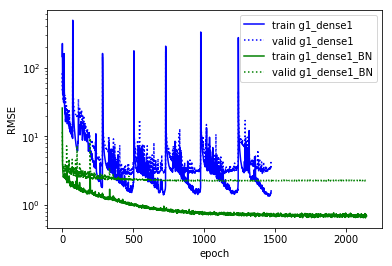

In [39]:
plot_loss([g1_model1_hist, g1_model1BN_hist],['g1_dense1','g1_dense1_BN'])

### Model with convolutions

In [40]:
g1_model2 = Sequential()
g1_model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model2.add(BatchNormalization())
g1_model2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2.add(BatchNormalization())
g1_model2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2.add(BatchNormalization())
g1_model2.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2.add(Flatten())
g1_model2.add(Dense(500, activation = "relu"))
g1_model2.add(BatchNormalization())
g1_model2.add(Dense(100, activation = "relu"))
g1_model2.add(BatchNormalization())
g1_model2.add(Dense(30))
print(g1_model2.summary())

g1_model2_hist, g1_model2 = fit_model(g1_model2, data1,
                                    'g1_CNN')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       32896     
__________

Epoch 56/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 57/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 58/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 59/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 60/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 61/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 62/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 63/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 64/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 65/10000
1709/1709 [====================

Epoch 132/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.6435e-04 - val_loss: 0.0014
Epoch 133/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 6.7296e-04 - val_loss: 0.0014
Epoch 134/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.6571e-04 - val_loss: 0.0023
Epoch 135/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 136/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 8.8952e-04 - val_loss: 0.0015
Epoch 137/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.5554e-04 - val_loss: 0.0015
Epoch 138/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.4052e-04 - val_loss: 0.0024
Epoch 139/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 7.5856e-04 - val_loss: 0.0014
Epoch 140/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 6.8487e-04 - val_loss: 0.0017
Epoch

Epoch 206/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 6.1448e-04 - val_loss: 0.0014
Epoch 207/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.2002e-04 - val_loss: 0.0011
Epoch 208/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.8989e-04 - val_loss: 0.0013
Epoch 209/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.6592e-04 - val_loss: 0.0021
Epoch 210/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.4990e-04 - val_loss: 0.0013
Epoch 211/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.4268e-04 - val_loss: 0.0012
Epoch 212/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.2702e-04 - val_loss: 0.0015
Epoch 213/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.4226e-04 - val_loss: 0.0015
Epoch 214/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 5.9522e-04 - val_loss: 0.0011
E

Epoch 280/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1385e-04 - val_loss: 0.0014
Epoch 281/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 5.0375e-04 - val_loss: 0.0012
Epoch 282/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.4028e-04 - val_loss: 0.0012
Epoch 283/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1389e-04 - val_loss: 0.0012
Epoch 284/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.5242e-04 - val_loss: 0.0013
Epoch 285/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1490e-04 - val_loss: 0.0011
Epoch 286/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.5706e-04 - val_loss: 0.0012
Epoch 287/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1047e-04 - val_loss: 0.0012
Epoch 288/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.4278e-04 - val_loss: 0.0012
E

1709/1709 [==============================] - 4s 3ms/step - loss: 4.2116e-04 - val_loss: 0.0011
Epoch 354/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.8980e-04 - val_loss: 0.0011
Epoch 355/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.1432e-04 - val_loss: 0.0012
Epoch 356/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.0939e-04 - val_loss: 0.0012
Epoch 357/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.8609e-04 - val_loss: 0.0012
Epoch 358/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 4.0359e-04 - val_loss: 0.0011
Epoch 359/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.7942e-04 - val_loss: 0.0015
Epoch 360/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.8706e-04 - val_loss: 0.0014
Epoch 361/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 3.9748e-04 - val_loss: 0.0011
Epoch 362/10000
1

Epoch 427/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.3763e-04 - val_loss: 9.9342e-04
Epoch 428/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.2725e-04 - val_loss: 0.0012
Epoch 429/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.4530e-04 - val_loss: 0.0010
Epoch 430/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.6033e-04 - val_loss: 0.0010
Epoch 431/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.1418e-04 - val_loss: 0.0012
Epoch 432/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.4123e-04 - val_loss: 0.0012
Epoch 433/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.2568e-04 - val_loss: 0.0011
Epoch 434/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.3732e-04 - val_loss: 0.0011
Epoch 435/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.1413e-04 - val_loss: 0.00

1709/1709 [==============================] - 5s 3ms/step - loss: 2.9685e-04 - val_loss: 0.0012
Epoch 501/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.1691e-04 - val_loss: 0.0011
Epoch 502/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.1124e-04 - val_loss: 0.0011
Epoch 503/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9833e-04 - val_loss: 9.8713e-04
Epoch 504/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9694e-04 - val_loss: 9.9150e-04
Epoch 505/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.0270e-04 - val_loss: 0.0012
Epoch 506/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.3010e-04 - val_loss: 0.0013
Epoch 507/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.0477e-04 - val_loss: 0.0010
Epoch 508/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.0336e-04 - val_loss: 0.0010
Epoch 509

1709/1709 [==============================] - 5s 3ms/step - loss: 3.1355e-04 - val_loss: 9.7630e-04
Epoch 574/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.8846e-04 - val_loss: 9.8662e-04
Epoch 575/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9462e-04 - val_loss: 0.0012
Epoch 576/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 3.0133e-04 - val_loss: 9.7813e-04
Epoch 577/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.5749e-04 - val_loss: 0.0011
Epoch 578/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9093e-04 - val_loss: 9.3954e-04
Epoch 579/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.8039e-04 - val_loss: 0.0010
Epoch 580/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.7112e-04 - val_loss: 9.8298e-04
Epoch 581/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.7570e-04 - val_loss: 0.00

1709/1709 [==============================] - 5s 3ms/step - loss: 2.6719e-04 - val_loss: 0.0010
Epoch 646/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4846e-04 - val_loss: 0.0010
Epoch 647/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.6115e-04 - val_loss: 9.1737e-04
Epoch 648/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.6134e-04 - val_loss: 0.0010
Epoch 649/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9082e-04 - val_loss: 0.0011
Epoch 650/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9953e-04 - val_loss: 0.0011
Epoch 651/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.8205e-04 - val_loss: 0.0012
Epoch 652/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.9066e-04 - val_loss: 9.8542e-04
Epoch 653/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.6812e-04 - val_loss: 0.0011
Epoch 654

Epoch 717/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3031e-04 - val_loss: 9.3094e-04
Epoch 718/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4023e-04 - val_loss: 9.5341e-04
Epoch 719/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3807e-04 - val_loss: 9.1877e-04
Epoch 720/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1476e-04 - val_loss: 9.4287e-04
Epoch 721/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3959e-04 - val_loss: 9.4234e-04
Epoch 722/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4936e-04 - val_loss: 9.4040e-04
Epoch 723/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4527e-04 - val_loss: 9.0996e-04
Epoch 724/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0395e-04 - val_loss: 9.3331e-04
Epoch 725/10000
1709/1709 [==============================] - 5s 3ms/step - loss:

1709/1709 [==============================] - 5s 3ms/step - loss: 1.9892e-04 - val_loss: 9.4995e-04
Epoch 789/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3067e-04 - val_loss: 9.5218e-04
Epoch 790/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2318e-04 - val_loss: 9.6288e-04
Epoch 791/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4866e-04 - val_loss: 9.4041e-04
Epoch 792/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3093e-04 - val_loss: 9.5299e-04
Epoch 793/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3624e-04 - val_loss: 9.1794e-04
Epoch 794/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1961e-04 - val_loss: 9.6572e-04
Epoch 795/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.4682e-04 - val_loss: 9.3521e-04
Epoch 796/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3192e-04 - va

1709/1709 [==============================] - 5s 3ms/step - loss: 2.2191e-04 - val_loss: 9.1304e-04
Epoch 860/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0828e-04 - val_loss: 8.8587e-04
Epoch 861/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2051e-04 - val_loss: 9.0768e-04
Epoch 862/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3439e-04 - val_loss: 9.2687e-04
Epoch 863/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2257e-04 - val_loss: 9.1704e-04
Epoch 864/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0297e-04 - val_loss: 9.3529e-04
Epoch 865/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3126e-04 - val_loss: 9.0876e-04
Epoch 866/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1257e-04 - val_loss: 9.1188e-04
Epoch 867/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1932e-04 - va

1709/1709 [==============================] - 5s 3ms/step - loss: 2.0950e-04 - val_loss: 9.1261e-04
Epoch 931/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1074e-04 - val_loss: 9.2289e-04
Epoch 932/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1073e-04 - val_loss: 9.0097e-04
Epoch 933/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.3211e-04 - val_loss: 8.8016e-04
Epoch 934/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0950e-04 - val_loss: 8.8744e-04
Epoch 935/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9867e-04 - val_loss: 9.3040e-04
Epoch 936/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2332e-04 - val_loss: 9.0559e-04
Epoch 937/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1922e-04 - val_loss: 9.1755e-04
Epoch 938/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9678e-04 - va

1709/1709 [==============================] - 5s 3ms/step - loss: 2.1946e-04 - val_loss: 9.0361e-04
Epoch 1002/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9881e-04 - val_loss: 9.1494e-04
Epoch 1003/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9956e-04 - val_loss: 8.9595e-04
Epoch 1004/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9948e-04 - val_loss: 8.8609e-04
Epoch 1005/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.3196e-04 - val_loss: 8.9742e-04
Epoch 1006/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1531e-04 - val_loss: 8.9112e-04
Epoch 1007/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0952e-04 - val_loss: 8.7249e-04
Epoch 1008/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.1100e-04 - val_loss: 9.1198e-04
Epoch 1009/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.4284e

Epoch 1072/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0632e-04 - val_loss: 8.7360e-04
Epoch 1073/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0230e-04 - val_loss: 8.8485e-04
Epoch 1074/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8160e-04 - val_loss: 8.7037e-04
Epoch 1075/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8030e-04 - val_loss: 8.7026e-04
Epoch 1076/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7672e-04 - val_loss: 8.8337e-04
Epoch 1077/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9272e-04 - val_loss: 8.9161e-04
Epoch 1078/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9073e-04 - val_loss: 8.7081e-04
Epoch 1079/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9787e-04 - val_loss: 8.6802e-04
Epoch 1080/10000
1709/1709 [==============================] - 5s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.9704e-04 - val_loss: 8.7496e-04
Epoch 1143/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0422e-04 - val_loss: 8.7983e-04
Epoch 1144/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9660e-04 - val_loss: 8.8656e-04
Epoch 1145/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9317e-04 - val_loss: 8.9887e-04
Epoch 1146/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8872e-04 - val_loss: 8.6066e-04
Epoch 1147/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0439e-04 - val_loss: 8.9121e-04
Epoch 1148/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8988e-04 - val_loss: 9.0859e-04
Epoch 1149/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9449e-04 - val_loss: 8.6641e-04
Epoch 1150/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7527e

Epoch 1213/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8755e-04 - val_loss: 8.7738e-04
Epoch 1214/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8067e-04 - val_loss: 8.7698e-04
Epoch 1215/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7497e-04 - val_loss: 8.7941e-04
Epoch 1216/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1631e-04 - val_loss: 8.6306e-04
Epoch 1217/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8587e-04 - val_loss: 8.8457e-04
Epoch 1218/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9475e-04 - val_loss: 8.7909e-04
Epoch 1219/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8971e-04 - val_loss: 8.6937e-04
Epoch 1220/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9152e-04 - val_loss: 8.5605e-04
Epoch 1221/10000
1709/1709 [==============================] - 5s 3ms/ste

1709/1709 [==============================] - 5s 3ms/step - loss: 1.9651e-04 - val_loss: 8.9514e-04
Epoch 1284/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8874e-04 - val_loss: 8.9146e-04
Epoch 1285/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9034e-04 - val_loss: 8.8871e-04
Epoch 1286/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9136e-04 - val_loss: 8.5764e-04
Epoch 1287/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1910e-04 - val_loss: 8.9010e-04
Epoch 1288/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.1687e-04 - val_loss: 8.9583e-04
Epoch 1289/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7687e-04 - val_loss: 8.4979e-04
Epoch 1290/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8812e-04 - val_loss: 8.7366e-04
Epoch 1291/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0111e

Epoch 1354/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9095e-04 - val_loss: 8.6298e-04
Epoch 1355/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9953e-04 - val_loss: 8.8093e-04
Epoch 1356/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7946e-04 - val_loss: 8.6396e-04
Epoch 1357/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8484e-04 - val_loss: 8.6878e-04
Epoch 1358/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0816e-04 - val_loss: 8.9003e-04
Epoch 1359/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0008e-04 - val_loss: 8.6999e-04
Epoch 1360/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7681e-04 - val_loss: 9.0085e-04
Epoch 1361/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8861e-04 - val_loss: 8.8387e-04
Epoch 1362/10000
1709/1709 [==============================] - 5s 3ms/ste

1709/1709 [==============================] - 5s 3ms/step - loss: 1.6904e-04 - val_loss: 8.4591e-04
Epoch 1425/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8677e-04 - val_loss: 8.8628e-04
Epoch 1426/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8459e-04 - val_loss: 8.6082e-04
Epoch 1427/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.2698e-04 - val_loss: 8.8701e-04
Epoch 1428/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7951e-04 - val_loss: 8.6079e-04
Epoch 1429/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.9923e-04 - val_loss: 8.6207e-04
Epoch 1430/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7584e-04 - val_loss: 8.7315e-04
Epoch 1431/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8873e-04 - val_loss: 8.7414e-04
Epoch 1432/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 2.0132e

Epoch 1495/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7772e-04 - val_loss: 8.8473e-04
Epoch 1496/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7399e-04 - val_loss: 8.6106e-04
Epoch 1497/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7529e-04 - val_loss: 8.6588e-04
Epoch 1498/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0199e-04 - val_loss: 8.6189e-04
Epoch 1499/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8341e-04 - val_loss: 8.7359e-04
Epoch 1500/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6618e-04 - val_loss: 8.6930e-04
Epoch 1501/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9300e-04 - val_loss: 9.0701e-04
Epoch 1502/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0982e-04 - val_loss: 8.5769e-04
Epoch 1503/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.6103e-04 - val_loss: 8.7262e-04
Epoch 1566/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7775e-04 - val_loss: 8.4734e-04
Epoch 1567/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0234e-04 - val_loss: 8.7969e-04
Epoch 1568/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8923e-04 - val_loss: 8.6017e-04
Epoch 1569/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6353e-04 - val_loss: 8.7205e-04
Epoch 1570/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8255e-04 - val_loss: 8.5889e-04
Epoch 1571/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9340e-04 - val_loss: 8.7742e-04
Epoch 1572/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9620e-04 - val_loss: 8.9609e-04
Epoch 1573/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8759e

Epoch 1636/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8691e-04 - val_loss: 8.7013e-04
Epoch 1637/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8912e-04 - val_loss: 8.7542e-04
Epoch 1638/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8082e-04 - val_loss: 8.6961e-04
Epoch 1639/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9413e-04 - val_loss: 8.6455e-04
Epoch 1640/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7473e-04 - val_loss: 8.6781e-04
Epoch 1641/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9036e-04 - val_loss: 8.7457e-04
Epoch 1642/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7646e-04 - val_loss: 8.6739e-04
Epoch 1643/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6670e-04 - val_loss: 8.7109e-04
Epoch 1644/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.6405e-04 - val_loss: 8.4491e-04
Epoch 1707/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8566e-04 - val_loss: 8.8005e-04
Epoch 1708/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8072e-04 - val_loss: 8.5803e-04
Epoch 1709/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5024e-04 - val_loss: 8.5342e-04
Epoch 1710/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8793e-04 - val_loss: 8.9388e-04
Epoch 1711/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8218e-04 - val_loss: 8.5675e-04
Epoch 1712/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8237e-04 - val_loss: 8.6702e-04
Epoch 1713/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7015e-04 - val_loss: 8.6196e-04
Epoch 1714/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7937e

Epoch 1777/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7330e-04 - val_loss: 8.6574e-04
Epoch 1778/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7879e-04 - val_loss: 8.7249e-04
Epoch 1779/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7721e-04 - val_loss: 8.5192e-04
Epoch 1780/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7831e-04 - val_loss: 8.6216e-04
Epoch 1781/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7511e-04 - val_loss: 8.6142e-04
Epoch 1782/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6838e-04 - val_loss: 8.6815e-04
Epoch 1783/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8443e-04 - val_loss: 8.6981e-04
Epoch 1784/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9325e-04 - val_loss: 8.5453e-04
Epoch 1785/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.7037e-04 - val_loss: 8.7916e-04
Epoch 1848/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8187e-04 - val_loss: 8.7074e-04
Epoch 1849/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8231e-04 - val_loss: 8.5770e-04
Epoch 1850/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8508e-04 - val_loss: 8.5712e-04
Epoch 1851/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8699e-04 - val_loss: 8.6992e-04
Epoch 1852/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8547e-04 - val_loss: 8.5652e-04
Epoch 1853/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6510e-04 - val_loss: 8.6428e-04
Epoch 1854/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8219e-04 - val_loss: 8.5936e-04
Epoch 1855/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8358e

Epoch 1918/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7132e-04 - val_loss: 8.5334e-04
Epoch 1919/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7869e-04 - val_loss: 8.6892e-04
Epoch 1920/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8726e-04 - val_loss: 8.7159e-04
Epoch 1921/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7340e-04 - val_loss: 8.4890e-04
Epoch 1922/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8731e-04 - val_loss: 8.5416e-04
Epoch 1923/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9406e-04 - val_loss: 8.5839e-04
Epoch 1924/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6718e-04 - val_loss: 8.4812e-04
Epoch 1925/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9121e-04 - val_loss: 8.8920e-04
Epoch 1926/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.7992e-04 - val_loss: 8.6148e-04
Epoch 1989/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7857e-04 - val_loss: 8.7739e-04
Epoch 1990/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6743e-04 - val_loss: 8.6237e-04
Epoch 1991/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8121e-04 - val_loss: 8.6063e-04
Epoch 1992/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7467e-04 - val_loss: 8.7415e-04
Epoch 1993/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7117e-04 - val_loss: 8.7681e-04
Epoch 1994/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7120e-04 - val_loss: 8.6622e-04
Epoch 1995/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9226e-04 - val_loss: 8.6802e-04
Epoch 1996/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6604e

Epoch 2059/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7407e-04 - val_loss: 8.5561e-04
Epoch 2060/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6861e-04 - val_loss: 8.6978e-04
Epoch 2061/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5161e-04 - val_loss: 8.7232e-04
Epoch 2062/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6949e-04 - val_loss: 8.6640e-04
Epoch 2063/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7450e-04 - val_loss: 8.5337e-04
Epoch 2064/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5644e-04 - val_loss: 8.7220e-04
Epoch 2065/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0717e-04 - val_loss: 8.6830e-04
Epoch 2066/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6791e-04 - val_loss: 8.5162e-04
Epoch 2067/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.9715e-04 - val_loss: 8.6546e-04
Epoch 2130/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7322e-04 - val_loss: 8.6642e-04
Epoch 2131/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7685e-04 - val_loss: 8.6886e-04
Epoch 2132/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6756e-04 - val_loss: 8.6747e-04
Epoch 2133/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6906e-04 - val_loss: 8.7735e-04
Epoch 2134/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5782e-04 - val_loss: 8.6031e-04
Epoch 2135/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9199e-04 - val_loss: 8.7203e-04
Epoch 2136/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6167e-04 - val_loss: 8.5373e-04
Epoch 2137/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6873e

Epoch 2200/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8498e-04 - val_loss: 8.7280e-04
Epoch 2201/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6190e-04 - val_loss: 8.5576e-04
Epoch 2202/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7947e-04 - val_loss: 8.5384e-04
Epoch 2203/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7130e-04 - val_loss: 8.6881e-04
Epoch 2204/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9636e-04 - val_loss: 8.5961e-04
Epoch 2205/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6285e-04 - val_loss: 8.6168e-04
Epoch 2206/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9685e-04 - val_loss: 8.6250e-04
Epoch 2207/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8096e-04 - val_loss: 8.7240e-04
Epoch 2208/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.8392e-04 - val_loss: 8.7001e-04
Epoch 2271/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6827e-04 - val_loss: 8.6599e-04
Epoch 2272/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5507e-04 - val_loss: 8.7429e-04
Epoch 2273/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6215e-04 - val_loss: 8.5157e-04
Epoch 2274/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.0121e-04 - val_loss: 8.6944e-04
Epoch 2275/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6622e-04 - val_loss: 8.6512e-04
Epoch 2276/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8489e-04 - val_loss: 8.6672e-04
Epoch 2277/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6251e-04 - val_loss: 8.7240e-04
Epoch 2278/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7326e

Epoch 2341/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8487e-04 - val_loss: 8.7236e-04
Epoch 2342/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6829e-04 - val_loss: 8.6791e-04
Epoch 2343/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6968e-04 - val_loss: 8.8167e-04
Epoch 2344/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 2.1653e-04 - val_loss: 8.5219e-04
Epoch 2345/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.4896e-04 - val_loss: 8.6636e-04
Epoch 2346/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7906e-04 - val_loss: 8.7621e-04
Epoch 2347/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5967e-04 - val_loss: 8.7044e-04
Epoch 2348/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5657e-04 - val_loss: 8.5872e-04
Epoch 2349/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.7205e-04 - val_loss: 8.6718e-04
Epoch 2412/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7163e-04 - val_loss: 8.7134e-04
Epoch 2413/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8209e-04 - val_loss: 8.6999e-04
Epoch 2414/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8889e-04 - val_loss: 8.8208e-04
Epoch 2415/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7911e-04 - val_loss: 8.4918e-04
Epoch 2416/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7007e-04 - val_loss: 8.7335e-04
Epoch 2417/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8412e-04 - val_loss: 8.6840e-04
Epoch 2418/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7055e-04 - val_loss: 8.6936e-04
Epoch 2419/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8253e

Epoch 2482/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8978e-04 - val_loss: 8.8709e-04
Epoch 2483/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6428e-04 - val_loss: 8.8022e-04
Epoch 2484/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6620e-04 - val_loss: 8.6301e-04
Epoch 2485/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.4808e-04 - val_loss: 8.4914e-04
Epoch 2486/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9814e-04 - val_loss: 8.8674e-04
Epoch 2487/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7149e-04 - val_loss: 8.5761e-04
Epoch 2488/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5369e-04 - val_loss: 8.6290e-04
Epoch 2489/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9125e-04 - val_loss: 8.5855e-04
Epoch 2490/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.8959e-04 - val_loss: 8.5811e-04
Epoch 2553/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7843e-04 - val_loss: 8.8243e-04
Epoch 2554/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5643e-04 - val_loss: 8.6553e-04
Epoch 2555/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9529e-04 - val_loss: 8.6583e-04
Epoch 2556/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7732e-04 - val_loss: 8.6642e-04
Epoch 2557/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6084e-04 - val_loss: 8.6258e-04
Epoch 2558/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7781e-04 - val_loss: 8.6431e-04
Epoch 2559/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6685e-04 - val_loss: 8.6339e-04
Epoch 2560/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6782e

Epoch 2623/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6833e-04 - val_loss: 8.5837e-04
Epoch 2624/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8247e-04 - val_loss: 8.5840e-04
Epoch 2625/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6455e-04 - val_loss: 8.6269e-04
Epoch 2626/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5920e-04 - val_loss: 8.4639e-04
Epoch 2627/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6551e-04 - val_loss: 8.6278e-04
Epoch 2628/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6837e-04 - val_loss: 8.5754e-04
Epoch 2629/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7194e-04 - val_loss: 8.6169e-04
Epoch 2630/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8251e-04 - val_loss: 8.6714e-04
Epoch 2631/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.7244e-04 - val_loss: 8.6171e-04
Epoch 2694/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.6884e-04 - val_loss: 8.5820e-04
Epoch 2695/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 1.6699e-04 - val_loss: 8.6685e-04
Epoch 2696/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6954e-04 - val_loss: 8.6741e-04
Epoch 2697/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7034e-04 - val_loss: 8.6680e-04
Epoch 2698/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8821e-04 - val_loss: 8.5790e-04
Epoch 2699/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7667e-04 - val_loss: 8.6148e-04
Epoch 2700/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8881e-04 - val_loss: 8.6750e-04
Epoch 2701/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6248e

Epoch 2764/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8475e-04 - val_loss: 8.5997e-04
Epoch 2765/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.7472e-04 - val_loss: 8.6108e-04
Epoch 2766/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6286e-04 - val_loss: 8.6060e-04
Epoch 2767/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6653e-04 - val_loss: 8.8418e-04
Epoch 2768/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6842e-04 - val_loss: 8.4738e-04
Epoch 2769/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7905e-04 - val_loss: 8.6530e-04
Epoch 2770/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5346e-04 - val_loss: 8.4525e-04
Epoch 2771/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6911e-04 - val_loss: 8.6813e-04
Epoch 2772/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.5267e-04 - val_loss: 8.8568e-04
Epoch 2835/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5443e-04 - val_loss: 8.5731e-04
Epoch 2836/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.4872e-04 - val_loss: 8.6163e-04
Epoch 2837/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7863e-04 - val_loss: 8.6147e-04
Epoch 2838/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.6065e-04 - val_loss: 8.7207e-04
Epoch 2839/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7914e-04 - val_loss: 8.8472e-04
Epoch 2840/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7134e-04 - val_loss: 8.6362e-04
Epoch 2841/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5353e-04 - val_loss: 8.7526e-04
Epoch 2842/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7832e

Epoch 2905/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6784e-04 - val_loss: 8.6975e-04
Epoch 2906/10000
1709/1709 [==============================] - 4s 2ms/step - loss: 1.8547e-04 - val_loss: 8.5072e-04
Epoch 2907/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8120e-04 - val_loss: 8.7818e-04
Epoch 2908/10000
1709/1709 [==============================] - 5s 3ms/step - loss: 1.8582e-04 - val_loss: 8.5639e-04
Epoch 2909/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5813e-04 - val_loss: 8.5212e-04
Epoch 2910/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7293e-04 - val_loss: 8.6616e-04
Epoch 2911/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6895e-04 - val_loss: 8.6907e-04
Epoch 2912/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6458e-04 - val_loss: 8.5974e-04
Epoch 2913/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.6607e-04 - val_loss: 8.5859e-04
Epoch 2976/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5248e-04 - val_loss: 8.6854e-04
Epoch 2977/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5801e-04 - val_loss: 8.5949e-04
Epoch 2978/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5851e-04 - val_loss: 8.6077e-04
Epoch 2979/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8370e-04 - val_loss: 8.7554e-04
Epoch 2980/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7422e-04 - val_loss: 8.5059e-04
Epoch 2981/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6998e-04 - val_loss: 8.5127e-04
Epoch 2982/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9379e-04 - val_loss: 8.4569e-04
Epoch 2983/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5169e

Epoch 3046/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8276e-04 - val_loss: 8.6107e-04
Epoch 3047/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7973e-04 - val_loss: 8.7179e-04
Epoch 3048/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6556e-04 - val_loss: 8.7446e-04
Epoch 3049/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6602e-04 - val_loss: 8.4901e-04
Epoch 3050/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5684e-04 - val_loss: 8.5798e-04
Epoch 3051/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8903e-04 - val_loss: 8.6461e-04
Epoch 3052/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7999e-04 - val_loss: 8.6556e-04
Epoch 3053/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9232e-04 - val_loss: 8.5098e-04
Epoch 3054/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.6213e-04 - val_loss: 8.6918e-04
Epoch 3117/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8723e-04 - val_loss: 8.5247e-04
Epoch 3118/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5939e-04 - val_loss: 8.6532e-04
Epoch 3119/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7860e-04 - val_loss: 8.6467e-04
Epoch 3120/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6758e-04 - val_loss: 8.6765e-04
Epoch 3121/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7065e-04 - val_loss: 8.5864e-04
Epoch 3122/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6748e-04 - val_loss: 8.5589e-04
Epoch 3123/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6041e-04 - val_loss: 8.7005e-04
Epoch 3124/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6865e

Epoch 3187/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5471e-04 - val_loss: 8.4318e-04
Epoch 3188/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6480e-04 - val_loss: 8.6163e-04
Epoch 3189/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8472e-04 - val_loss: 8.6969e-04
Epoch 3190/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7101e-04 - val_loss: 8.8235e-04
Epoch 3191/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.5725e-04 - val_loss: 8.5850e-04
Epoch 3192/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.9252e-04 - val_loss: 8.9114e-04
Epoch 3193/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8044e-04 - val_loss: 8.5988e-04
Epoch 3194/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.7218e-04 - val_loss: 8.5484e-04
Epoch 3195/10000
1709/1709 [==============================] - 4s 3ms/ste

1709/1709 [==============================] - 4s 3ms/step - loss: 1.5160e-04 - val_loss: 8.7047e-04
Epoch 3258/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6282e-04 - val_loss: 8.7220e-04
Epoch 3259/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6631e-04 - val_loss: 8.6655e-04
Epoch 3260/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.6264e-04 - val_loss: 8.6019e-04
Epoch 3261/10000
1709/1709 [==============================] - 4s 3ms/step - loss: 1.8085e-04 - val_loss: 8.5828e-04
Epoch 03261: early stopping


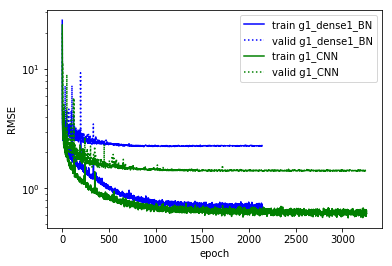

In [41]:
plot_loss([g1_model1BN_hist, g1_model2_hist],['g1_dense1_BN','g1_CNN'])

### Use the custom generator to enhance the training data

In [44]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train,Y1_train,whichlabels=list(labels1), batch_size=32)

In [45]:
# basically a copy of model 2, but will train with augmented data
g1_model2_augmented = Sequential()
g1_model2_augmented.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2_augmented.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2_augmented.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
g1_model2_augmented.add(Flatten())
g1_model2_augmented.add(Dense(500, activation = "relu"))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(Dense(100, activation = "relu"))
g1_model2_augmented.add(BatchNormalization())
g1_model2_augmented.add(Dense(30))
print(g1_model2_augmented.summary())
g1_model2_augmented_hist, g1_model2_augmented = fit_model(g1_model2_augmented, data1,
                                                    'g1_CNN_augmented', datagen)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 128)       32896     
__________

53/53 [==============================] - 4s 82ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 59/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 60/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 61/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 62/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 63/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 64/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 65/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 66/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 67/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0024 - va

53/53 [==============================] - 4s 81ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 138/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 139/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 140/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 141/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 142/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 143/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 144/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 145/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 146/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.

Epoch 216/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 217/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 218/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 219/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 220/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 221/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 222/10000
53/53 [==============================] - 4s 79ms/step - loss: 0.0012 - val_loss: 9.9003e-04
Epoch 223/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 224/10000
53/53 [==============================] - 4s 80ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 225/10000
53/53 [==============================] - 4s 

53/53 [==============================] - 4s 81ms/step - loss: 8.3379e-04 - val_loss: 9.9385e-04
Epoch 293/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.5592e-04 - val_loss: 8.0277e-04
Epoch 294/10000
53/53 [==============================] - 4s 79ms/step - loss: 8.7852e-04 - val_loss: 9.4379e-04
Epoch 295/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.0744e-04 - val_loss: 8.8943e-04
Epoch 296/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.1645e-04 - val_loss: 9.7182e-04
Epoch 297/10000
53/53 [==============================] - 4s 81ms/step - loss: 8.5350e-04 - val_loss: 9.3495e-04
Epoch 298/10000
53/53 [==============================] - 4s 81ms/step - loss: 8.6812e-04 - val_loss: 0.0011
Epoch 299/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.6960e-04 - val_loss: 9.2324e-04
Epoch 300/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.5247e-04 - val_loss: 9.5360e-04
Epoch 301/10

Epoch 366/10000
53/53 [==============================] - 4s 76ms/step - loss: 7.6717e-04 - val_loss: 8.5522e-04
Epoch 367/10000
53/53 [==============================] - 4s 78ms/step - loss: 7.4759e-04 - val_loss: 7.7954e-04
Epoch 368/10000
53/53 [==============================] - 4s 78ms/step - loss: 7.2832e-04 - val_loss: 8.1480e-04
Epoch 369/10000
53/53 [==============================] - 4s 76ms/step - loss: 7.3485e-04 - val_loss: 8.5762e-04
Epoch 370/10000
53/53 [==============================] - 4s 76ms/step - loss: 7.4097e-04 - val_loss: 7.6224e-04
Epoch 371/10000
53/53 [==============================] - 4s 76ms/step - loss: 7.6599e-04 - val_loss: 7.9754e-04
Epoch 372/10000
53/53 [==============================] - 4s 75ms/step - loss: 7.3370e-04 - val_loss: 8.6119e-04
Epoch 373/10000
53/53 [==============================] - 4s 75ms/step - loss: 7.0650e-04 - val_loss: 8.3126e-04
Epoch 374/10000
53/53 [==============================] - 4s 75ms/step - loss: 7.1795e-04 - val_loss: 0.0

53/53 [==============================] - 4s 78ms/step - loss: 6.4352e-04 - val_loss: 7.4131e-04
Epoch 440/10000
53/53 [==============================] - 4s 77ms/step - loss: 7.1101e-04 - val_loss: 7.9187e-04
Epoch 441/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.6603e-04 - val_loss: 7.5040e-04
Epoch 442/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.9950e-04 - val_loss: 6.7614e-04
Epoch 443/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.1859e-04 - val_loss: 7.4059e-04
Epoch 444/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.6561e-04 - val_loss: 7.7457e-04
Epoch 445/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.6150e-04 - val_loss: 6.7419e-04
Epoch 446/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.6142e-04 - val_loss: 7.0822e-04
Epoch 447/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.8497e-04 - val_loss: 7.7355e-04
Epoch 44

53/53 [==============================] - 4s 78ms/step - loss: 5.9389e-04 - val_loss: 7.0053e-04
Epoch 513/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.0420e-04 - val_loss: 7.4485e-04
Epoch 514/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.4523e-04 - val_loss: 7.4054e-04
Epoch 515/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.4900e-04 - val_loss: 7.0978e-04
Epoch 516/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.4636e-04 - val_loss: 9.2574e-04
Epoch 517/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.3887e-04 - val_loss: 7.9455e-04
Epoch 518/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.8230e-04 - val_loss: 6.9013e-04
Epoch 519/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.0089e-04 - val_loss: 7.8113e-04
Epoch 520/10000
53/53 [==============================] - 4s 78ms/step - loss: 6.2917e-04 - val_loss: 7.6762e-04
Epoch 52

53/53 [==============================] - 4s 79ms/step - loss: 5.7612e-04 - val_loss: 0.0095
Epoch 587/10000
53/53 [==============================] - 4s 77ms/step - loss: 6.0249e-04 - val_loss: 0.0013
Epoch 588/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.3164e-04 - val_loss: 0.0018
Epoch 589/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.4418e-04 - val_loss: 0.0022
Epoch 590/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.4066e-04 - val_loss: 6.6533e-04
Epoch 591/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.6555e-04 - val_loss: 0.0013
Epoch 592/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.2703e-04 - val_loss: 0.0049
Epoch 593/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.4655e-04 - val_loss: 0.0301
Epoch 594/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.9534e-04 - val_loss: 7.0672e-04
Epoch 595/10000
53/53 [=============

53/53 [==============================] - 4s 76ms/step - loss: 4.9175e-04 - val_loss: 6.9206e-04
Epoch 660/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.3156e-04 - val_loss: 6.7128e-04
Epoch 661/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.4679e-04 - val_loss: 7.0018e-04
Epoch 662/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.4079e-04 - val_loss: 7.2116e-04
Epoch 663/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.2376e-04 - val_loss: 6.6708e-04
Epoch 664/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.0884e-04 - val_loss: 7.0151e-04
Epoch 665/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.2751e-04 - val_loss: 6.7759e-04
Epoch 666/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.4653e-04 - val_loss: 6.7074e-04
Epoch 667/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.1662e-04 - val_loss: 6.2828e-04
Epoch 66

53/53 [==============================] - 4s 75ms/step - loss: 4.8813e-04 - val_loss: 6.4531e-04
Epoch 733/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.6884e-04 - val_loss: 6.3725e-04
Epoch 734/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.3541e-04 - val_loss: 6.2283e-04
Epoch 735/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.8998e-04 - val_loss: 6.5056e-04
Epoch 736/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.4202e-04 - val_loss: 6.7212e-04
Epoch 737/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.3035e-04 - val_loss: 6.2522e-04
Epoch 738/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.9336e-04 - val_loss: 6.3766e-04
Epoch 739/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.7949e-04 - val_loss: 7.0661e-04
Epoch 740/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.1741e-04 - val_loss: 6.7815e-04
Epoch 74

53/53 [==============================] - 4s 77ms/step - loss: 4.8041e-04 - val_loss: 6.5567e-04
Epoch 806/10000
53/53 [==============================] - 4s 77ms/step - loss: 5.0268e-04 - val_loss: 6.6270e-04
Epoch 807/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.7338e-04 - val_loss: 6.3449e-04
Epoch 808/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.2550e-04 - val_loss: 6.4651e-04
Epoch 809/10000
53/53 [==============================] - 4s 81ms/step - loss: 5.0901e-04 - val_loss: 7.0262e-04
Epoch 810/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.6627e-04 - val_loss: 6.6145e-04
Epoch 811/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.9710e-04 - val_loss: 6.3949e-04
Epoch 812/10000
53/53 [==============================] - 4s 78ms/step - loss: 5.2527e-04 - val_loss: 6.3116e-04
Epoch 813/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.5977e-04 - val_loss: 6.2377e-04
Epoch 81

53/53 [==============================] - 4s 76ms/step - loss: 4.6124e-04 - val_loss: 0.0012
Epoch 879/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.8289e-04 - val_loss: 0.0011
Epoch 880/10000
53/53 [==============================] - 4s 76ms/step - loss: 5.0698e-04 - val_loss: 0.0059
Epoch 881/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0981e-04 - val_loss: 7.5845e-04
Epoch 882/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.3220e-04 - val_loss: 0.0015
Epoch 883/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.3792e-04 - val_loss: 0.0018
Epoch 884/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.7604e-04 - val_loss: 0.0029
Epoch 885/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.2251e-04 - val_loss: 0.0012
Epoch 886/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.3025e-04 - val_loss: 7.4671e-04
Epoch 887/10000
53/53 [=============

Epoch 953/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.2017e-04 - val_loss: 6.2066e-04
Epoch 954/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.4223e-04 - val_loss: 0.0010
Epoch 955/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.0377e-04 - val_loss: 6.1133e-04
Epoch 956/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.3834e-04 - val_loss: 6.4787e-04
Epoch 957/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.6058e-04 - val_loss: 6.3820e-04
Epoch 958/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1370e-04 - val_loss: 0.0012
Epoch 959/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8928e-04 - val_loss: 6.1599e-04
Epoch 960/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.8621e-04 - val_loss: 6.5144e-04
Epoch 961/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.1194e-04 - val_loss: 6.2729e-04


Epoch 1026/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0964e-04 - val_loss: 5.9683e-04
Epoch 1027/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.0726e-04 - val_loss: 6.0872e-04
Epoch 1028/10000
53/53 [==============================] - 4s 81ms/step - loss: 4.0053e-04 - val_loss: 6.0471e-04
Epoch 1029/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.2025e-04 - val_loss: 6.0996e-04
Epoch 1030/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.7113e-04 - val_loss: 6.3355e-04
Epoch 1031/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.7517e-04 - val_loss: 6.1483e-04
Epoch 1032/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.2711e-04 - val_loss: 6.2861e-04
Epoch 1033/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.3004e-04 - val_loss: 6.1918e-04
Epoch 1034/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.2823e-04 - val_

53/53 [==============================] - 4s 77ms/step - loss: 3.9881e-04 - val_loss: 6.2864e-04
Epoch 1099/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.3375e-04 - val_loss: 6.4330e-04
Epoch 1100/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.1324e-04 - val_loss: 6.2022e-04
Epoch 1101/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.3497e-04 - val_loss: 6.3417e-04
Epoch 1102/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.3567e-04 - val_loss: 6.3343e-04
Epoch 1103/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.5144e-04 - val_loss: 6.2974e-04
Epoch 1104/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.7834e-04 - val_loss: 6.1309e-04
Epoch 1105/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.5061e-04 - val_loss: 6.2732e-04
Epoch 1106/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.2721e-04 - val_loss: 6.1483e-04


53/53 [==============================] - 4s 76ms/step - loss: 4.0814e-04 - val_loss: 6.0249e-04
Epoch 1171/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.2930e-04 - val_loss: 6.1179e-04
Epoch 1172/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.0622e-04 - val_loss: 6.1026e-04
Epoch 1173/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.8233e-04 - val_loss: 6.1163e-04
Epoch 1174/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1035e-04 - val_loss: 6.0559e-04
Epoch 1175/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1172e-04 - val_loss: 6.3205e-04
Epoch 1176/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.1475e-04 - val_loss: 6.3801e-04
Epoch 1177/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.9213e-04 - val_loss: 6.0714e-04
Epoch 1178/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.6885e-04 - val_loss: 6.3412e-04


53/53 [==============================] - 4s 77ms/step - loss: 3.8922e-04 - val_loss: 6.2261e-04
Epoch 1243/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0394e-04 - val_loss: 6.3335e-04
Epoch 1244/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8243e-04 - val_loss: 6.0926e-04
Epoch 1245/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8787e-04 - val_loss: 5.9322e-04
Epoch 1246/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.9747e-04 - val_loss: 6.2389e-04
Epoch 1247/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.1345e-04 - val_loss: 6.0533e-04
Epoch 1248/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.3025e-04 - val_loss: 6.1631e-04
Epoch 1249/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0246e-04 - val_loss: 6.0035e-04
Epoch 1250/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0196e-04 - val_loss: 6.1945e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.9947e-04 - val_loss: 6.0979e-04
Epoch 1315/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1870e-04 - val_loss: 6.0187e-04
Epoch 1316/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0453e-04 - val_loss: 6.0097e-04
Epoch 1317/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.4299e-04 - val_loss: 6.1183e-04
Epoch 1318/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.2249e-04 - val_loss: 6.0844e-04
Epoch 1319/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7522e-04 - val_loss: 6.3221e-04
Epoch 1320/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.9726e-04 - val_loss: 5.9498e-04
Epoch 1321/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7725e-04 - val_loss: 6.0701e-04
Epoch 1322/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7179e-04 - val_loss: 6.2136e-04


53/53 [==============================] - 4s 77ms/step - loss: 3.7988e-04 - val_loss: 6.1439e-04
Epoch 1387/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.2170e-04 - val_loss: 6.2945e-04
Epoch 1388/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.9571e-04 - val_loss: 6.0643e-04
Epoch 1389/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.3651e-04 - val_loss: 6.2192e-04
Epoch 1390/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.1777e-04 - val_loss: 5.8573e-04
Epoch 1391/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1911e-04 - val_loss: 5.9053e-04
Epoch 1392/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0923e-04 - val_loss: 5.8774e-04
Epoch 1393/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6712e-04 - val_loss: 6.0808e-04
Epoch 1394/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.4100e-04 - val_loss: 5.9801e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.7800e-04 - val_loss: 6.5097e-04
Epoch 1459/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7537e-04 - val_loss: 5.9992e-04
Epoch 1460/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.3030e-04 - val_loss: 6.2211e-04
Epoch 1461/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.9692e-04 - val_loss: 5.9998e-04
Epoch 1462/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0081e-04 - val_loss: 6.2557e-04
Epoch 1463/10000
53/53 [==============================] - 4s 77ms/step - loss: 4.2045e-04 - val_loss: 6.1312e-04
Epoch 1464/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9551e-04 - val_loss: 5.9882e-04
Epoch 1465/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6902e-04 - val_loss: 5.8610e-04
Epoch 1466/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7498e-04 - val_loss: 5.9600e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.6146e-04 - val_loss: 6.0662e-04
Epoch 1531/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0035e-04 - val_loss: 5.9628e-04
Epoch 1532/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8472e-04 - val_loss: 5.9460e-04
Epoch 1533/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7148e-04 - val_loss: 6.1623e-04
Epoch 1534/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0842e-04 - val_loss: 6.0867e-04
Epoch 1535/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0363e-04 - val_loss: 6.1804e-04
Epoch 1536/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7972e-04 - val_loss: 5.9701e-04
Epoch 1537/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.3929e-04 - val_loss: 5.9350e-04
Epoch 1538/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4434e-04 - val_loss: 5.9229e-04


53/53 [==============================] - 4s 79ms/step - loss: 4.0073e-04 - val_loss: 6.0332e-04
Epoch 1603/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.2212e-04 - val_loss: 6.3338e-04
Epoch 1604/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7808e-04 - val_loss: 5.9329e-04
Epoch 1605/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7990e-04 - val_loss: 6.0999e-04
Epoch 1606/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7938e-04 - val_loss: 6.2661e-04
Epoch 1607/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.6793e-04 - val_loss: 6.0463e-04
Epoch 1608/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.9923e-04 - val_loss: 6.0996e-04
Epoch 1609/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1264e-04 - val_loss: 6.2096e-04
Epoch 1610/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0745e-04 - val_loss: 6.0502e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.8651e-04 - val_loss: 6.0826e-04
Epoch 1675/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7056e-04 - val_loss: 5.9386e-04
Epoch 1676/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6060e-04 - val_loss: 6.2978e-04
Epoch 1677/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7953e-04 - val_loss: 6.1199e-04
Epoch 1678/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9169e-04 - val_loss: 6.3742e-04
Epoch 1679/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9275e-04 - val_loss: 6.0418e-04
Epoch 1680/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7339e-04 - val_loss: 5.9371e-04
Epoch 1681/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8881e-04 - val_loss: 6.0075e-04
Epoch 1682/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5285e-04 - val_loss: 5.8628e-04


53/53 [==============================] - 4s 76ms/step - loss: 4.4062e-04 - val_loss: 6.1099e-04
Epoch 1747/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0116e-04 - val_loss: 6.0005e-04
Epoch 1748/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0419e-04 - val_loss: 5.8733e-04
Epoch 1749/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0931e-04 - val_loss: 6.1282e-04
Epoch 1750/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6229e-04 - val_loss: 5.9390e-04
Epoch 1751/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.8291e-04 - val_loss: 6.0305e-04
Epoch 1752/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.8886e-04 - val_loss: 6.0486e-04
Epoch 1753/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9618e-04 - val_loss: 5.9736e-04
Epoch 1754/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.6246e-04 - val_loss: 5.9112e-04


53/53 [==============================] - 4s 75ms/step - loss: 4.2305e-04 - val_loss: 6.0713e-04
Epoch 1819/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0641e-04 - val_loss: 5.8744e-04
Epoch 1820/10000
53/53 [==============================] - 4s 74ms/step - loss: 4.0352e-04 - val_loss: 6.1106e-04
Epoch 1821/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.5509e-04 - val_loss: 6.0164e-04
Epoch 1822/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5148e-04 - val_loss: 6.0309e-04
Epoch 1823/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.3301e-04 - val_loss: 6.1284e-04
Epoch 1824/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9404e-04 - val_loss: 5.9622e-04
Epoch 1825/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6395e-04 - val_loss: 5.9412e-04
Epoch 1826/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.6347e-04 - val_loss: 5.9984e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.7745e-04 - val_loss: 6.0257e-04
Epoch 1891/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.6565e-04 - val_loss: 5.9410e-04
Epoch 1892/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.8892e-04 - val_loss: 6.2520e-04
Epoch 1893/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.6365e-04 - val_loss: 6.5560e-04
Epoch 1894/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.8650e-04 - val_loss: 6.2935e-04
Epoch 1895/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.6403e-04 - val_loss: 5.9554e-04
Epoch 1896/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.7433e-04 - val_loss: 5.9790e-04
Epoch 1897/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7899e-04 - val_loss: 6.0762e-04
Epoch 1898/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4954e-04 - val_loss: 5.9791e-04


53/53 [==============================] - 4s 79ms/step - loss: 3.6684e-04 - val_loss: 6.0747e-04
Epoch 1963/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3138e-04 - val_loss: 5.9027e-04
Epoch 1964/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.9426e-04 - val_loss: 5.9287e-04
Epoch 1965/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.2046e-04 - val_loss: 6.0485e-04
Epoch 1966/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9530e-04 - val_loss: 6.0914e-04
Epoch 1967/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.2914e-04 - val_loss: 6.2493e-04
Epoch 1968/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3504e-04 - val_loss: 5.9956e-04
Epoch 1969/10000
53/53 [==============================] - 4s 73ms/step - loss: 3.9488e-04 - val_loss: 5.9573e-04
Epoch 1970/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.9110e-04 - val_loss: 6.1510e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.8055e-04 - val_loss: 6.0095e-04
Epoch 2035/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7549e-04 - val_loss: 6.1797e-04
Epoch 2036/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7519e-04 - val_loss: 6.1783e-04
Epoch 2037/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5059e-04 - val_loss: 5.9456e-04
Epoch 2038/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8495e-04 - val_loss: 5.9917e-04
Epoch 2039/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.0830e-04 - val_loss: 6.3580e-04
Epoch 2040/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4476e-04 - val_loss: 5.9463e-04
Epoch 2041/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4790e-04 - val_loss: 5.9668e-04
Epoch 2042/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7995e-04 - val_loss: 6.1174e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.9452e-04 - val_loss: 6.0474e-04
Epoch 2107/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6737e-04 - val_loss: 6.0208e-04
Epoch 2108/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6540e-04 - val_loss: 6.2688e-04
Epoch 2109/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0229e-04 - val_loss: 6.0761e-04
Epoch 2110/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6024e-04 - val_loss: 6.1636e-04
Epoch 2111/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9948e-04 - val_loss: 6.0031e-04
Epoch 2112/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7964e-04 - val_loss: 6.3863e-04
Epoch 2113/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6333e-04 - val_loss: 5.9754e-04
Epoch 2114/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.8347e-04 - val_loss: 6.1844e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.0551e-04 - val_loss: 5.9726e-04
Epoch 2179/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.4501e-04 - val_loss: 5.9522e-04
Epoch 2180/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8199e-04 - val_loss: 5.9246e-04
Epoch 2181/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.5795e-04 - val_loss: 6.3121e-04
Epoch 2182/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.1825e-04 - val_loss: 5.9925e-04
Epoch 2183/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.5205e-04 - val_loss: 6.4653e-04
Epoch 2184/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.6481e-04 - val_loss: 6.0153e-04
Epoch 2185/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1146e-04 - val_loss: 5.9648e-04
Epoch 2186/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4766e-04 - val_loss: 5.9591e-04


53/53 [==============================] - 4s 77ms/step - loss: 3.5449e-04 - val_loss: 5.9693e-04
Epoch 2251/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7696e-04 - val_loss: 6.1120e-04
Epoch 2252/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.8009e-04 - val_loss: 5.9907e-04
Epoch 2253/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7121e-04 - val_loss: 6.3002e-04
Epoch 2254/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7876e-04 - val_loss: 6.1118e-04
Epoch 2255/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.3773e-04 - val_loss: 6.0109e-04
Epoch 2256/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.3571e-04 - val_loss: 6.2884e-04
Epoch 2257/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4680e-04 - val_loss: 6.1699e-04
Epoch 2258/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.6492e-04 - val_loss: 6.0401e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.2673e-04 - val_loss: 6.0410e-04
Epoch 2323/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3932e-04 - val_loss: 6.0224e-04
Epoch 2324/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.2334e-04 - val_loss: 5.8563e-04
Epoch 2325/10000
53/53 [==============================] - 4s 79ms/step - loss: 3.6709e-04 - val_loss: 5.9711e-04
Epoch 2326/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3652e-04 - val_loss: 5.8222e-04
Epoch 2327/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.5858e-04 - val_loss: 6.2728e-04
Epoch 2328/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.5007e-04 - val_loss: 5.9195e-04
Epoch 2329/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.9257e-04 - val_loss: 5.8342e-04
Epoch 2330/10000
53/53 [==============================] - 4s 79ms/step - loss: 4.0951e-04 - val_loss: 6.0386e-04


53/53 [==============================] - 4s 78ms/step - loss: 3.5074e-04 - val_loss: 6.2494e-04
Epoch 2395/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7825e-04 - val_loss: 6.3110e-04
Epoch 2396/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8692e-04 - val_loss: 5.8716e-04
Epoch 2397/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.6770e-04 - val_loss: 5.9792e-04
Epoch 2398/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.6835e-04 - val_loss: 6.0274e-04
Epoch 2399/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.6395e-04 - val_loss: 6.1174e-04
Epoch 2400/10000
53/53 [==============================] - 4s 79ms/step - loss: 3.6578e-04 - val_loss: 5.8280e-04
Epoch 2401/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.8867e-04 - val_loss: 5.8679e-04
Epoch 2402/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4761e-04 - val_loss: 5.8206e-04


53/53 [==============================] - 4s 77ms/step - loss: 3.7268e-04 - val_loss: 6.0107e-04
Epoch 2467/10000
53/53 [==============================] - 4s 79ms/step - loss: 3.9750e-04 - val_loss: 6.2901e-04
Epoch 2468/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.3972e-04 - val_loss: 6.3201e-04
Epoch 2469/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0137e-04 - val_loss: 5.9732e-04
Epoch 2470/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.6859e-04 - val_loss: 6.0211e-04
Epoch 2471/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6181e-04 - val_loss: 6.0133e-04
Epoch 2472/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.2974e-04 - val_loss: 5.9270e-04
Epoch 2473/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7155e-04 - val_loss: 5.9300e-04
Epoch 2474/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5430e-04 - val_loss: 6.0246e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.9500e-04 - val_loss: 6.2938e-04
Epoch 2539/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.5655e-04 - val_loss: 5.8786e-04
Epoch 2540/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.9177e-04 - val_loss: 5.9382e-04
Epoch 2541/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5535e-04 - val_loss: 5.9649e-04
Epoch 2542/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4531e-04 - val_loss: 6.0208e-04
Epoch 2543/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7539e-04 - val_loss: 5.9207e-04
Epoch 2544/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7835e-04 - val_loss: 5.9852e-04
Epoch 2545/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6836e-04 - val_loss: 6.0822e-04
Epoch 2546/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.1354e-04 - val_loss: 6.1156e-04


53/53 [==============================] - 4s 75ms/step - loss: 4.2023e-04 - val_loss: 5.9272e-04
Epoch 2611/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.1044e-04 - val_loss: 5.9700e-04
Epoch 2612/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4877e-04 - val_loss: 5.8234e-04
Epoch 2613/10000
53/53 [==============================] - 4s 74ms/step - loss: 4.1886e-04 - val_loss: 6.2511e-04
Epoch 2614/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0176e-04 - val_loss: 6.1810e-04
Epoch 2615/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4370e-04 - val_loss: 6.1860e-04
Epoch 2616/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7434e-04 - val_loss: 6.0191e-04
Epoch 2617/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3657e-04 - val_loss: 5.9695e-04
Epoch 2618/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4464e-04 - val_loss: 6.0145e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.3309e-04 - val_loss: 5.9279e-04
Epoch 2683/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.6647e-04 - val_loss: 6.2821e-04
Epoch 2684/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7514e-04 - val_loss: 6.0078e-04
Epoch 2685/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.2995e-04 - val_loss: 6.1345e-04
Epoch 2686/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5644e-04 - val_loss: 5.9094e-04
Epoch 2687/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6010e-04 - val_loss: 5.9925e-04
Epoch 2688/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3343e-04 - val_loss: 6.0439e-04
Epoch 2689/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6464e-04 - val_loss: 6.1605e-04
Epoch 2690/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1435e-04 - val_loss: 5.9470e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.5845e-04 - val_loss: 5.9251e-04
Epoch 2755/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.1420e-04 - val_loss: 5.9599e-04
Epoch 2756/10000
53/53 [==============================] - 4s 78ms/step - loss: 4.0262e-04 - val_loss: 5.8912e-04
Epoch 2757/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5175e-04 - val_loss: 5.8496e-04
Epoch 2758/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6261e-04 - val_loss: 6.2321e-04
Epoch 2759/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4842e-04 - val_loss: 5.8576e-04
Epoch 2760/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9880e-04 - val_loss: 5.8660e-04
Epoch 2761/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0788e-04 - val_loss: 5.9149e-04
Epoch 2762/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6864e-04 - val_loss: 5.9041e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.4062e-04 - val_loss: 6.0238e-04
Epoch 2827/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4742e-04 - val_loss: 5.9566e-04
Epoch 2828/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6781e-04 - val_loss: 6.2360e-04
Epoch 2829/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3252e-04 - val_loss: 5.9387e-04
Epoch 2830/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5787e-04 - val_loss: 5.8973e-04
Epoch 2831/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5456e-04 - val_loss: 6.0258e-04
Epoch 2832/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.6490e-04 - val_loss: 6.0185e-04
Epoch 2833/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8768e-04 - val_loss: 5.9183e-04
Epoch 2834/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.8453e-04 - val_loss: 5.9906e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.9768e-04 - val_loss: 6.0145e-04
Epoch 2899/10000
53/53 [==============================] - 4s 74ms/step - loss: 4.0804e-04 - val_loss: 5.8432e-04
Epoch 2900/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1308e-04 - val_loss: 5.9735e-04
Epoch 2901/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5523e-04 - val_loss: 6.0431e-04
Epoch 2902/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.0799e-04 - val_loss: 6.1936e-04
Epoch 2903/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4177e-04 - val_loss: 5.8718e-04
Epoch 2904/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.0215e-04 - val_loss: 6.0613e-04
Epoch 2905/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8057e-04 - val_loss: 5.9087e-04
Epoch 2906/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3333e-04 - val_loss: 5.9658e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.7380e-04 - val_loss: 6.0157e-04
Epoch 2971/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.2944e-04 - val_loss: 6.0692e-04
Epoch 2972/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.5800e-04 - val_loss: 5.9917e-04
Epoch 2973/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7233e-04 - val_loss: 5.9890e-04
Epoch 2974/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9013e-04 - val_loss: 5.9042e-04
Epoch 2975/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.0561e-04 - val_loss: 5.9204e-04
Epoch 2976/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4454e-04 - val_loss: 5.9211e-04
Epoch 2977/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4714e-04 - val_loss: 5.9363e-04
Epoch 2978/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7735e-04 - val_loss: 5.8497e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.6701e-04 - val_loss: 6.1192e-04
Epoch 3043/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4051e-04 - val_loss: 6.1692e-04
Epoch 3044/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3945e-04 - val_loss: 5.8624e-04
Epoch 3045/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.3387e-04 - val_loss: 5.9600e-04
Epoch 3046/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3239e-04 - val_loss: 6.0184e-04
Epoch 3047/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.5133e-04 - val_loss: 6.0147e-04
Epoch 3048/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0620e-04 - val_loss: 6.0271e-04
Epoch 3049/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6461e-04 - val_loss: 6.0153e-04
Epoch 3050/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.1901e-04 - val_loss: 5.9539e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.6129e-04 - val_loss: 5.9436e-04
Epoch 3115/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6501e-04 - val_loss: 5.9832e-04
Epoch 3116/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5726e-04 - val_loss: 6.0535e-04
Epoch 3117/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3060e-04 - val_loss: 6.0882e-04
Epoch 3118/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7584e-04 - val_loss: 5.9212e-04
Epoch 3119/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.7165e-04 - val_loss: 6.1958e-04
Epoch 3120/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3384e-04 - val_loss: 5.8444e-04
Epoch 3121/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.1067e-04 - val_loss: 5.9616e-04
Epoch 3122/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4119e-04 - val_loss: 5.9289e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.2078e-04 - val_loss: 5.8243e-04
Epoch 3187/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5074e-04 - val_loss: 6.3482e-04
Epoch 3188/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3755e-04 - val_loss: 6.2309e-04
Epoch 3189/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3641e-04 - val_loss: 5.9692e-04
Epoch 3190/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8191e-04 - val_loss: 5.9190e-04
Epoch 3191/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.5577e-04 - val_loss: 5.9812e-04
Epoch 3192/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7603e-04 - val_loss: 5.8731e-04
Epoch 3193/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3411e-04 - val_loss: 6.0150e-04
Epoch 3194/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.4982e-04 - val_loss: 6.1024e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.7406e-04 - val_loss: 5.7533e-04
Epoch 3259/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.3345e-04 - val_loss: 6.2916e-04
Epoch 3260/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5987e-04 - val_loss: 5.8668e-04
Epoch 3261/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5438e-04 - val_loss: 5.8772e-04
Epoch 3262/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.9570e-04 - val_loss: 6.2194e-04
Epoch 3263/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6134e-04 - val_loss: 5.8560e-04
Epoch 3264/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7580e-04 - val_loss: 5.9482e-04
Epoch 3265/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.1837e-04 - val_loss: 6.0147e-04
Epoch 3266/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.3813e-04 - val_loss: 5.8654e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.6661e-04 - val_loss: 6.1027e-04
Epoch 3331/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4715e-04 - val_loss: 5.8580e-04
Epoch 3332/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6462e-04 - val_loss: 5.8604e-04
Epoch 3333/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1256e-04 - val_loss: 5.9463e-04
Epoch 3334/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6126e-04 - val_loss: 5.8100e-04
Epoch 3335/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.2500e-04 - val_loss: 5.7430e-04
Epoch 3336/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3668e-04 - val_loss: 5.8103e-04
Epoch 3337/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.2791e-04 - val_loss: 6.0039e-04
Epoch 3338/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.7647e-04 - val_loss: 6.5226e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.3432e-04 - val_loss: 6.0185e-04
Epoch 3403/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.3891e-04 - val_loss: 5.8518e-04
Epoch 3404/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.3694e-04 - val_loss: 6.0565e-04
Epoch 3405/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.2390e-04 - val_loss: 6.0570e-04
Epoch 3406/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.9295e-04 - val_loss: 5.9043e-04
Epoch 3407/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.8502e-04 - val_loss: 5.8219e-04
Epoch 3408/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1837e-04 - val_loss: 5.8740e-04
Epoch 3409/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1561e-04 - val_loss: 5.9104e-04
Epoch 3410/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.8743e-04 - val_loss: 6.0623e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.5991e-04 - val_loss: 5.9000e-04
Epoch 3475/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3532e-04 - val_loss: 5.8990e-04
Epoch 3476/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4930e-04 - val_loss: 5.9008e-04
Epoch 3477/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5782e-04 - val_loss: 6.2373e-04
Epoch 3478/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6719e-04 - val_loss: 6.1113e-04
Epoch 3479/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4448e-04 - val_loss: 5.9449e-04
Epoch 3480/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.6835e-04 - val_loss: 5.8410e-04
Epoch 3481/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.7122e-04 - val_loss: 5.9381e-04
Epoch 3482/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6236e-04 - val_loss: 5.8684e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.2905e-04 - val_loss: 5.7777e-04
Epoch 3547/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3130e-04 - val_loss: 5.8800e-04
Epoch 3548/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6125e-04 - val_loss: 5.9504e-04
Epoch 3549/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.3828e-04 - val_loss: 6.1190e-04
Epoch 3550/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6513e-04 - val_loss: 5.9027e-04
Epoch 3551/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0981e-04 - val_loss: 6.0434e-04
Epoch 3552/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3687e-04 - val_loss: 5.8437e-04
Epoch 3553/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5727e-04 - val_loss: 5.8137e-04
Epoch 3554/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8736e-04 - val_loss: 5.9368e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.5642e-04 - val_loss: 5.9381e-04
Epoch 3619/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3345e-04 - val_loss: 5.8369e-04
Epoch 3620/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5847e-04 - val_loss: 6.0264e-04
Epoch 3621/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3963e-04 - val_loss: 5.9625e-04
Epoch 3622/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.5726e-04 - val_loss: 5.8229e-04
Epoch 3623/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7599e-04 - val_loss: 6.4190e-04
Epoch 3624/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7319e-04 - val_loss: 5.9217e-04
Epoch 3625/10000
53/53 [==============================] - 4s 76ms/step - loss: 2.9305e-04 - val_loss: 5.8408e-04
Epoch 3626/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6551e-04 - val_loss: 6.0398e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.7130e-04 - val_loss: 6.1025e-04
Epoch 3691/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7573e-04 - val_loss: 5.8888e-04
Epoch 3692/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4687e-04 - val_loss: 5.9357e-04
Epoch 3693/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.2931e-04 - val_loss: 5.9498e-04
Epoch 3694/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3423e-04 - val_loss: 5.8809e-04
Epoch 3695/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.1546e-04 - val_loss: 5.8566e-04
Epoch 3696/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.2294e-04 - val_loss: 6.0721e-04
Epoch 3697/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6099e-04 - val_loss: 5.8173e-04
Epoch 3698/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4612e-04 - val_loss: 6.0513e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.3355e-04 - val_loss: 5.8539e-04
Epoch 3763/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8206e-04 - val_loss: 5.8002e-04
Epoch 3764/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.1675e-04 - val_loss: 5.8864e-04
Epoch 3765/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3655e-04 - val_loss: 5.9460e-04
Epoch 3766/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5827e-04 - val_loss: 6.4055e-04
Epoch 3767/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.8037e-04 - val_loss: 5.9257e-04
Epoch 3768/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5431e-04 - val_loss: 5.9348e-04
Epoch 3769/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7447e-04 - val_loss: 5.9455e-04
Epoch 3770/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5275e-04 - val_loss: 5.7989e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.4446e-04 - val_loss: 5.8533e-04
Epoch 3835/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.8169e-04 - val_loss: 5.9919e-04
Epoch 3836/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7206e-04 - val_loss: 5.9539e-04
Epoch 3837/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5848e-04 - val_loss: 5.9049e-04
Epoch 3838/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.9010e-04 - val_loss: 6.0125e-04
Epoch 3839/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.2398e-04 - val_loss: 5.9774e-04
Epoch 3840/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.8283e-04 - val_loss: 5.9926e-04
Epoch 3841/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7204e-04 - val_loss: 6.0074e-04
Epoch 3842/10000
53/53 [==============================] - 4s 73ms/step - loss: 4.2669e-04 - val_loss: 5.8449e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.3238e-04 - val_loss: 6.1533e-04
Epoch 3907/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6566e-04 - val_loss: 6.0619e-04
Epoch 3908/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5612e-04 - val_loss: 5.8652e-04
Epoch 3909/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5626e-04 - val_loss: 5.8925e-04
Epoch 3910/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3089e-04 - val_loss: 5.9430e-04
Epoch 3911/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5086e-04 - val_loss: 5.9434e-04
Epoch 3912/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8349e-04 - val_loss: 5.7559e-04
Epoch 3913/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5769e-04 - val_loss: 5.8659e-04
Epoch 3914/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0604e-04 - val_loss: 6.1625e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.7183e-04 - val_loss: 6.0125e-04
Epoch 3979/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6295e-04 - val_loss: 6.2414e-04
Epoch 3980/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6835e-04 - val_loss: 5.9651e-04
Epoch 3981/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.2551e-04 - val_loss: 5.8833e-04
Epoch 3982/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1054e-04 - val_loss: 5.9465e-04
Epoch 3983/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.1301e-04 - val_loss: 5.8942e-04
Epoch 3984/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6742e-04 - val_loss: 5.7691e-04
Epoch 3985/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.5586e-04 - val_loss: 5.9518e-04
Epoch 3986/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.7249e-04 - val_loss: 5.9636e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.4808e-04 - val_loss: 5.8867e-04
Epoch 4051/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.4983e-04 - val_loss: 5.7960e-04
Epoch 4052/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.2488e-04 - val_loss: 6.1362e-04
Epoch 4053/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5289e-04 - val_loss: 5.8392e-04
Epoch 4054/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.1573e-04 - val_loss: 5.9419e-04
Epoch 4055/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.0287e-04 - val_loss: 5.7671e-04
Epoch 4056/10000
53/53 [==============================] - 4s 79ms/step - loss: 3.6361e-04 - val_loss: 5.9096e-04
Epoch 4057/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.8406e-04 - val_loss: 6.2716e-04
Epoch 4058/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.4255e-04 - val_loss: 5.9816e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.8506e-04 - val_loss: 6.0022e-04
Epoch 4123/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3611e-04 - val_loss: 5.8698e-04
Epoch 4124/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0338e-04 - val_loss: 5.9254e-04
Epoch 4125/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6182e-04 - val_loss: 5.8814e-04
Epoch 4126/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6074e-04 - val_loss: 6.0067e-04
Epoch 4127/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6908e-04 - val_loss: 5.9766e-04
Epoch 4128/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7743e-04 - val_loss: 6.0266e-04
Epoch 4129/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6351e-04 - val_loss: 6.0755e-04
Epoch 4130/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5851e-04 - val_loss: 5.7988e-04


53/53 [==============================] - 4s 76ms/step - loss: 2.9228e-04 - val_loss: 5.9824e-04
Epoch 4195/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4643e-04 - val_loss: 5.8386e-04
Epoch 4196/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4128e-04 - val_loss: 6.0253e-04
Epoch 4197/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.2120e-04 - val_loss: 5.9678e-04
Epoch 4198/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3686e-04 - val_loss: 5.9335e-04
Epoch 4199/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4606e-04 - val_loss: 5.7997e-04
Epoch 4200/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.3515e-04 - val_loss: 5.9551e-04
Epoch 4201/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.1273e-04 - val_loss: 5.8841e-04
Epoch 4202/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6123e-04 - val_loss: 5.9876e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.4538e-04 - val_loss: 5.9842e-04
Epoch 4267/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7282e-04 - val_loss: 5.8534e-04
Epoch 4268/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4200e-04 - val_loss: 5.9768e-04
Epoch 4269/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4070e-04 - val_loss: 5.9156e-04
Epoch 4270/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0778e-04 - val_loss: 6.1636e-04
Epoch 4271/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1379e-04 - val_loss: 5.8748e-04
Epoch 4272/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.1080e-04 - val_loss: 5.8277e-04
Epoch 4273/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.2303e-04 - val_loss: 5.9314e-04
Epoch 4274/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4007e-04 - val_loss: 5.9527e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.5646e-04 - val_loss: 6.0252e-04
Epoch 4339/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5226e-04 - val_loss: 5.9716e-04
Epoch 4340/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0258e-04 - val_loss: 5.7817e-04
Epoch 4341/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8091e-04 - val_loss: 5.8936e-04
Epoch 4342/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.5025e-04 - val_loss: 6.0502e-04
Epoch 4343/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.8363e-04 - val_loss: 5.8571e-04
Epoch 4344/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3108e-04 - val_loss: 6.1017e-04
Epoch 4345/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3754e-04 - val_loss: 6.0186e-04
Epoch 4346/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5271e-04 - val_loss: 5.8598e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.6039e-04 - val_loss: 6.0815e-04
Epoch 4411/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4978e-04 - val_loss: 5.8417e-04
Epoch 4412/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5295e-04 - val_loss: 5.9122e-04
Epoch 4413/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4203e-04 - val_loss: 5.9682e-04
Epoch 4414/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.2731e-04 - val_loss: 5.8448e-04
Epoch 4415/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4358e-04 - val_loss: 5.8574e-04
Epoch 4416/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5727e-04 - val_loss: 6.0639e-04
Epoch 4417/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5244e-04 - val_loss: 5.7853e-04
Epoch 4418/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.1557e-04 - val_loss: 5.9966e-04


53/53 [==============================] - 4s 78ms/step - loss: 3.2688e-04 - val_loss: 5.8223e-04
Epoch 4483/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.4100e-04 - val_loss: 5.9394e-04
Epoch 4484/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4397e-04 - val_loss: 5.8425e-04
Epoch 4485/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3820e-04 - val_loss: 6.2950e-04
Epoch 4486/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0616e-04 - val_loss: 6.1875e-04
Epoch 4487/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4780e-04 - val_loss: 5.9650e-04
Epoch 4488/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5793e-04 - val_loss: 5.8854e-04
Epoch 4489/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.2656e-04 - val_loss: 6.1071e-04
Epoch 4490/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4336e-04 - val_loss: 5.9500e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.4682e-04 - val_loss: 5.8634e-04
Epoch 4555/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5774e-04 - val_loss: 5.8924e-04
Epoch 4556/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.3460e-04 - val_loss: 6.0007e-04
Epoch 4557/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5827e-04 - val_loss: 5.9771e-04
Epoch 4558/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6145e-04 - val_loss: 6.0237e-04
Epoch 4559/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.2631e-04 - val_loss: 5.9441e-04
Epoch 4560/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6186e-04 - val_loss: 5.9634e-04
Epoch 4561/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8464e-04 - val_loss: 5.7351e-04
Epoch 4562/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.1464e-04 - val_loss: 5.7464e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.3306e-04 - val_loss: 5.8904e-04
Epoch 4627/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.0754e-04 - val_loss: 6.1785e-04
Epoch 4628/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5857e-04 - val_loss: 6.1305e-04
Epoch 4629/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.1709e-04 - val_loss: 5.9258e-04
Epoch 4630/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4477e-04 - val_loss: 5.9364e-04
Epoch 4631/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5332e-04 - val_loss: 5.9515e-04
Epoch 4632/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5882e-04 - val_loss: 5.7457e-04
Epoch 4633/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4572e-04 - val_loss: 5.9446e-04
Epoch 4634/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1365e-04 - val_loss: 5.9649e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.2192e-04 - val_loss: 6.0038e-04
Epoch 4699/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.4118e-04 - val_loss: 6.0259e-04
Epoch 4700/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4304e-04 - val_loss: 5.8651e-04
Epoch 4701/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0235e-04 - val_loss: 6.1689e-04
Epoch 4702/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5807e-04 - val_loss: 5.9108e-04
Epoch 4703/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4494e-04 - val_loss: 5.7704e-04
Epoch 4704/10000
53/53 [==============================] - 4s 73ms/step - loss: 3.5428e-04 - val_loss: 5.9367e-04
Epoch 4705/10000
53/53 [==============================] - 4s 80ms/step - loss: 3.8469e-04 - val_loss: 5.9850e-04
Epoch 4706/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4049e-04 - val_loss: 5.8761e-04


53/53 [==============================] - 4s 76ms/step - loss: 2.9658e-04 - val_loss: 5.7786e-04
Epoch 4771/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4248e-04 - val_loss: 6.1772e-04
Epoch 4772/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4963e-04 - val_loss: 5.8045e-04
Epoch 4773/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.1909e-04 - val_loss: 6.0864e-04
Epoch 4774/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5998e-04 - val_loss: 6.0032e-04
Epoch 4775/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.4348e-04 - val_loss: 6.1639e-04
Epoch 4776/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.3042e-04 - val_loss: 6.4497e-04
Epoch 4777/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5693e-04 - val_loss: 5.9214e-04
Epoch 4778/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4532e-04 - val_loss: 5.8135e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.5570e-04 - val_loss: 5.9764e-04
Epoch 4843/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4566e-04 - val_loss: 6.0310e-04
Epoch 4844/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1646e-04 - val_loss: 5.9011e-04
Epoch 4845/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6187e-04 - val_loss: 5.8035e-04
Epoch 4846/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5986e-04 - val_loss: 5.9134e-04
Epoch 4847/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6399e-04 - val_loss: 5.8249e-04
Epoch 4848/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.2090e-04 - val_loss: 5.8482e-04
Epoch 4849/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5893e-04 - val_loss: 6.2763e-04
Epoch 4850/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.8230e-04 - val_loss: 5.9042e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.8358e-04 - val_loss: 6.0306e-04
Epoch 4915/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.3045e-04 - val_loss: 5.9702e-04
Epoch 4916/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5761e-04 - val_loss: 6.2134e-04
Epoch 4917/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7401e-04 - val_loss: 5.9468e-04
Epoch 4918/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.6146e-04 - val_loss: 5.9397e-04
Epoch 4919/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6779e-04 - val_loss: 6.0554e-04
Epoch 4920/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5765e-04 - val_loss: 5.8502e-04
Epoch 4921/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4760e-04 - val_loss: 5.9667e-04
Epoch 4922/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5439e-04 - val_loss: 6.0265e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.4118e-04 - val_loss: 5.9722e-04
Epoch 4987/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.2337e-04 - val_loss: 5.9095e-04
Epoch 4988/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5411e-04 - val_loss: 6.0457e-04
Epoch 4989/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.3042e-04 - val_loss: 6.0951e-04
Epoch 4990/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7774e-04 - val_loss: 6.0251e-04
Epoch 4991/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5189e-04 - val_loss: 5.9721e-04
Epoch 4992/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.2286e-04 - val_loss: 5.8806e-04
Epoch 4993/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5281e-04 - val_loss: 5.9338e-04
Epoch 4994/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3824e-04 - val_loss: 5.9719e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.5258e-04 - val_loss: 6.0789e-04
Epoch 5059/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.6669e-04 - val_loss: 6.1575e-04
Epoch 5060/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7150e-04 - val_loss: 5.8821e-04
Epoch 5061/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.2068e-04 - val_loss: 6.2152e-04
Epoch 5062/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7874e-04 - val_loss: 6.3583e-04
Epoch 5063/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.2768e-04 - val_loss: 5.9097e-04
Epoch 5064/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.9653e-04 - val_loss: 5.9681e-04
Epoch 5065/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7134e-04 - val_loss: 6.0756e-04
Epoch 5066/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.0886e-04 - val_loss: 5.8342e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.3806e-04 - val_loss: 6.1329e-04
Epoch 5131/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.4986e-04 - val_loss: 6.1979e-04
Epoch 5132/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7772e-04 - val_loss: 5.9877e-04
Epoch 5133/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.5508e-04 - val_loss: 5.9505e-04
Epoch 5134/10000
53/53 [==============================] - 4s 75ms/step - loss: 2.9742e-04 - val_loss: 5.9888e-04
Epoch 5135/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.7310e-04 - val_loss: 5.9668e-04
Epoch 5136/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.5660e-04 - val_loss: 5.8027e-04
Epoch 5137/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1833e-04 - val_loss: 5.9079e-04
Epoch 5138/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3307e-04 - val_loss: 6.0326e-04


53/53 [==============================] - 4s 75ms/step - loss: 3.5799e-04 - val_loss: 6.0007e-04
Epoch 5203/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.1611e-04 - val_loss: 6.0078e-04
Epoch 5204/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.3401e-04 - val_loss: 5.9019e-04
Epoch 5205/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.4117e-04 - val_loss: 5.9641e-04
Epoch 5206/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.3047e-04 - val_loss: 5.8982e-04
Epoch 5207/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.0545e-04 - val_loss: 5.8814e-04
Epoch 5208/10000
53/53 [==============================] - 4s 73ms/step - loss: 3.3960e-04 - val_loss: 5.9801e-04
Epoch 5209/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.3903e-04 - val_loss: 6.0910e-04
Epoch 5210/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4653e-04 - val_loss: 6.1269e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.4194e-04 - val_loss: 5.8368e-04
Epoch 5275/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.6937e-04 - val_loss: 5.9237e-04
Epoch 5276/10000
53/53 [==============================] - 4s 75ms/step - loss: 4.0005e-04 - val_loss: 5.8346e-04
Epoch 5277/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.4241e-04 - val_loss: 6.0227e-04
Epoch 5278/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0441e-04 - val_loss: 5.9145e-04
Epoch 5279/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.9035e-04 - val_loss: 5.8213e-04
Epoch 5280/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.5017e-04 - val_loss: 6.1103e-04
Epoch 5281/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.6043e-04 - val_loss: 5.9142e-04
Epoch 5282/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.2510e-04 - val_loss: 5.9521e-04


53/53 [==============================] - 4s 74ms/step - loss: 3.4043e-04 - val_loss: 6.0299e-04
Epoch 5347/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.5329e-04 - val_loss: 5.9580e-04
Epoch 5348/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1359e-04 - val_loss: 5.9340e-04
Epoch 5349/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.5104e-04 - val_loss: 5.8760e-04
Epoch 5350/10000
53/53 [==============================] - 4s 76ms/step - loss: 4.0139e-04 - val_loss: 5.9420e-04
Epoch 5351/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1907e-04 - val_loss: 5.8249e-04
Epoch 5352/10000
53/53 [==============================] - 4s 74ms/step - loss: 3.5460e-04 - val_loss: 5.8057e-04
Epoch 5353/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4791e-04 - val_loss: 5.8030e-04
Epoch 5354/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.1064e-04 - val_loss: 6.0337e-04


53/53 [==============================] - 4s 76ms/step - loss: 3.6759e-04 - val_loss: 5.9892e-04
Epoch 5419/10000
53/53 [==============================] - 4s 75ms/step - loss: 3.4981e-04 - val_loss: 5.8590e-04
Epoch 5420/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.2598e-04 - val_loss: 5.9248e-04
Epoch 5421/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7132e-04 - val_loss: 5.8959e-04
Epoch 5422/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.7214e-04 - val_loss: 5.9295e-04
Epoch 5423/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.8393e-04 - val_loss: 6.0322e-04
Epoch 5424/10000
53/53 [==============================] - 4s 78ms/step - loss: 3.6687e-04 - val_loss: 5.9450e-04
Epoch 5425/10000
53/53 [==============================] - 4s 76ms/step - loss: 3.7884e-04 - val_loss: 6.2107e-04
Epoch 5426/10000
53/53 [==============================] - 4s 77ms/step - loss: 3.2521e-04 - val_loss: 5.9632e-04


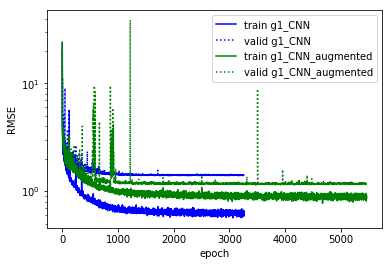

In [47]:
plot_loss([g1_model2_hist, g1_model2_augmented_hist],['g1_CNN','g1_CNN_augmented'])

The augmented data improves the validation RMSE by adding some variance to the training data.

### Add Dropout to avoid over-fitting and up the last hidden level

In [48]:
g1_model3 = Sequential()
g1_model3.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3.add(BatchNormalization())
g1_model3.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3.add(Dropout(.1))
g1_model3.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3.add(BatchNormalization())
g1_model3.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3.add(Dropout(.2))
g1_model3.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3.add(BatchNormalization())
g1_model3.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3.add(Dropout(.3))
g1_model3.add(Flatten())
g1_model3.add(Dense(500, activation = "relu"))
g1_model3.add(Dropout(.5))
g1_model3.add(BatchNormalization())
g1_model3.add(Dense(500, activation = "relu"))
g1_model3.add(BatchNormalization())
g1_model3.add(Dense(30))
print(g1_model3.summary())
g1_model3_hist, g1_model3 = fit_model(g1_model3, data1,
                                'g1_CNN_aug_dropout',datagen,
                                patience=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_13 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 64)        0         
__________

Epoch 53/10000
53/53 [==============================] - 5s 85ms/step - loss: 0.0112 - val_loss: 0.0476
Epoch 54/10000
53/53 [==============================] - 5s 85ms/step - loss: 0.0106 - val_loss: 0.0942
Epoch 55/10000
53/53 [==============================] - 5s 86ms/step - loss: 0.0105 - val_loss: 0.5926
Epoch 56/10000
53/53 [==============================] - 5s 89ms/step - loss: 0.0116 - val_loss: 0.0152
Epoch 57/10000
53/53 [==============================] - 5s 85ms/step - loss: 0.0108 - val_loss: 0.0144
Epoch 58/10000
53/53 [==============================] - 5s 87ms/step - loss: 0.0125 - val_loss: 0.0119
Epoch 59/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0120 - val_loss: 0.1215
Epoch 60/10000
53/53 [==============================] - 5s 86ms/step - loss: 0.0159 - val_loss: 0.0253
Epoch 61/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0127 - val_loss: 0.0238
Epoch 62/10000
53/53 [==============================] - 5s 86ms/step - lo

53/53 [==============================] - 5s 86ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 133/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 134/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 135/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 136/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 137/10000
53/53 [==============================] - 5s 85ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 138/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0044 - val_loss: 0.0095
Epoch 139/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 140/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 141/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.

Epoch 211/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 212/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 213/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 214/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 215/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 216/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 217/10000
53/53 [==============================] - 5s 87ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 218/10000
53/53 [==============================] - 5s 85ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 219/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 220/10000
53/53 [==============================] - 4s 84ms

53/53 [==============================] - 4s 83ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 290/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0017 - val_loss: 9.2775e-04
Epoch 291/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0017 - val_loss: 9.6808e-04
Epoch 292/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 293/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0018 - val_loss: 9.8458e-04
Epoch 294/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0017 - val_loss: 9.2537e-04
Epoch 295/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0017 - val_loss: 9.8469e-04
Epoch 296/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 297/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 298/10000
53/53 [==============================] - 4s 

53/53 [==============================] - 5s 85ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 366/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0014 - val_loss: 9.5004e-04
Epoch 367/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0015 - val_loss: 9.0748e-04
Epoch 368/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0014 - val_loss: 9.2446e-04
Epoch 369/10000
53/53 [==============================] - 5s 86ms/step - loss: 0.0014 - val_loss: 8.0172e-04
Epoch 370/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 371/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0015 - val_loss: 9.3347e-04
Epoch 372/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0015 - val_loss: 9.4668e-04
Epoch 373/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0015 - val_loss: 8.4404e-04
Epoch 374/10000
53/53 [=============================

53/53 [==============================] - 4s 82ms/step - loss: 0.0013 - val_loss: 0.0283
Epoch 443/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 444/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0014 - val_loss: 8.1496e-04
Epoch 445/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.0014 - val_loss: 8.9549e-04
Epoch 446/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0013 - val_loss: 9.1627e-04
Epoch 447/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0014 - val_loss: 9.4744e-04
Epoch 448/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 449/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0013 - val_loss: 9.1367e-04
Epoch 450/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0014 - val_loss: 0.8945
Epoch 451/10000
53/53 [==============================] - 4s 

53/53 [==============================] - 4s 81ms/step - loss: 0.0013 - val_loss: 7.8411e-04
Epoch 519/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 520/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0013 - val_loss: 7.9256e-04
Epoch 521/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0013 - val_loss: 7.5558e-04
Epoch 522/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0013 - val_loss: 7.1396e-04
Epoch 523/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.0013 - val_loss: 8.0815e-04
Epoch 524/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0013 - val_loss: 7.2517e-04
Epoch 525/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 7.1879e-04
Epoch 526/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 7.3100e-04
Epoch 527/10000
53/53 [=========================

53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 6.8978e-04
Epoch 595/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 7.1775e-04
Epoch 596/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 6.8666e-04
Epoch 597/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 6.6289e-04
Epoch 598/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 6.6086e-04
Epoch 599/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 7.5365e-04
Epoch 600/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 7.0908e-04
Epoch 601/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 8.9656e-04
Epoch 602/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 6.8938e-04
Epoch 603/10000
53/53 [=====================

53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 7.0594e-04
Epoch 671/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 6.9958e-04
Epoch 672/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 6.8866e-04
Epoch 673/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 7.4614e-04
Epoch 674/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 7.7920e-04
Epoch 675/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 676/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 7.4483e-04
Epoch 677/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 8.5423e-04
Epoch 678/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 679/10000
53/53 [=============================

53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 6.6047e-04
Epoch 747/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 2.3221
Epoch 748/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.0012 - val_loss: 7.0243e-04
Epoch 749/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 7.1525e-04
Epoch 750/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 7.2707e-04
Epoch 751/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 8.3028e-04
Epoch 752/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 7.8763e-04
Epoch 753/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 754/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 76.3576
Epoch 755/10000
53/53 [==============================] 

53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 0.0131
Epoch 824/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 6.5552e-04
Epoch 825/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 9.3666e-04
Epoch 826/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 6.8636e-04
Epoch 827/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.4095e-04
Epoch 828/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 9.1842e-04
Epoch 829/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 830/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 6.7732e-04
Epoch 831/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.7840e-04
Epoch 832/10000
53/53 [=============================

Epoch 900/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 7.1183e-04
Epoch 901/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 6.4469e-04
Epoch 902/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 7.8416e-04
Epoch 903/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.0011 - val_loss: 6.9577e-04
Epoch 904/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.0203e-04
Epoch 905/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.8396e-04
Epoch 906/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.5457e-04
Epoch 907/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.5661e-04
Epoch 908/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 7.0408e-04
Epoch 909/10000
53/53 [=====

53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 0.2442
Epoch 977/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 8.8749e-04
Epoch 978/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 6.5315e-04
Epoch 979/10000
53/53 [==============================] - 4s 81ms/step - loss: 0.0011 - val_loss: 6.5813e-04
Epoch 980/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.6971e-04
Epoch 981/10000
53/53 [==============================] - 5s 87ms/step - loss: 0.0011 - val_loss: 6.9636e-04
Epoch 982/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 7.5869e-04
Epoch 983/10000
53/53 [==============================] - 5s 85ms/step - loss: 0.0011 - val_loss: 7.5644e-04
Epoch 984/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 6.4967e-04
Epoch 985/10000
53/53 [=========================

53/53 [==============================] - 4s 82ms/step - loss: 0.0010 - val_loss: 8.1485
Epoch 1053/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 1054/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 0.0071
Epoch 1055/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 1056/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 37.8057
Epoch 1057/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 0.0084
Epoch 1058/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 1059/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 1060/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 1061/10000
53/53 [==============================] - 4s 83ms/step 

53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 6.5674e-04
Epoch 1131/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 6.2687e-04
Epoch 1132/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 6.3172e-04
Epoch 1133/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 9.3821e-04
Epoch 1134/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 0.0241
Epoch 1135/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 0.0449
Epoch 1136/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 0.0184
Epoch 1137/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 3.7864
Epoch 1138/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.0011 - val_loss: 7.0314e-04
Epoch 1139/10000
53/53 [============================

53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 6.6689e-04
Epoch 1207/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.7893e-04
Epoch 1208/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.0010 - val_loss: 7.9134e-04
Epoch 1209/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 7.9638e-04
Epoch 1210/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 8.7166e-04
Epoch 1211/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 8.4672e-04
Epoch 1212/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1213/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 1214/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 9.0462e-04
Epoch 1215/10000
53/53 [====================

Epoch 1283/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 6.5675e-04
Epoch 1284/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.5601e-04
Epoch 1285/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 6.3692e-04
Epoch 1286/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 60.1545
Epoch 1287/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 6.6430e-04
Epoch 1288/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.0011 - val_loss: 0.0250
Epoch 1289/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 0.2193
Epoch 1290/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 2.0992
Epoch 1291/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 3.8913
Epoch 1292/10000
53/53 [==============

53/53 [==============================] - 4s 82ms/step - loss: 0.0012 - val_loss: 0.1438
Epoch 1360/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 0.0069
Epoch 1361/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.6553e-04
Epoch 1362/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 6.7247e-04
Epoch 1363/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.9030e-04
Epoch 1364/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.2566e-04
Epoch 1365/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 6.5730e-04
Epoch 1366/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 6.3829e-04
Epoch 1367/10000
53/53 [==============================] - 5s 85ms/step - loss: 0.0010 - val_loss: 6.4690e-04
Epoch 1368/10000
53/53 [====================

53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 0.1652
Epoch 1435/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.3714e-04 - val_loss: 7.9688e-04
Epoch 1436/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 0.0100
Epoch 1437/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.4926e-04 - val_loss: 0.0015
Epoch 1438/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.9122e-04 - val_loss: 69.5454
Epoch 1439/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 0.4623
Epoch 1440/10000
53/53 [==============================] - 5s 85ms/step - loss: 9.5943e-04 - val_loss: 1.1933
Epoch 1441/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 0.4373
Epoch 1442/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0011 - val_loss: 6.1218
Epoch 1443/10000
53/53 [===========================

53/53 [==============================] - 5s 86ms/step - loss: 9.7843e-04 - val_loss: 0.0290
Epoch 1511/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 0.1597
Epoch 1512/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 0.4682
Epoch 1513/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 0.4197
Epoch 1514/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.8950e-04 - val_loss: 1.2991
Epoch 1515/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 0.1077
Epoch 1516/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.7533e-04 - val_loss: 0.3798
Epoch 1517/10000
53/53 [==============================] - 5s 85ms/step - loss: 0.0010 - val_loss: 1.0423
Epoch 1518/10000
53/53 [==============================] - 5s 85ms/step - loss: 0.0010 - val_loss: 1.3520
Epoch 1519/10000
53/53 [==============================] - 4s

53/53 [==============================] - 4s 83ms/step - loss: 9.9786e-04 - val_loss: 0.0011
Epoch 1586/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.5290e-04 - val_loss: 6.2395e-04
Epoch 1587/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.7791e-04 - val_loss: 0.0079
Epoch 1588/10000
53/53 [==============================] - 5s 86ms/step - loss: 9.3285e-04 - val_loss: 6.0238e-04
Epoch 1589/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0011 - val_loss: 6.2404e-04
Epoch 1590/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.7666e-04 - val_loss: 6.6042e-04
Epoch 1591/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.6587e-04 - val_loss: 6.1048e-04
Epoch 1592/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.8949e-04 - val_loss: 6.2075e-04
Epoch 1593/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 6.2438e-04
Epoch 1594/10000

Epoch 1659/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0010 - val_loss: 6.2203e-04
Epoch 1660/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 2.6249
Epoch 1661/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 6.2494e-04
Epoch 1662/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.7462e-04 - val_loss: 5.8453e-04
Epoch 1663/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.4950e-04 - val_loss: 5.6966e-04
Epoch 1664/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.9135e-04 - val_loss: 7.2110e-04
Epoch 1665/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.7713e-04 - val_loss: 6.1652e-04
Epoch 1666/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.5276e-04 - val_loss: 6.4634e-04
Epoch 1667/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.4517e-04 - val_loss: 5.9770e-04

53/53 [==============================] - 4s 82ms/step - loss: 0.0011 - val_loss: 6.4959e-04
Epoch 1734/10000
53/53 [==============================] - 4s 85ms/step - loss: 0.0011 - val_loss: 6.2576e-04
Epoch 1735/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 6.7888e-04
Epoch 1736/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.8742e-04 - val_loss: 6.2018e-04
Epoch 1737/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.9005e-04 - val_loss: 5.9855e-04
Epoch 1738/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0010 - val_loss: 6.4980e-04
Epoch 1739/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 6.1508e-04
Epoch 1740/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 6.2516e-04
Epoch 1741/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.7591e-04 - val_loss: 6.4654e-04
Epoch 1742/10000
53/53 [

53/53 [==============================] - 4s 82ms/step - loss: 9.9312e-04 - val_loss: 6.4488e-04
Epoch 1807/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.5261e-04 - val_loss: 6.2130e-04
Epoch 1808/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.2059e-04 - val_loss: 7.0402e-04
Epoch 1809/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.2711e-04 - val_loss: 6.1703e-04
Epoch 1810/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.8999e-04 - val_loss: 6.0177e-04
Epoch 1811/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.6931e-04 - val_loss: 5.9469e-04
Epoch 1812/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.9586e-04 - val_loss: 6.4704e-04
Epoch 1813/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.3677e-04 - val_loss: 6.0388e-04
Epoch 1814/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.7755e-04 - val_loss: 5.9650e-04


53/53 [==============================] - 4s 84ms/step - loss: 9.1282e-04 - val_loss: 5.7275e-04
Epoch 1880/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.6044e-04 - val_loss: 5.8535e-04
Epoch 1881/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.0207e-04 - val_loss: 5.9829e-04
Epoch 1882/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.3874e-04 - val_loss: 6.0013e-04
Epoch 1883/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 6.1753e-04
Epoch 1884/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.3205e-04 - val_loss: 6.1218e-04
Epoch 1885/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.3246e-04 - val_loss: 6.6016e-04
Epoch 1886/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.2083e-04 - val_loss: 6.2183e-04
Epoch 1887/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.4925e-04 - val_loss: 6.2454e-04
Epoc

53/53 [==============================] - 4s 84ms/step - loss: 9.6615e-04 - val_loss: 6.1598e-04
Epoch 1953/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.4898e-04 - val_loss: 0.0083
Epoch 1954/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 6.5790e-04
Epoch 1955/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 6.4771e-04
Epoch 1956/10000
53/53 [==============================] - 4s 82ms/step - loss: 0.0010 - val_loss: 5.9489e-04
Epoch 1957/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.7829e-04 - val_loss: 6.2005e-04
Epoch 1958/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.5665e-04 - val_loss: 5.8140e-04
Epoch 1959/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.7315e-04 - val_loss: 1778.9914
Epoch 1960/10000
53/53 [==============================] - 4s 83ms/step - loss: 0.0010 - val_loss: 5.7450
Epoch 1961/10000
53/53 [=

53/53 [==============================] - 4s 83ms/step - loss: 9.8257e-04 - val_loss: 7.3711e-04
Epoch 2026/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 6.0492e-04
Epoch 2027/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.5442e-04 - val_loss: 6.2547e-04
Epoch 2028/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.0029e-04 - val_loss: 5.9921e-04
Epoch 2029/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.5026e-04 - val_loss: 6.2538e-04
Epoch 2030/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.2580e-04 - val_loss: 6.4511e-04
Epoch 2031/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.5163e-04 - val_loss: 5.9915e-04
Epoch 2032/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.7723e-04 - val_loss: 6.7413e-04
Epoch 2033/10000
53/53 [==============================] - 5s 85ms/step - loss: 9.9821e-04 - val_loss: 6.2291e-04
Epoc

Epoch 2098/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7997e-04 - val_loss: 6.4233e-04
Epoch 2099/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.5416e-04 - val_loss: 5.8720e-04
Epoch 2100/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.3526e-04 - val_loss: 5.8138e-04
Epoch 2101/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.8024e-04 - val_loss: 5.9077e-04
Epoch 2102/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.1353e-04 - val_loss: 5.9253e-04
Epoch 2103/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.3957e-04 - val_loss: 5.9622e-04
Epoch 2104/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.4740e-04 - val_loss: 5.6825e-04
Epoch 2105/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.6348e-04 - val_loss: 5.7505e-04
Epoch 2106/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.1548e-04 - val_

Epoch 2171/10000
53/53 [==============================] - 5s 86ms/step - loss: 8.9425e-04 - val_loss: 5.7370e-04
Epoch 2172/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.2907e-04 - val_loss: 6.1244e-04
Epoch 2173/10000
53/53 [==============================] - 4s 81ms/step - loss: 9.2316e-04 - val_loss: 5.6877e-04
Epoch 2174/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.7421e-04 - val_loss: 5.9432e-04
Epoch 2175/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.6859e-04 - val_loss: 6.4044e-04
Epoch 2176/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.2621e-04 - val_loss: 6.2008e-04
Epoch 2177/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.8765e-04 - val_loss: 6.3927e-04
Epoch 2178/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.6597e-04 - val_loss: 6.2232e-04
Epoch 2179/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.6339e-04 - val_

53/53 [==============================] - 4s 85ms/step - loss: 9.1532e-04 - val_loss: 5.9030e-04
Epoch 2244/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.4640e-04 - val_loss: 6.1126e-04
Epoch 2245/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.4035e-04 - val_loss: 5.7312e-04
Epoch 2246/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.1395e-04 - val_loss: 6.1566e-04
Epoch 2247/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.0458e-04 - val_loss: 6.0105e-04
Epoch 2248/10000
53/53 [==============================] - 5s 86ms/step - loss: 9.5825e-04 - val_loss: 6.3091e-04
Epoch 2249/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.3375e-04 - val_loss: 5.8749e-04
Epoch 2250/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.2873e-04 - val_loss: 6.2584e-04
Epoch 2251/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.1171e-04 - val_loss: 6.2761e-04


Epoch 2316/10000
53/53 [==============================] - 5s 85ms/step - loss: 9.1392e-04 - val_loss: 6.7564e-04
Epoch 2317/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9175e-04 - val_loss: 5.9411e-04
Epoch 2318/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.7089e-04 - val_loss: 3.7469
Epoch 2319/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.0852e-04 - val_loss: 6.3449e-04
Epoch 2320/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.8449e-04 - val_loss: 6.0373e-04
Epoch 2321/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.4757e-04 - val_loss: 5.9555e-04
Epoch 2322/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.4409e-04 - val_loss: 7.2442e-04
Epoch 2323/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.5167e-04 - val_loss: 6.1899e-04
Epoch 2324/10000
53/53 [==============================] - 5s 85ms/step - loss: 9.0201e-04 - val_loss

53/53 [==============================] - 4s 82ms/step - loss: 8.9030e-04 - val_loss: 6.4063e-04
Epoch 2389/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.3111e-04 - val_loss: 5.8196e-04
Epoch 2390/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9808e-04 - val_loss: 5.9232e-04
Epoch 2391/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.8444e-04 - val_loss: 5.7559e-04
Epoch 2392/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.0895e-04 - val_loss: 6.8139e-04
Epoch 2393/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.3393e-04 - val_loss: 6.5977e-04
Epoch 2394/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.9916e-04 - val_loss: 5.8785e-04
Epoch 2395/10000
53/53 [==============================] - 5s 85ms/step - loss: 8.9730e-04 - val_loss: 5.7826e-04
Epoch 2396/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7811e-04 - val_loss: 5.9795e-04


53/53 [==============================] - 5s 85ms/step - loss: 9.0938e-04 - val_loss: 5.9391e-04
Epoch 2461/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.1571e-04 - val_loss: 5.7777e-04
Epoch 2462/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.1596e-04 - val_loss: 5.7985e-04
Epoch 2463/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7723e-04 - val_loss: 5.9209e-04
Epoch 2464/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.8668e-04 - val_loss: 5.8901e-04
Epoch 2465/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.2046e-04 - val_loss: 6.1802e-04
Epoch 2466/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.9783e-04 - val_loss: 6.1723e-04
Epoch 2467/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.8001e-04 - val_loss: 1.8126
Epoch 2468/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.3403e-04 - val_loss: 5.7284e-04
Epoc

53/53 [==============================] - 4s 83ms/step - loss: 9.3908e-04 - val_loss: 5.7857e-04
Epoch 2534/10000
53/53 [==============================] - 4s 85ms/step - loss: 9.0428e-04 - val_loss: 6.2150e-04
Epoch 2535/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.3015e-04 - val_loss: 0.0031
Epoch 2536/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.9059e-04 - val_loss: 0.2077
Epoch 2537/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.8275e-04 - val_loss: 1.2277
Epoch 2538/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.7748e-04 - val_loss: 0.9019
Epoch 2539/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.1159e-04 - val_loss: 0.0252
Epoch 2540/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.6418e-04 - val_loss: 7.7630e-04
Epoch 2541/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.3977e-04 - val_loss: 6.4819e-04
Epoch 2542/10000
53/

53/53 [==============================] - 4s 83ms/step - loss: 9.1702e-04 - val_loss: 5.8163e-04
Epoch 2607/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.5733e-04 - val_loss: 5.8032e-04
Epoch 2608/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9253e-04 - val_loss: 5.8465e-04
Epoch 2609/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.8343e-04 - val_loss: 6.0732e-04
Epoch 2610/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.9677e-04 - val_loss: 6.0506e-04
Epoch 2611/10000
53/53 [==============================] - 5s 85ms/step - loss: 9.5495e-04 - val_loss: 6.0465e-04
Epoch 2612/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.7831e-04 - val_loss: 6.1304e-04
Epoch 2613/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.1133e-04 - val_loss: 5.6500e-04
Epoch 2614/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.0449e-04 - val_loss: 5.7699e-04


Epoch 2679/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.0788e-04 - val_loss: 5.7341e-04
Epoch 2680/10000
53/53 [==============================] - 5s 85ms/step - loss: 8.6438e-04 - val_loss: 6.3098e-04
Epoch 2681/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.1484e-04 - val_loss: 5.4322e-04
Epoch 2682/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.9209e-04 - val_loss: 5.4905e-04
Epoch 2683/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.8013e-04 - val_loss: 5.7091e-04
Epoch 2684/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.0580e-04 - val_loss: 6.0235e-04
Epoch 2685/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.3226e-04 - val_loss: 5.5635e-04
Epoch 2686/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7174e-04 - val_loss: 6.0489e-04
Epoch 2687/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7521e-04 - val_

Epoch 2752/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.6941e-04 - val_loss: 0.0041
Epoch 2753/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.0763e-04 - val_loss: 0.0029
Epoch 2754/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.6408e-04 - val_loss: 0.0767
Epoch 2755/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.0368e-04 - val_loss: 0.0284
Epoch 2756/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.1834e-04 - val_loss: 0.2004
Epoch 2757/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.0204e-04 - val_loss: 1.1047
Epoch 2758/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.8892e-04 - val_loss: 5.8920e-04
Epoch 2759/10000
53/53 [==============================] - 4s 81ms/step - loss: 8.9561e-04 - val_loss: 0.6121
Epoch 2760/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.9481e-04 - val_loss: 3.5405
Epoch 2761/1000

53/53 [==============================] - 4s 83ms/step - loss: 8.8538e-04 - val_loss: 0.0010
Epoch 2826/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9065e-04 - val_loss: 5.7292e-04
Epoch 2827/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.2942e-04 - val_loss: 5.8906e-04
Epoch 2828/10000
53/53 [==============================] - 5s 86ms/step - loss: 8.6685e-04 - val_loss: 5.8207e-04
Epoch 2829/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.7375e-04 - val_loss: 5.9359e-04
Epoch 2830/10000
53/53 [==============================] - 5s 85ms/step - loss: 9.1843e-04 - val_loss: 0.1766
Epoch 2831/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.1617e-04 - val_loss: 6.0938e-04
Epoch 2832/10000
53/53 [==============================] - 5s 85ms/step - loss: 9.0333e-04 - val_loss: 6.0101e-04
Epoch 2833/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.9586e-04 - val_loss: 5.6485e-04
Epoch 28

53/53 [==============================] - 4s 83ms/step - loss: 8.8510e-04 - val_loss: 5.7606e-04
Epoch 2899/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.2376e-04 - val_loss: 5.7762e-04
Epoch 2900/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.0076e-04 - val_loss: 5.9947e-04
Epoch 2901/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.3356e-04 - val_loss: 5.8392e-04
Epoch 2902/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.3201e-04 - val_loss: 5.8091e-04
Epoch 2903/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.4689e-04 - val_loss: 5.6783e-04
Epoch 2904/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.0255e-04 - val_loss: 5.9817e-04
Epoch 2905/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.6014e-04 - val_loss: 5.6959e-04
Epoch 2906/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.4978e-04 - val_loss: 5.7428e-04


53/53 [==============================] - 4s 82ms/step - loss: 9.1481e-04 - val_loss: 0.0010
Epoch 2971/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.5985e-04 - val_loss: 5.8977e-04
Epoch 2972/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.4168e-04 - val_loss: 6.4870e-04
Epoch 2973/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7836e-04 - val_loss: 0.0019
Epoch 2974/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.3907e-04 - val_loss: 6.6038e-04
Epoch 2975/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.2938e-04 - val_loss: 7.0848e-04
Epoch 2976/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.5555e-04 - val_loss: 5.9479e-04
Epoch 2977/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.2064e-04 - val_loss: 6.0064e-04
Epoch 2978/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.9908e-04 - val_loss: 5.9003e-04
Epoch 29

Epoch 3043/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.6006e-04 - val_loss: 6.3089e-04
Epoch 3044/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.2802e-04 - val_loss: 6.0952e-04
Epoch 3045/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.1876e-04 - val_loss: 6.2468e-04
Epoch 3046/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7074e-04 - val_loss: 5.5940e-04
Epoch 3047/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.7730e-04 - val_loss: 6.0524e-04
Epoch 3048/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.5687e-04 - val_loss: 6.0266e-04
Epoch 3049/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.8377e-04 - val_loss: 5.8979e-04
Epoch 3050/10000
53/53 [==============================] - 5s 85ms/step - loss: 9.4253e-04 - val_loss: 5.3472e-04
Epoch 3051/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.5444e-04 - val_

53/53 [==============================] - 4s 83ms/step - loss: 8.9266e-04 - val_loss: 6.5671e-04
Epoch 3116/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.5958e-04 - val_loss: 5.9972e-04
Epoch 3117/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9580e-04 - val_loss: 6.2118e-04
Epoch 3118/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.1906e-04 - val_loss: 7.2909e-04
Epoch 3119/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.9597e-04 - val_loss: 5.6729e-04
Epoch 3120/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.4610e-04 - val_loss: 5.6558e-04
Epoch 3121/10000
53/53 [==============================] - 5s 86ms/step - loss: 8.4529e-04 - val_loss: 5.7798e-04
Epoch 3122/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.1249e-04 - val_loss: 5.9112e-04
Epoch 3123/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.9012e-04 - val_loss: 5.6255e-04


53/53 [==============================] - 4s 83ms/step - loss: 9.0063e-04 - val_loss: 6.1926e-04
Epoch 3188/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9371e-04 - val_loss: 6.5839e-04
Epoch 3189/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9690e-04 - val_loss: 5.7160e-04
Epoch 3190/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.0123e-04 - val_loss: 5.8247e-04
Epoch 3191/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7250e-04 - val_loss: 5.8709e-04
Epoch 3192/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.2425e-04 - val_loss: 6.1997e-04
Epoch 3193/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.1389e-04 - val_loss: 5.9248e-04
Epoch 3194/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.8031e-04 - val_loss: 5.6976e-04
Epoch 3195/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9881e-04 - val_loss: 6.0545e-04


Epoch 3260/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.9874e-04 - val_loss: 9.9647e-04
Epoch 3261/10000
53/53 [==============================] - 5s 86ms/step - loss: 8.6749e-04 - val_loss: 5.7736e-04
Epoch 3262/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.4992e-04 - val_loss: 5.9020e-04
Epoch 3263/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7685e-04 - val_loss: 3.5528
Epoch 3264/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.3720e-04 - val_loss: 1.4057
Epoch 3265/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.4080e-04 - val_loss: 0.3114
Epoch 3266/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7285e-04 - val_loss: 5.3956e-04
Epoch 3267/10000
53/53 [==============================] - 4s 81ms/step - loss: 8.7669e-04 - val_loss: 5.9419e-04
Epoch 3268/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.5643e-04 - val_loss: 5.8209

53/53 [==============================] - 4s 82ms/step - loss: 8.6650e-04 - val_loss: 5.6889e-04
Epoch 3333/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.8430e-04 - val_loss: 6.0324e-04
Epoch 3334/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.4111e-04 - val_loss: 6.1443e-04
Epoch 3335/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.8748e-04 - val_loss: 5.6320e-04
Epoch 3336/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.8428e-04 - val_loss: 5.8057e-04
Epoch 3337/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.8253e-04 - val_loss: 6.0788e-04
Epoch 3338/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.5614e-04 - val_loss: 5.4369e-04
Epoch 3339/10000
53/53 [==============================] - 5s 85ms/step - loss: 9.1016e-04 - val_loss: 5.9511e-04
Epoch 3340/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.5124e-04 - val_loss: 6.1076e-04


53/53 [==============================] - 4s 84ms/step - loss: 8.4705e-04 - val_loss: 5.7019e-04
Epoch 3405/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.2896e-04 - val_loss: 5.6902e-04
Epoch 3406/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.2976e-04 - val_loss: 5.9314e-04
Epoch 3407/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.4132e-04 - val_loss: 5.9939e-04
Epoch 3408/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.3354e-04 - val_loss: 6.4334e-04
Epoch 3409/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.1577e-04 - val_loss: 5.8350e-04
Epoch 3410/10000
53/53 [==============================] - 5s 86ms/step - loss: 8.9135e-04 - val_loss: 6.0677e-04
Epoch 3411/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.6829e-04 - val_loss: 5.9809e-04
Epoch 3412/10000
53/53 [==============================] - 5s 86ms/step - loss: 8.5565e-04 - val_loss: 5.8980e-04


Epoch 3477/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9760e-04 - val_loss: 5.9227e-04
Epoch 3478/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.2357e-04 - val_loss: 5.6460e-04
Epoch 3479/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.3786e-04 - val_loss: 6.1735e-04
Epoch 3480/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.6095e-04 - val_loss: 5.6583e-04
Epoch 3481/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.6474e-04 - val_loss: 5.5972e-04
Epoch 3482/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.3659e-04 - val_loss: 5.6382e-04
Epoch 3483/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.3769e-04 - val_loss: 6.4231e-04
Epoch 3484/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9652e-04 - val_loss: 6.1806e-04
Epoch 3485/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.8393e-04 - val_

53/53 [==============================] - 4s 84ms/step - loss: 8.2856e-04 - val_loss: 5.6380e-04
Epoch 3550/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.2873e-04 - val_loss: 5.9287e-04
Epoch 3551/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.8971e-04 - val_loss: 6.0856e-04
Epoch 3552/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.6642e-04 - val_loss: 6.0527e-04
Epoch 3553/10000
53/53 [==============================] - 4s 82ms/step - loss: 9.2109e-04 - val_loss: 6.2084e-04
Epoch 3554/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.9449e-04 - val_loss: 6.2697e-04
Epoch 3555/10000
53/53 [==============================] - 5s 87ms/step - loss: 8.9312e-04 - val_loss: 6.0142e-04
Epoch 3556/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.5992e-04 - val_loss: 5.6388e-04
Epoch 3557/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.1973e-04 - val_loss: 5.7239e-04


53/53 [==============================] - 4s 84ms/step - loss: 8.5757e-04 - val_loss: 5.9375e-04
Epoch 3622/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9161e-04 - val_loss: 6.1217e-04
Epoch 3623/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.4967e-04 - val_loss: 5.7411e-04
Epoch 3624/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.9784e-04 - val_loss: 5.5780e-04
Epoch 3625/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.4852e-04 - val_loss: 6.7060e-04
Epoch 3626/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.8030e-04 - val_loss: 5.6788e-04
Epoch 3627/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9012e-04 - val_loss: 5.8585e-04
Epoch 3628/10000
53/53 [==============================] - 5s 86ms/step - loss: 8.6222e-04 - val_loss: 5.9512e-04
Epoch 3629/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.6215e-04 - val_loss: 5.9150e-04


53/53 [==============================] - 4s 83ms/step - loss: 8.7793e-04 - val_loss: 5.5684e-04
Epoch 3694/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.5420e-04 - val_loss: 5.5416e-04
Epoch 3695/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.5292e-04 - val_loss: 5.5880e-04
Epoch 3696/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.5455e-04 - val_loss: 5.9367e-04
Epoch 3697/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.3048e-04 - val_loss: 5.6917e-04
Epoch 3698/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.3039e-04 - val_loss: 5.9435e-04
Epoch 3699/10000
53/53 [==============================] - 5s 85ms/step - loss: 8.2714e-04 - val_loss: 5.5545e-04
Epoch 3700/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.1497e-04 - val_loss: 5.8177e-04
Epoch 3701/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.0549e-04 - val_loss: 6.2162e-04


53/53 [==============================] - 4s 84ms/step - loss: 8.3795e-04 - val_loss: 5.5797e-04
Epoch 3766/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.2803e-04 - val_loss: 5.9250e-04
Epoch 3767/10000
53/53 [==============================] - 5s 88ms/step - loss: 8.1813e-04 - val_loss: 5.7848e-04
Epoch 3768/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.1548e-04 - val_loss: 5.6803e-04
Epoch 3769/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7727e-04 - val_loss: 5.7509e-04
Epoch 3770/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.6821e-04 - val_loss: 6.0675e-04
Epoch 3771/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.6451e-04 - val_loss: 6.1423e-04
Epoch 3772/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.6910e-04 - val_loss: 5.6150e-04
Epoch 3773/10000
53/53 [==============================] - 4s 84ms/step - loss: 9.1672e-04 - val_loss: 5.8791e-04


53/53 [==============================] - 4s 84ms/step - loss: 8.2660e-04 - val_loss: 5.9070e-04
Epoch 3838/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7062e-04 - val_loss: 6.0713e-04
Epoch 3839/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.6906e-04 - val_loss: 5.4979e-04
Epoch 3840/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.8384e-04 - val_loss: 5.3505e-04
Epoch 3841/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.4340e-04 - val_loss: 5.8106e-04
Epoch 3842/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.6899e-04 - val_loss: 5.9450e-04
Epoch 3843/10000
53/53 [==============================] - 5s 86ms/step - loss: 8.7985e-04 - val_loss: 6.0407e-04
Epoch 3844/10000
53/53 [==============================] - 4s 82ms/step - loss: 8.5418e-04 - val_loss: 5.9394e-04
Epoch 3845/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.4598e-04 - val_loss: 5.7314e-04


Epoch 3910/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.4159e-04 - val_loss: 5.3822e-04
Epoch 3911/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.6521e-04 - val_loss: 5.7527e-04
Epoch 3912/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.6354e-04 - val_loss: 6.3840e-04
Epoch 3913/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.5224e-04 - val_loss: 5.5917e-04
Epoch 3914/10000
53/53 [==============================] - 5s 85ms/step - loss: 8.8225e-04 - val_loss: 6.0420e-04
Epoch 3915/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.9766e-04 - val_loss: 5.6566e-04
Epoch 3916/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7142e-04 - val_loss: 5.8559e-04
Epoch 3917/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.1265e-04 - val_loss: 5.6830e-04
Epoch 3918/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.8292e-04 - val_

53/53 [==============================] - 5s 87ms/step - loss: 8.4057e-04 - val_loss: 6.0028e-04
Epoch 3983/10000
53/53 [==============================] - 5s 85ms/step - loss: 7.8983e-04 - val_loss: 5.8486e-04
Epoch 3984/10000
53/53 [==============================] - 4s 85ms/step - loss: 8.0645e-04 - val_loss: 6.1676e-04
Epoch 3985/10000
53/53 [==============================] - 4s 84ms/step - loss: 0.0010 - val_loss: 5.9325e-04
Epoch 3986/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.9305e-04 - val_loss: 6.0827e-04
Epoch 3987/10000
53/53 [==============================] - 4s 83ms/step - loss: 8.7554e-04 - val_loss: 5.9414e-04
Epoch 3988/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.0026e-04 - val_loss: 5.8251e-04
Epoch 3989/10000
53/53 [==============================] - 4s 84ms/step - loss: 8.7375e-04 - val_loss: 5.5320e-04
Epoch 3990/10000
53/53 [==============================] - 4s 83ms/step - loss: 9.3444e-04 - val_loss: 6.0353e-04
Epoc

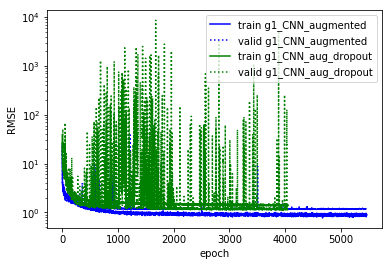

In [49]:
plot_loss([g1_model2_augmented_hist, g1_model3_hist],['g1_CNN_augmented','g1_CNN_aug_dropout'])

## Models for group2 dataset (images with 8 or less keypoints)

### 1 Dense Hidden Layer with 100 units

In [50]:
g2_model1 = Sequential()
g2_model1.add(Flatten(input_shape=INPUT_SHAPE))
g2_model1.add(Dense(100, activation='relu'))
g2_model1.add(Dense(8))
print(g2_model1.summary())
g2_model1_hist, g2_model1 = fit_model(g2_model1, data2, 'g2_1dense100neuronlayer')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               921700    
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 808       
Total params: 922,508
Trainable params: 922,508
Non-trainable params: 0
_________________________________________________________________
None
10000
Train on 3757 samples, validate on 940 samples
Epoch 1/10000
3757/3757 [==============================] - 2s 557us/step - loss: 31.6177 - val_loss: 2.2908
Epoch 2/10000
3757/3757 [==============================] - 1s 360us/step - loss: 12.6323 - val_loss: 11.2187
Epoch 3/10000
3757/3757 [==============================] - 1s 354us/step - loss: 6.4823 - val_loss: 0.9540
Epoch 4/10000
3757

3757/3757 [==============================] - 1s 367us/step - loss: 0.0029 - val_loss: 0.0065
Epoch 70/10000
3757/3757 [==============================] - 1s 369us/step - loss: 0.0031 - val_loss: 0.0063
Epoch 71/10000
3757/3757 [==============================] - 1s 352us/step - loss: 0.0027 - val_loss: 0.0062
Epoch 72/10000
3757/3757 [==============================] - 1s 359us/step - loss: 0.0023 - val_loss: 0.0058
Epoch 73/10000
3757/3757 [==============================] - 1s 387us/step - loss: 0.0021 - val_loss: 0.0052
Epoch 74/10000
3757/3757 [==============================] - 1s 374us/step - loss: 0.0020 - val_loss: 0.0063
Epoch 75/10000
3757/3757 [==============================] - 1s 372us/step - loss: 0.0023 - val_loss: 0.0059
Epoch 76/10000
3757/3757 [==============================] - 1s 385us/step - loss: 0.0022 - val_loss: 0.0057
Epoch 77/10000
3757/3757 [==============================] - 1s 353us/step - loss: 0.0026 - val_loss: 0.0051
Epoch 78/10000
3757/3757 [=================

3757/3757 [==============================] - 1s 381us/step - loss: 0.0062 - val_loss: 0.0077
Epoch 145/10000
3757/3757 [==============================] - 1s 377us/step - loss: 0.0058 - val_loss: 0.0065
Epoch 146/10000
3757/3757 [==============================] - 1s 370us/step - loss: 0.0058 - val_loss: 0.0193
Epoch 147/10000
3757/3757 [==============================] - 1s 378us/step - loss: 0.0075 - val_loss: 0.0061
Epoch 148/10000
3757/3757 [==============================] - 1s 356us/step - loss: 0.0057 - val_loss: 0.0122
Epoch 149/10000
3757/3757 [==============================] - 1s 340us/step - loss: 0.0126 - val_loss: 0.0062
Epoch 150/10000
3757/3757 [==============================] - 1s 362us/step - loss: 0.0042 - val_loss: 0.0057
Epoch 151/10000
3757/3757 [==============================] - 1s 393us/step - loss: 0.0047 - val_loss: 0.0168
Epoch 152/10000
3757/3757 [==============================] - 1s 352us/step - loss: 0.0051 - val_loss: 0.0051
Epoch 153/10000
3757/3757 [========

3757/3757 [==============================] - 1s 373us/step - loss: 0.0527 - val_loss: 0.0419
Epoch 220/10000
3757/3757 [==============================] - 1s 352us/step - loss: 0.0107 - val_loss: 0.0092
Epoch 221/10000
3757/3757 [==============================] - 1s 366us/step - loss: 0.0125 - val_loss: 0.0852
Epoch 222/10000
3757/3757 [==============================] - 1s 342us/step - loss: 0.2716 - val_loss: 0.0071
Epoch 223/10000
3757/3757 [==============================] - 1s 375us/step - loss: 0.0057 - val_loss: 0.0059
Epoch 224/10000
3757/3757 [==============================] - 1s 372us/step - loss: 0.0049 - val_loss: 0.0055
Epoch 225/10000
3757/3757 [==============================] - 1s 351us/step - loss: 0.0046 - val_loss: 0.0058
Epoch 226/10000
3757/3757 [==============================] - 1s 385us/step - loss: 0.0043 - val_loss: 0.0051
Epoch 227/10000
3757/3757 [==============================] - 1s 366us/step - loss: 0.0041 - val_loss: 0.0055
Epoch 228/10000
3757/3757 [========

3757/3757 [==============================] - 1s 350us/step - loss: 0.0016 - val_loss: 0.0044
Epoch 295/10000
3757/3757 [==============================] - 1s 368us/step - loss: 0.0015 - val_loss: 0.0046
Epoch 296/10000
3757/3757 [==============================] - 1s 347us/step - loss: 0.0015 - val_loss: 0.0046
Epoch 297/10000
3757/3757 [==============================] - 1s 337us/step - loss: 0.0015 - val_loss: 0.0044
Epoch 298/10000
3757/3757 [==============================] - 1s 368us/step - loss: 0.0016 - val_loss: 0.0044
Epoch 299/10000
3757/3757 [==============================] - 1s 369us/step - loss: 0.0016 - val_loss: 0.0048
Epoch 300/10000
3757/3757 [==============================] - 1s 359us/step - loss: 0.0017 - val_loss: 0.0048
Epoch 301/10000
3757/3757 [==============================] - 1s 347us/step - loss: 0.0016 - val_loss: 0.0046
Epoch 302/10000
3757/3757 [==============================] - 1s 372us/step - loss: 0.0016 - val_loss: 0.0043
Epoch 303/10000
3757/3757 [========

3757/3757 [==============================] - 1s 370us/step - loss: 0.0030 - val_loss: 0.0090
Epoch 370/10000
3757/3757 [==============================] - 1s 369us/step - loss: 0.0024 - val_loss: 0.0046
Epoch 371/10000
3757/3757 [==============================] - 1s 349us/step - loss: 0.0021 - val_loss: 0.0047
Epoch 372/10000
3757/3757 [==============================] - 1s 355us/step - loss: 0.0020 - val_loss: 0.0049
Epoch 373/10000
3757/3757 [==============================] - 1s 352us/step - loss: 0.0021 - val_loss: 0.0052
Epoch 374/10000
3757/3757 [==============================] - 1s 367us/step - loss: 0.0020 - val_loss: 0.0059
Epoch 375/10000
3757/3757 [==============================] - 1s 365us/step - loss: 0.0019 - val_loss: 0.0049
Epoch 376/10000
3757/3757 [==============================] - 1s 320us/step - loss: 0.0019 - val_loss: 0.0044
Epoch 377/10000
3757/3757 [==============================] - 1s 372us/step - loss: 0.0021 - val_loss: 0.0042
Epoch 378/10000
3757/3757 [========

3757/3757 [==============================] - 2s 403us/step - loss: 0.0034 - val_loss: 0.0058
Epoch 445/10000
3757/3757 [==============================] - 1s 383us/step - loss: 0.0033 - val_loss: 0.0054
Epoch 446/10000
3757/3757 [==============================] - 1s 387us/step - loss: 0.0031 - val_loss: 0.0066
Epoch 447/10000
3757/3757 [==============================] - 1s 366us/step - loss: 0.0033 - val_loss: 0.0061
Epoch 448/10000
3757/3757 [==============================] - 1s 381us/step - loss: 0.0033 - val_loss: 0.0050
Epoch 449/10000
3757/3757 [==============================] - 1s 376us/step - loss: 0.0028 - val_loss: 0.0057
Epoch 450/10000
3757/3757 [==============================] - 1s 370us/step - loss: 0.0029 - val_loss: 0.0087
Epoch 451/10000
3757/3757 [==============================] - 1s 363us/step - loss: 0.0028 - val_loss: 0.0066
Epoch 452/10000
3757/3757 [==============================] - 1s 371us/step - loss: 0.0028 - val_loss: 0.0052
Epoch 453/10000
3757/3757 [========

3757/3757 [==============================] - 1s 365us/step - loss: 0.0120 - val_loss: 0.0518
Epoch 520/10000
3757/3757 [==============================] - 1s 352us/step - loss: 0.0128 - val_loss: 0.0393
Epoch 521/10000
3757/3757 [==============================] - 1s 360us/step - loss: 0.0167 - val_loss: 0.0191
Epoch 522/10000
3757/3757 [==============================] - 1s 349us/step - loss: 1.1927 - val_loss: 0.4637
Epoch 523/10000
3757/3757 [==============================] - 1s 345us/step - loss: 0.0501 - val_loss: 0.0169
Epoch 524/10000
3757/3757 [==============================] - 1s 349us/step - loss: 0.0120 - val_loss: 0.0100
Epoch 525/10000
3757/3757 [==============================] - 1s 346us/step - loss: 0.0087 - val_loss: 0.0081
Epoch 526/10000
3757/3757 [==============================] - 1s 361us/step - loss: 0.0071 - val_loss: 0.0090
Epoch 527/10000
3757/3757 [==============================] - 1s 353us/step - loss: 0.0066 - val_loss: 0.0082
Epoch 528/10000
3757/3757 [========

3757/3757 [==============================] - 1s 355us/step - loss: 0.0014 - val_loss: 0.0050
Epoch 595/10000
3757/3757 [==============================] - 1s 341us/step - loss: 0.0015 - val_loss: 0.0049
Epoch 596/10000
3757/3757 [==============================] - 1s 385us/step - loss: 0.0017 - val_loss: 0.0047
Epoch 597/10000
3757/3757 [==============================] - 2s 410us/step - loss: 0.0016 - val_loss: 0.0051
Epoch 598/10000
3757/3757 [==============================] - 1s 333us/step - loss: 0.0018 - val_loss: 0.0048
Epoch 599/10000
3757/3757 [==============================] - 1s 370us/step - loss: 0.0016 - val_loss: 0.0055
Epoch 600/10000
3757/3757 [==============================] - 1s 354us/step - loss: 0.0017 - val_loss: 0.0050
Epoch 601/10000
3757/3757 [==============================] - 1s 356us/step - loss: 0.0016 - val_loss: 0.0047
Epoch 602/10000
3757/3757 [==============================] - 1s 375us/step - loss: 0.0016 - val_loss: 0.0048
Epoch 603/10000
3757/3757 [========

3757/3757 [==============================] - 1s 358us/step - loss: 0.0028 - val_loss: 0.0049
Epoch 670/10000
3757/3757 [==============================] - 1s 390us/step - loss: 0.0026 - val_loss: 0.0048
Epoch 671/10000
3757/3757 [==============================] - 1s 358us/step - loss: 0.0027 - val_loss: 0.0055
Epoch 672/10000
3757/3757 [==============================] - 1s 355us/step - loss: 0.0026 - val_loss: 0.0077
Epoch 673/10000
3757/3757 [==============================] - 1s 360us/step - loss: 0.0034 - val_loss: 0.0050
Epoch 674/10000
3757/3757 [==============================] - 1s 367us/step - loss: 0.0023 - val_loss: 0.0050
Epoch 675/10000
3757/3757 [==============================] - 1s 370us/step - loss: 0.0023 - val_loss: 0.0065
Epoch 676/10000
3757/3757 [==============================] - 1s 380us/step - loss: 0.0024 - val_loss: 0.0051
Epoch 677/10000
3757/3757 [==============================] - 1s 372us/step - loss: 0.0022 - val_loss: 0.0056
Epoch 678/10000
3757/3757 [========

3757/3757 [==============================] - 1s 378us/step - loss: 0.0097 - val_loss: 0.0083
Epoch 745/10000
3757/3757 [==============================] - 1s 379us/step - loss: 0.0064 - val_loss: 0.0073
Epoch 746/10000
3757/3757 [==============================] - 1s 383us/step - loss: 0.0076 - val_loss: 0.0081
Epoch 747/10000
3757/3757 [==============================] - 1s 374us/step - loss: 0.0079 - val_loss: 0.0075
Epoch 748/10000
3757/3757 [==============================] - 1s 367us/step - loss: 0.0063 - val_loss: 0.0086
Epoch 749/10000
3757/3757 [==============================] - 1s 362us/step - loss: 0.0070 - val_loss: 0.0066
Epoch 750/10000
3757/3757 [==============================] - 1s 377us/step - loss: 0.0064 - val_loss: 0.0079
Epoch 751/10000
3757/3757 [==============================] - 2s 409us/step - loss: 0.0134 - val_loss: 0.0192
Epoch 752/10000
3757/3757 [==============================] - 1s 339us/step - loss: 0.0064 - val_loss: 0.0076
Epoch 753/10000
3757/3757 [========

3757/3757 [==============================] - 1s 383us/step - loss: 0.0014 - val_loss: 0.0045
Epoch 820/10000
3757/3757 [==============================] - 1s 332us/step - loss: 0.0013 - val_loss: 0.0051
Epoch 821/10000
3757/3757 [==============================] - 1s 341us/step - loss: 0.0013 - val_loss: 0.0045
Epoch 822/10000
3757/3757 [==============================] - 1s 356us/step - loss: 0.0013 - val_loss: 0.0047
Epoch 823/10000
3757/3757 [==============================] - 1s 344us/step - loss: 0.0013 - val_loss: 0.0044
Epoch 824/10000
3757/3757 [==============================] - 1s 374us/step - loss: 0.0015 - val_loss: 0.0072
Epoch 825/10000
3757/3757 [==============================] - 1s 386us/step - loss: 0.0024 - val_loss: 0.0052
Epoch 826/10000
3757/3757 [==============================] - 1s 366us/step - loss: 0.0020 - val_loss: 0.0051
Epoch 827/10000
3757/3757 [==============================] - 1s 358us/step - loss: 0.0026 - val_loss: 0.0072
Epoch 828/10000
3757/3757 [========

3757/3757 [==============================] - 1s 374us/step - loss: 0.0015 - val_loss: 0.0054
Epoch 895/10000
3757/3757 [==============================] - 1s 333us/step - loss: 0.0016 - val_loss: 0.0050
Epoch 896/10000
3757/3757 [==============================] - 1s 349us/step - loss: 0.0015 - val_loss: 0.0048
Epoch 897/10000
3757/3757 [==============================] - 1s 363us/step - loss: 0.0015 - val_loss: 0.0049
Epoch 898/10000
3757/3757 [==============================] - 1s 357us/step - loss: 0.0014 - val_loss: 0.0053
Epoch 899/10000
3757/3757 [==============================] - 1s 373us/step - loss: 0.0013 - val_loss: 0.0053
Epoch 900/10000
3757/3757 [==============================] - 1s 343us/step - loss: 0.0013 - val_loss: 0.0047
Epoch 901/10000
3757/3757 [==============================] - 1s 357us/step - loss: 0.0013 - val_loss: 0.0051
Epoch 902/10000
3757/3757 [==============================] - 1s 370us/step - loss: 0.0012 - val_loss: 0.0064
Epoch 903/10000
3757/3757 [========

3757/3757 [==============================] - 1s 365us/step - loss: 0.0024 - val_loss: 0.0080
Epoch 970/10000
3757/3757 [==============================] - 2s 402us/step - loss: 0.0022 - val_loss: 0.0050
Epoch 971/10000
3757/3757 [==============================] - 1s 363us/step - loss: 0.0027 - val_loss: 0.0069
Epoch 972/10000
3757/3757 [==============================] - 1s 389us/step - loss: 0.0020 - val_loss: 0.0047
Epoch 973/10000
3757/3757 [==============================] - 1s 335us/step - loss: 0.0020 - val_loss: 0.0052
Epoch 974/10000
3757/3757 [==============================] - 1s 366us/step - loss: 0.0020 - val_loss: 0.0055
Epoch 975/10000
3757/3757 [==============================] - 1s 363us/step - loss: 0.0024 - val_loss: 0.0085
Epoch 976/10000
3757/3757 [==============================] - 1s 367us/step - loss: 0.0021 - val_loss: 0.0072
Epoch 977/10000
3757/3757 [==============================] - 1s 336us/step - loss: 0.0017 - val_loss: 0.0053
Epoch 978/10000
3757/3757 [========

Epoch 1044/10000
3757/3757 [==============================] - 1s 369us/step - loss: 0.0047 - val_loss: 0.0076
Epoch 1045/10000
3757/3757 [==============================] - 1s 338us/step - loss: 0.0042 - val_loss: 0.0066
Epoch 1046/10000
3757/3757 [==============================] - 1s 382us/step - loss: 0.0042 - val_loss: 0.0114
Epoch 1047/10000
3757/3757 [==============================] - 1s 366us/step - loss: 0.0040 - val_loss: 0.0760
Epoch 1048/10000
3757/3757 [==============================] - 1s 367us/step - loss: 0.0060 - val_loss: 0.0081
Epoch 1049/10000
3757/3757 [==============================] - 1s 381us/step - loss: 0.0035 - val_loss: 0.0073
Epoch 1050/10000
3757/3757 [==============================] - 1s 373us/step - loss: 0.0036 - val_loss: 0.0066
Epoch 1051/10000
3757/3757 [==============================] - 1s 355us/step - loss: 0.0036 - val_loss: 0.0063
Epoch 1052/10000
3757/3757 [==============================] - 1s 365us/step - loss: 0.0030 - val_loss: 0.0083
Epoch 1053

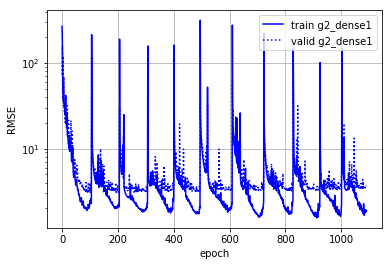

In [51]:
plot_loss([g2_model1_hist],['g2_dense1'])

### Using batch normalization

In [52]:
g2_model1BN = Sequential()
g2_model1BN.add(Flatten(input_shape=INPUT_SHAPE))
g2_model1BN.add(Dense(100, activation='relu'))
g2_model1BN.add(BatchNormalization())
g2_model1BN.add(Dense(8))
print(g2_model1BN.summary())
g2_model1BN_hist, g2_model1BN = fit_model(g2_model1BN, data2,
                                    'g2_1dense100neuronlayer_wbatchnormalization')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               921700    
_________________________________________________________________
batch_normalization_17 (Batc (None, 100)               400       
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 808       
Total params: 922,908
Trainable params: 922,708
Non-trainable params: 200
_________________________________________________________________
None
10000
Train on 3757 samples, validate on 940 samples
Epoch 1/10000
3757/3757 [==============================] - 3s 676us/step - loss: 0.3036 - val_loss: 0.0260
Epoch 2/10000
3757/3757 [==============================] - 2s 430us/step - loss: 0.0133 - val_loss: 0

3757/3757 [==============================] - 2s 407us/step - loss: 0.0027 - val_loss: 0.0054
Epoch 69/10000
3757/3757 [==============================] - 2s 441us/step - loss: 0.0024 - val_loss: 0.0068
Epoch 70/10000
3757/3757 [==============================] - 2s 414us/step - loss: 0.0025 - val_loss: 0.0054
Epoch 71/10000
3757/3757 [==============================] - 2s 404us/step - loss: 0.0025 - val_loss: 0.0051
Epoch 72/10000
3757/3757 [==============================] - 2s 421us/step - loss: 0.0026 - val_loss: 0.0053
Epoch 73/10000
3757/3757 [==============================] - 2s 416us/step - loss: 0.0025 - val_loss: 0.0062
Epoch 74/10000
3757/3757 [==============================] - 2s 411us/step - loss: 0.0026 - val_loss: 0.0109
Epoch 75/10000
3757/3757 [==============================] - 2s 432us/step - loss: 0.0030 - val_loss: 0.0067
Epoch 76/10000
3757/3757 [==============================] - 2s 416us/step - loss: 0.0025 - val_loss: 0.0067
Epoch 77/10000
3757/3757 [=================

3757/3757 [==============================] - 2s 450us/step - loss: 0.0016 - val_loss: 0.0047
Epoch 144/10000
3757/3757 [==============================] - 2s 424us/step - loss: 0.0017 - val_loss: 0.0050
Epoch 145/10000
3757/3757 [==============================] - 2s 424us/step - loss: 0.0016 - val_loss: 0.0051
Epoch 146/10000
3757/3757 [==============================] - 2s 432us/step - loss: 0.0015 - val_loss: 0.0057
Epoch 147/10000
3757/3757 [==============================] - 2s 428us/step - loss: 0.0016 - val_loss: 0.0050
Epoch 148/10000
3757/3757 [==============================] - 2s 405us/step - loss: 0.0016 - val_loss: 0.0049
Epoch 149/10000
3757/3757 [==============================] - 2s 465us/step - loss: 0.0015 - val_loss: 0.0054
Epoch 150/10000
3757/3757 [==============================] - 2s 412us/step - loss: 0.0016 - val_loss: 0.0048
Epoch 151/10000
3757/3757 [==============================] - 2s 429us/step - loss: 0.0015 - val_loss: 0.0052
Epoch 152/10000
3757/3757 [========

3757/3757 [==============================] - 2s 441us/step - loss: 0.0011 - val_loss: 0.0051
Epoch 219/10000
3757/3757 [==============================] - 2s 407us/step - loss: 0.0012 - val_loss: 0.0059
Epoch 220/10000
3757/3757 [==============================] - 2s 435us/step - loss: 0.0012 - val_loss: 0.0050
Epoch 221/10000
3757/3757 [==============================] - 2s 443us/step - loss: 0.0012 - val_loss: 0.0048
Epoch 222/10000
3757/3757 [==============================] - 2s 432us/step - loss: 0.0012 - val_loss: 0.0051
Epoch 223/10000
3757/3757 [==============================] - 2s 431us/step - loss: 0.0012 - val_loss: 0.0049
Epoch 224/10000
3757/3757 [==============================] - 1s 396us/step - loss: 0.0011 - val_loss: 0.0060
Epoch 225/10000
3757/3757 [==============================] - 2s 433us/step - loss: 0.0011 - val_loss: 0.0047
Epoch 226/10000
3757/3757 [==============================] - 2s 429us/step - loss: 0.0011 - val_loss: 0.0049
Epoch 227/10000
3757/3757 [========

3757/3757 [==============================] - 1s 350us/step - loss: 9.3532e-04 - val_loss: 0.0047
Epoch 293/10000
3757/3757 [==============================] - 1s 352us/step - loss: 9.4245e-04 - val_loss: 0.0047
Epoch 294/10000
3757/3757 [==============================] - 1s 354us/step - loss: 9.5812e-04 - val_loss: 0.0048
Epoch 295/10000
3757/3757 [==============================] - 1s 358us/step - loss: 9.4885e-04 - val_loss: 0.0061
Epoch 296/10000
3757/3757 [==============================] - 1s 352us/step - loss: 9.8600e-04 - val_loss: 0.0046
Epoch 297/10000
3757/3757 [==============================] - 1s 348us/step - loss: 9.1337e-04 - val_loss: 0.0054
Epoch 298/10000
3757/3757 [==============================] - 1s 355us/step - loss: 0.0011 - val_loss: 0.0048
Epoch 299/10000
3757/3757 [==============================] - 1s 357us/step - loss: 9.5551e-04 - val_loss: 0.0046
Epoch 300/10000
3757/3757 [==============================] - 1s 356us/step - loss: 8.8664e-04 - val_loss: 0.0047
Epo

3757/3757 [==============================] - 1s 360us/step - loss: 7.8025e-04 - val_loss: 0.0048
Epoch 365/10000
3757/3757 [==============================] - 1s 355us/step - loss: 7.6378e-04 - val_loss: 0.0047
Epoch 366/10000
3757/3757 [==============================] - 1s 350us/step - loss: 7.8629e-04 - val_loss: 0.0050
Epoch 367/10000
3757/3757 [==============================] - 1s 352us/step - loss: 7.9519e-04 - val_loss: 0.0049
Epoch 368/10000
3757/3757 [==============================] - 1s 353us/step - loss: 8.0285e-04 - val_loss: 0.0048
Epoch 369/10000
3757/3757 [==============================] - 1s 359us/step - loss: 7.8534e-04 - val_loss: 0.0047
Epoch 370/10000
3757/3757 [==============================] - 1s 347us/step - loss: 7.7415e-04 - val_loss: 0.0049
Epoch 371/10000
3757/3757 [==============================] - 1s 358us/step - loss: 8.7056e-04 - val_loss: 0.0049
Epoch 372/10000
3757/3757 [==============================] - 1s 348us/step - loss: 8.3390e-04 - val_loss: 0.0047

3757/3757 [==============================] - 1s 352us/step - loss: 6.9405e-04 - val_loss: 0.0047
Epoch 437/10000
3757/3757 [==============================] - 1s 351us/step - loss: 6.9892e-04 - val_loss: 0.0047
Epoch 438/10000
3757/3757 [==============================] - 1s 353us/step - loss: 6.9617e-04 - val_loss: 0.0047
Epoch 439/10000
3757/3757 [==============================] - 1s 355us/step - loss: 6.7048e-04 - val_loss: 0.0048
Epoch 440/10000
3757/3757 [==============================] - 1s 352us/step - loss: 6.7186e-04 - val_loss: 0.0048
Epoch 441/10000
3757/3757 [==============================] - 1s 349us/step - loss: 7.1972e-04 - val_loss: 0.0048
Epoch 442/10000
3757/3757 [==============================] - 1s 345us/step - loss: 7.2171e-04 - val_loss: 0.0048
Epoch 443/10000
3757/3757 [==============================] - 1s 354us/step - loss: 6.9452e-04 - val_loss: 0.0047
Epoch 444/10000
3757/3757 [==============================] - 1s 351us/step - loss: 6.8495e-04 - val_loss: 0.0047

3757/3757 [==============================] - 1s 350us/step - loss: 6.0221e-04 - val_loss: 0.0046
Epoch 509/10000
3757/3757 [==============================] - 1s 356us/step - loss: 6.4175e-04 - val_loss: 0.0047
Epoch 510/10000
3757/3757 [==============================] - 1s 349us/step - loss: 6.0539e-04 - val_loss: 0.0047
Epoch 511/10000
3757/3757 [==============================] - 1s 357us/step - loss: 6.5819e-04 - val_loss: 0.0046
Epoch 512/10000
3757/3757 [==============================] - 1s 352us/step - loss: 6.2863e-04 - val_loss: 0.0046
Epoch 513/10000
3757/3757 [==============================] - 1s 354us/step - loss: 5.9560e-04 - val_loss: 0.0047
Epoch 514/10000
3757/3757 [==============================] - 1s 349us/step - loss: 6.3558e-04 - val_loss: 0.0048
Epoch 515/10000
3757/3757 [==============================] - 1s 358us/step - loss: 6.2822e-04 - val_loss: 0.0046
Epoch 516/10000
3757/3757 [==============================] - 1s 351us/step - loss: 6.1855e-04 - val_loss: 0.0046

3757/3757 [==============================] - 1s 347us/step - loss: 5.5772e-04 - val_loss: 0.0047
Epoch 581/10000
3757/3757 [==============================] - 1s 356us/step - loss: 5.5775e-04 - val_loss: 0.0047
Epoch 582/10000
3757/3757 [==============================] - 1s 351us/step - loss: 5.7537e-04 - val_loss: 0.0046
Epoch 583/10000
3757/3757 [==============================] - 1s 347us/step - loss: 5.7607e-04 - val_loss: 0.0046
Epoch 584/10000
3757/3757 [==============================] - 1s 351us/step - loss: 6.0487e-04 - val_loss: 0.0047
Epoch 585/10000
3757/3757 [==============================] - 1s 350us/step - loss: 5.8416e-04 - val_loss: 0.0045
Epoch 586/10000
3757/3757 [==============================] - 1s 358us/step - loss: 5.5582e-04 - val_loss: 0.0046
Epoch 587/10000
3757/3757 [==============================] - 1s 354us/step - loss: 5.9684e-04 - val_loss: 0.0047
Epoch 588/10000
3757/3757 [==============================] - 1s 354us/step - loss: 5.4113e-04 - val_loss: 0.0049

3757/3757 [==============================] - 1s 349us/step - loss: 5.5597e-04 - val_loss: 0.0045
Epoch 653/10000
3757/3757 [==============================] - 1s 355us/step - loss: 5.1229e-04 - val_loss: 0.0045
Epoch 654/10000
3757/3757 [==============================] - 1s 348us/step - loss: 5.4949e-04 - val_loss: 0.0046
Epoch 655/10000
3757/3757 [==============================] - 1s 348us/step - loss: 5.2083e-04 - val_loss: 0.0047
Epoch 656/10000
3757/3757 [==============================] - 1s 351us/step - loss: 5.7087e-04 - val_loss: 0.0045
Epoch 657/10000
3757/3757 [==============================] - 1s 352us/step - loss: 5.5165e-04 - val_loss: 0.0046
Epoch 658/10000
3757/3757 [==============================] - 1s 355us/step - loss: 5.7091e-04 - val_loss: 0.0046
Epoch 659/10000
3757/3757 [==============================] - 1s 351us/step - loss: 5.5679e-04 - val_loss: 0.0046
Epoch 660/10000
3757/3757 [==============================] - 1s 352us/step - loss: 5.6353e-04 - val_loss: 0.0046

3757/3757 [==============================] - 2s 421us/step - loss: 5.3016e-04 - val_loss: 0.0047
Epoch 725/10000
3757/3757 [==============================] - 1s 394us/step - loss: 5.0973e-04 - val_loss: 0.0046
Epoch 726/10000
3757/3757 [==============================] - 2s 424us/step - loss: 5.2866e-04 - val_loss: 0.0048
Epoch 727/10000
3757/3757 [==============================] - 2s 443us/step - loss: 5.3125e-04 - val_loss: 0.0045
Epoch 728/10000
3757/3757 [==============================] - 2s 423us/step - loss: 5.2173e-04 - val_loss: 0.0046
Epoch 729/10000
3757/3757 [==============================] - 2s 402us/step - loss: 5.2429e-04 - val_loss: 0.0046
Epoch 730/10000
3757/3757 [==============================] - 2s 445us/step - loss: 5.0705e-04 - val_loss: 0.0046
Epoch 731/10000
3757/3757 [==============================] - 2s 437us/step - loss: 5.0316e-04 - val_loss: 0.0045
Epoch 732/10000
3757/3757 [==============================] - 2s 424us/step - loss: 4.8612e-04 - val_loss: 0.0046

3757/3757 [==============================] - 1s 392us/step - loss: 5.1651e-04 - val_loss: 0.0047
Epoch 797/10000
3757/3757 [==============================] - 2s 426us/step - loss: 5.0273e-04 - val_loss: 0.0045
Epoch 798/10000
3757/3757 [==============================] - 2s 450us/step - loss: 5.1591e-04 - val_loss: 0.0046
Epoch 799/10000
3757/3757 [==============================] - 2s 442us/step - loss: 5.1017e-04 - val_loss: 0.0045
Epoch 800/10000
3757/3757 [==============================] - 2s 452us/step - loss: 4.8424e-04 - val_loss: 0.0046
Epoch 801/10000
3757/3757 [==============================] - 2s 422us/step - loss: 4.9702e-04 - val_loss: 0.0047
Epoch 802/10000
3757/3757 [==============================] - 2s 419us/step - loss: 5.0360e-04 - val_loss: 0.0047
Epoch 803/10000
3757/3757 [==============================] - 2s 433us/step - loss: 5.3548e-04 - val_loss: 0.0046
Epoch 804/10000
3757/3757 [==============================] - 2s 436us/step - loss: 4.8255e-04 - val_loss: 0.0046

3757/3757 [==============================] - 2s 436us/step - loss: 5.3511e-04 - val_loss: 0.0046
Epoch 869/10000
3757/3757 [==============================] - 2s 427us/step - loss: 5.0984e-04 - val_loss: 0.0047
Epoch 870/10000
3757/3757 [==============================] - 2s 425us/step - loss: 4.7545e-04 - val_loss: 0.0046
Epoch 871/10000
3757/3757 [==============================] - 2s 452us/step - loss: 5.0210e-04 - val_loss: 0.0048
Epoch 872/10000
3757/3757 [==============================] - 2s 428us/step - loss: 5.0174e-04 - val_loss: 0.0046
Epoch 873/10000
3757/3757 [==============================] - 2s 412us/step - loss: 5.6323e-04 - val_loss: 0.0046
Epoch 874/10000
3757/3757 [==============================] - 2s 414us/step - loss: 5.0549e-04 - val_loss: 0.0046
Epoch 875/10000
3757/3757 [==============================] - 2s 414us/step - loss: 5.0839e-04 - val_loss: 0.0046
Epoch 876/10000
3757/3757 [==============================] - 2s 449us/step - loss: 4.8736e-04 - val_loss: 0.0047

3757/3757 [==============================] - 2s 414us/step - loss: 4.8248e-04 - val_loss: 0.0046
Epoch 941/10000
3757/3757 [==============================] - 2s 418us/step - loss: 4.6762e-04 - val_loss: 0.0047
Epoch 942/10000
3757/3757 [==============================] - 2s 424us/step - loss: 4.6855e-04 - val_loss: 0.0046
Epoch 943/10000
3757/3757 [==============================] - 2s 436us/step - loss: 5.1257e-04 - val_loss: 0.0045
Epoch 944/10000
3757/3757 [==============================] - 2s 404us/step - loss: 4.7499e-04 - val_loss: 0.0046
Epoch 945/10000
3757/3757 [==============================] - 2s 414us/step - loss: 4.8127e-04 - val_loss: 0.0046
Epoch 946/10000
3757/3757 [==============================] - 1s 397us/step - loss: 4.6545e-04 - val_loss: 0.0047
Epoch 947/10000
3757/3757 [==============================] - 1s 392us/step - loss: 4.9515e-04 - val_loss: 0.0047
Epoch 948/10000
3757/3757 [==============================] - 2s 444us/step - loss: 4.7526e-04 - val_loss: 0.0048

3757/3757 [==============================] - 2s 474us/step - loss: 4.7139e-04 - val_loss: 0.0047
Epoch 1013/10000
3757/3757 [==============================] - 2s 432us/step - loss: 5.3243e-04 - val_loss: 0.0046
Epoch 1014/10000
3757/3757 [==============================] - 2s 425us/step - loss: 4.6340e-04 - val_loss: 0.0046
Epoch 1015/10000
3757/3757 [==============================] - 2s 416us/step - loss: 4.7209e-04 - val_loss: 0.0046
Epoch 1016/10000
3757/3757 [==============================] - 2s 429us/step - loss: 4.5752e-04 - val_loss: 0.0045
Epoch 1017/10000
3757/3757 [==============================] - 2s 435us/step - loss: 4.4919e-04 - val_loss: 0.0046
Epoch 1018/10000
3757/3757 [==============================] - 2s 405us/step - loss: 4.6232e-04 - val_loss: 0.0045
Epoch 1019/10000
3757/3757 [==============================] - 2s 431us/step - loss: 4.8445e-04 - val_loss: 0.0046
Epoch 1020/10000
3757/3757 [==============================] - 2s 440us/step - loss: 4.8682e-04 - val_loss

3757/3757 [==============================] - 2s 440us/step - loss: 4.4733e-04 - val_loss: 0.0046
Epoch 1085/10000
3757/3757 [==============================] - 2s 451us/step - loss: 4.4517e-04 - val_loss: 0.0046
Epoch 1086/10000
3757/3757 [==============================] - 2s 406us/step - loss: 4.7589e-04 - val_loss: 0.0046
Epoch 1087/10000
3757/3757 [==============================] - 2s 420us/step - loss: 4.7471e-04 - val_loss: 0.0046
Epoch 1088/10000
3757/3757 [==============================] - 2s 416us/step - loss: 4.7488e-04 - val_loss: 0.0046
Epoch 1089/10000
3757/3757 [==============================] - 2s 462us/step - loss: 4.5813e-04 - val_loss: 0.0046
Epoch 1090/10000
3757/3757 [==============================] - 2s 441us/step - loss: 4.4879e-04 - val_loss: 0.0046
Epoch 1091/10000
3757/3757 [==============================] - 2s 424us/step - loss: 4.8385e-04 - val_loss: 0.0047
Epoch 1092/10000
3757/3757 [==============================] - 2s 466us/step - loss: 4.6834e-04 - val_loss

3757/3757 [==============================] - 2s 415us/step - loss: 4.5505e-04 - val_loss: 0.0047
Epoch 1157/10000
3757/3757 [==============================] - 2s 415us/step - loss: 4.7078e-04 - val_loss: 0.0045
Epoch 1158/10000
3757/3757 [==============================] - 2s 437us/step - loss: 4.6945e-04 - val_loss: 0.0045
Epoch 1159/10000
3757/3757 [==============================] - 2s 416us/step - loss: 4.5489e-04 - val_loss: 0.0045
Epoch 1160/10000
3757/3757 [==============================] - 2s 417us/step - loss: 4.6152e-04 - val_loss: 0.0046
Epoch 1161/10000
3757/3757 [==============================] - 2s 427us/step - loss: 4.4884e-04 - val_loss: 0.0046
Epoch 1162/10000
3757/3757 [==============================] - 2s 451us/step - loss: 4.9250e-04 - val_loss: 0.0047
Epoch 1163/10000
3757/3757 [==============================] - 2s 409us/step - loss: 4.7693e-04 - val_loss: 0.0046
Epoch 1164/10000
3757/3757 [==============================] - 2s 450us/step - loss: 4.6885e-04 - val_loss

3757/3757 [==============================] - 2s 426us/step - loss: 4.3825e-04 - val_loss: 0.0045
Epoch 1229/10000
3757/3757 [==============================] - 2s 446us/step - loss: 4.1407e-04 - val_loss: 0.0046
Epoch 1230/10000
3757/3757 [==============================] - 2s 409us/step - loss: 4.3597e-04 - val_loss: 0.0045
Epoch 1231/10000
3757/3757 [==============================] - 2s 420us/step - loss: 4.3872e-04 - val_loss: 0.0045
Epoch 1232/10000
3757/3757 [==============================] - 2s 428us/step - loss: 4.5753e-04 - val_loss: 0.0046
Epoch 1233/10000
3757/3757 [==============================] - 2s 419us/step - loss: 4.4255e-04 - val_loss: 0.0045
Epoch 1234/10000
3757/3757 [==============================] - 2s 441us/step - loss: 4.5854e-04 - val_loss: 0.0045
Epoch 1235/10000
3757/3757 [==============================] - 2s 452us/step - loss: 4.7938e-04 - val_loss: 0.0046
Epoch 1236/10000
3757/3757 [==============================] - 2s 430us/step - loss: 4.2641e-04 - val_loss

3757/3757 [==============================] - 2s 434us/step - loss: 4.2771e-04 - val_loss: 0.0046
Epoch 1301/10000
3757/3757 [==============================] - 2s 444us/step - loss: 4.5929e-04 - val_loss: 0.0046
Epoch 1302/10000
3757/3757 [==============================] - 2s 424us/step - loss: 4.3884e-04 - val_loss: 0.0047
Epoch 1303/10000
3757/3757 [==============================] - 2s 435us/step - loss: 4.3753e-04 - val_loss: 0.0047
Epoch 1304/10000
3757/3757 [==============================] - 2s 409us/step - loss: 4.5730e-04 - val_loss: 0.0046
Epoch 1305/10000
3757/3757 [==============================] - 2s 424us/step - loss: 4.3134e-04 - val_loss: 0.0046
Epoch 1306/10000
3757/3757 [==============================] - 2s 409us/step - loss: 4.5718e-04 - val_loss: 0.0045
Epoch 1307/10000
3757/3757 [==============================] - 2s 406us/step - loss: 4.0753e-04 - val_loss: 0.0046
Epoch 1308/10000
3757/3757 [==============================] - 2s 433us/step - loss: 4.3220e-04 - val_loss

3757/3757 [==============================] - 2s 420us/step - loss: 4.4266e-04 - val_loss: 0.0046
Epoch 1373/10000
3757/3757 [==============================] - 1s 387us/step - loss: 4.2278e-04 - val_loss: 0.0047
Epoch 1374/10000
3757/3757 [==============================] - 2s 416us/step - loss: 4.3016e-04 - val_loss: 0.0045
Epoch 1375/10000
3757/3757 [==============================] - 2s 429us/step - loss: 4.3367e-04 - val_loss: 0.0046
Epoch 1376/10000
3757/3757 [==============================] - 2s 428us/step - loss: 4.4147e-04 - val_loss: 0.0048
Epoch 1377/10000
3757/3757 [==============================] - 2s 447us/step - loss: 4.5249e-04 - val_loss: 0.0046
Epoch 1378/10000
3757/3757 [==============================] - 2s 422us/step - loss: 4.7542e-04 - val_loss: 0.0046
Epoch 1379/10000
3757/3757 [==============================] - 2s 411us/step - loss: 4.3424e-04 - val_loss: 0.0045
Epoch 1380/10000
3757/3757 [==============================] - 1s 397us/step - loss: 4.3190e-04 - val_loss

3757/3757 [==============================] - 2s 424us/step - loss: 4.0964e-04 - val_loss: 0.0046
Epoch 1445/10000
3757/3757 [==============================] - 2s 420us/step - loss: 4.2827e-04 - val_loss: 0.0046
Epoch 1446/10000
3757/3757 [==============================] - 2s 416us/step - loss: 4.5717e-04 - val_loss: 0.0045
Epoch 1447/10000
3757/3757 [==============================] - 2s 445us/step - loss: 4.5316e-04 - val_loss: 0.0048
Epoch 1448/10000
3757/3757 [==============================] - 2s 454us/step - loss: 4.3736e-04 - val_loss: 0.0046
Epoch 1449/10000
3757/3757 [==============================] - 2s 415us/step - loss: 4.2870e-04 - val_loss: 0.0046
Epoch 1450/10000
3757/3757 [==============================] - 2s 434us/step - loss: 4.4746e-04 - val_loss: 0.0046
Epoch 1451/10000
3757/3757 [==============================] - 1s 395us/step - loss: 4.6007e-04 - val_loss: 0.0045
Epoch 1452/10000
3757/3757 [==============================] - 2s 431us/step - loss: 4.5424e-04 - val_loss

3757/3757 [==============================] - 2s 440us/step - loss: 4.5796e-04 - val_loss: 0.0046
Epoch 1517/10000
3757/3757 [==============================] - 1s 393us/step - loss: 4.2719e-04 - val_loss: 0.0046
Epoch 1518/10000
3757/3757 [==============================] - 2s 437us/step - loss: 4.4225e-04 - val_loss: 0.0045
Epoch 1519/10000
3757/3757 [==============================] - 2s 409us/step - loss: 4.2128e-04 - val_loss: 0.0045
Epoch 1520/10000
3757/3757 [==============================] - 2s 406us/step - loss: 4.5284e-04 - val_loss: 0.0046
Epoch 1521/10000
3757/3757 [==============================] - 2s 424us/step - loss: 4.3752e-04 - val_loss: 0.0046
Epoch 1522/10000
3757/3757 [==============================] - 2s 412us/step - loss: 4.6266e-04 - val_loss: 0.0045
Epoch 1523/10000
3757/3757 [==============================] - 2s 422us/step - loss: 4.4859e-04 - val_loss: 0.0046
Epoch 1524/10000
3757/3757 [==============================] - 2s 433us/step - loss: 4.2896e-04 - val_loss

3757/3757 [==============================] - 2s 432us/step - loss: 4.1843e-04 - val_loss: 0.0045
Epoch 1589/10000
3757/3757 [==============================] - 2s 421us/step - loss: 3.9998e-04 - val_loss: 0.0046
Epoch 1590/10000
3757/3757 [==============================] - 2s 419us/step - loss: 4.2397e-04 - val_loss: 0.0046
Epoch 1591/10000
3757/3757 [==============================] - 2s 437us/step - loss: 4.3166e-04 - val_loss: 0.0045
Epoch 1592/10000
3757/3757 [==============================] - 1s 395us/step - loss: 4.1832e-04 - val_loss: 0.0045
Epoch 1593/10000
3757/3757 [==============================] - 2s 424us/step - loss: 4.1850e-04 - val_loss: 0.0046
Epoch 1594/10000
3757/3757 [==============================] - 2s 428us/step - loss: 4.5084e-04 - val_loss: 0.0046
Epoch 1595/10000
3757/3757 [==============================] - 2s 410us/step - loss: 4.4357e-04 - val_loss: 0.0045
Epoch 1596/10000
3757/3757 [==============================] - 2s 413us/step - loss: 4.1668e-04 - val_loss

3757/3757 [==============================] - 2s 433us/step - loss: 4.1387e-04 - val_loss: 0.0046
Epoch 1661/10000
3757/3757 [==============================] - 2s 431us/step - loss: 4.0527e-04 - val_loss: 0.0046
Epoch 1662/10000
3757/3757 [==============================] - 2s 401us/step - loss: 4.1127e-04 - val_loss: 0.0045
Epoch 1663/10000
3757/3757 [==============================] - 2s 418us/step - loss: 4.0030e-04 - val_loss: 0.0047
Epoch 1664/10000
3757/3757 [==============================] - 2s 412us/step - loss: 4.0068e-04 - val_loss: 0.0046
Epoch 1665/10000
3757/3757 [==============================] - 2s 430us/step - loss: 4.5519e-04 - val_loss: 0.0046
Epoch 1666/10000
3757/3757 [==============================] - 2s 441us/step - loss: 4.0602e-04 - val_loss: 0.0046
Epoch 1667/10000
3757/3757 [==============================] - 2s 449us/step - loss: 3.9191e-04 - val_loss: 0.0045
Epoch 1668/10000
3757/3757 [==============================] - 2s 433us/step - loss: 4.3042e-04 - val_loss

3757/3757 [==============================] - 1s 396us/step - loss: 4.3635e-04 - val_loss: 0.0047
Epoch 1733/10000
3757/3757 [==============================] - 2s 413us/step - loss: 4.3248e-04 - val_loss: 0.0045
Epoch 1734/10000
3757/3757 [==============================] - 2s 416us/step - loss: 4.1905e-04 - val_loss: 0.0046
Epoch 1735/10000
3757/3757 [==============================] - 2s 437us/step - loss: 4.4262e-04 - val_loss: 0.0046
Epoch 1736/10000
3757/3757 [==============================] - 2s 418us/step - loss: 4.2067e-04 - val_loss: 0.0046
Epoch 1737/10000
3757/3757 [==============================] - 2s 409us/step - loss: 4.0850e-04 - val_loss: 0.0045
Epoch 1738/10000
3757/3757 [==============================] - 2s 425us/step - loss: 4.3402e-04 - val_loss: 0.0047
Epoch 1739/10000
3757/3757 [==============================] - 1s 390us/step - loss: 4.2853e-04 - val_loss: 0.0047
Epoch 1740/10000
3757/3757 [==============================] - 2s 407us/step - loss: 4.4241e-04 - val_loss

3757/3757 [==============================] - 2s 428us/step - loss: 4.3013e-04 - val_loss: 0.0046
Epoch 1805/10000
3757/3757 [==============================] - 2s 420us/step - loss: 4.1532e-04 - val_loss: 0.0045
Epoch 1806/10000
3757/3757 [==============================] - 2s 417us/step - loss: 4.0452e-04 - val_loss: 0.0046
Epoch 1807/10000
3757/3757 [==============================] - 2s 440us/step - loss: 4.0499e-04 - val_loss: 0.0045
Epoch 1808/10000
3757/3757 [==============================] - 2s 420us/step - loss: 4.0237e-04 - val_loss: 0.0047
Epoch 1809/10000
3757/3757 [==============================] - 1s 398us/step - loss: 4.3055e-04 - val_loss: 0.0048
Epoch 1810/10000
3757/3757 [==============================] - 2s 437us/step - loss: 4.2625e-04 - val_loss: 0.0046
Epoch 1811/10000
3757/3757 [==============================] - 2s 400us/step - loss: 4.5677e-04 - val_loss: 0.0046
Epoch 1812/10000
3757/3757 [==============================] - 2s 407us/step - loss: 3.9737e-04 - val_loss

3757/3757 [==============================] - 2s 429us/step - loss: 4.3306e-04 - val_loss: 0.0046
Epoch 1877/10000
3757/3757 [==============================] - 2s 416us/step - loss: 4.3739e-04 - val_loss: 0.0046
Epoch 1878/10000
3757/3757 [==============================] - 2s 421us/step - loss: 4.2286e-04 - val_loss: 0.0046
Epoch 1879/10000
3757/3757 [==============================] - 2s 415us/step - loss: 4.2883e-04 - val_loss: 0.0046
Epoch 1880/10000
3757/3757 [==============================] - 2s 428us/step - loss: 4.1485e-04 - val_loss: 0.0046
Epoch 1881/10000
3757/3757 [==============================] - 2s 424us/step - loss: 4.0158e-04 - val_loss: 0.0045
Epoch 1882/10000
3757/3757 [==============================] - 1s 386us/step - loss: 4.4277e-04 - val_loss: 0.0045
Epoch 1883/10000
3757/3757 [==============================] - 2s 410us/step - loss: 4.1160e-04 - val_loss: 0.0045
Epoch 1884/10000
3757/3757 [==============================] - 2s 417us/step - loss: 3.7000e-04 - val_loss

3757/3757 [==============================] - 2s 417us/step - loss: 4.2312e-04 - val_loss: 0.0048
Epoch 1949/10000
3757/3757 [==============================] - 2s 435us/step - loss: 4.3757e-04 - val_loss: 0.0046
Epoch 1950/10000
3757/3757 [==============================] - 2s 420us/step - loss: 4.3055e-04 - val_loss: 0.0046
Epoch 1951/10000
3757/3757 [==============================] - 2s 421us/step - loss: 4.3183e-04 - val_loss: 0.0046
Epoch 1952/10000
3757/3757 [==============================] - 2s 421us/step - loss: 4.1701e-04 - val_loss: 0.0046
Epoch 1953/10000
3757/3757 [==============================] - 2s 415us/step - loss: 3.8829e-04 - val_loss: 0.0046
Epoch 1954/10000
3757/3757 [==============================] - 2s 425us/step - loss: 4.0982e-04 - val_loss: 0.0046
Epoch 1955/10000
3757/3757 [==============================] - 2s 441us/step - loss: 4.1700e-04 - val_loss: 0.0045
Epoch 1956/10000
3757/3757 [==============================] - 2s 416us/step - loss: 4.1321e-04 - val_loss

3757/3757 [==============================] - 2s 420us/step - loss: 4.1154e-04 - val_loss: 0.0045
Epoch 2021/10000
3757/3757 [==============================] - 2s 417us/step - loss: 3.9623e-04 - val_loss: 0.0047
Epoch 2022/10000
3757/3757 [==============================] - 2s 403us/step - loss: 3.7922e-04 - val_loss: 0.0046
Epoch 2023/10000
3757/3757 [==============================] - 2s 432us/step - loss: 4.2815e-04 - val_loss: 0.0047
Epoch 2024/10000
3757/3757 [==============================] - 2s 437us/step - loss: 4.0980e-04 - val_loss: 0.0046
Epoch 2025/10000
3757/3757 [==============================] - 2s 432us/step - loss: 4.1369e-04 - val_loss: 0.0046
Epoch 2026/10000
3757/3757 [==============================] - 2s 433us/step - loss: 4.1808e-04 - val_loss: 0.0045
Epoch 2027/10000
3757/3757 [==============================] - 2s 431us/step - loss: 3.9757e-04 - val_loss: 0.0046
Epoch 2028/10000
3757/3757 [==============================] - 2s 419us/step - loss: 4.0503e-04 - val_loss

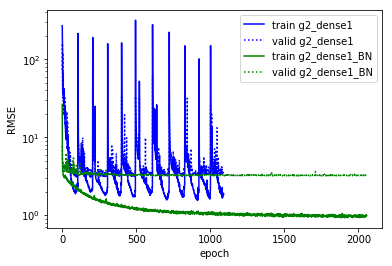

In [53]:
plot_loss([g2_model1_hist, g2_model1BN_hist],['g2_dense1','g2_dense1_BN'])

### Convolutional model 1

In [54]:
g2_model2 = Sequential()
g2_model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g2_model2.add(BatchNormalization())
g2_model2.add(MaxPooling2D(pool_size=(2, 2)))

g2_model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
g2_model2.add(BatchNormalization())
g2_model2.add(MaxPooling2D(pool_size=(2, 2)))

g2_model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g2_model2.add(BatchNormalization())
g2_model2.add(MaxPooling2D(pool_size=(2, 2)))

g2_model2.add(Flatten())
g2_model2.add(Dense(500, activation = "relu"))
g2_model2.add(BatchNormalization())

g2_model2.add(Dense(100, activation = "relu"))
g2_model2.add(BatchNormalization())

g2_model2.add(Dense(8))
print(g2_model2.summary())

g2_model2_hist, g2_model2 = fit_model(g2_model2, data2,
                                    'g2_CNNv1')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_19 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 22, 22, 128)       32896     
__________

Epoch 56/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 57/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 58/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 59/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 60/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 61/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 62/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 63/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 64/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 65/10000
3757/3757 [====================

3757/3757 [==============================] - 9s 2ms/step - loss: 7.4234e-04 - val_loss: 0.0022
Epoch 132/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 7.3973e-04 - val_loss: 0.0023
Epoch 133/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 6.8456e-04 - val_loss: 0.0028
Epoch 134/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 7.9590e-04 - val_loss: 0.0024
Epoch 135/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 7.2323e-04 - val_loss: 0.00233e-
Epoch 136/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 9.7147e-04 - val_loss: 0.0026
Epoch 137/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 9.1163e-04 - val_loss: 0.0025
Epoch 138/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 8.1329e-04 - val_loss: 0.0034
Epoch 139/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 7.5795e-04 - val_loss: 0.0024
Epoch 140/1000

Epoch 205/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.6825e-04 - val_loss: 0.0023
Epoch 206/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.8900e-04 - val_loss: 0.0020
Epoch 207/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 5.0672e-04 - val_loss: 0.0020
Epoch 208/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.9058e-04 - val_loss: 0.0028
Epoch 209/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 5.3789e-04 - val_loss: 0.0023
Epoch 210/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 5.0448e-04 - val_loss: 0.0021
Epoch 211/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 7.2041e-04 - val_loss: 0.0047
Epoch 212/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 7.5164e-04 - val_loss: 0.0023
Epoch 213/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 5.5752e-04 - val_loss: 0.0022
E

3757/3757 [==============================] - 9s 2ms/step - loss: 4.4437e-04 - val_loss: 0.0019
Epoch 279/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.7660e-04 - val_loss: 0.0019
Epoch 280/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.2739e-04 - val_loss: 0.0020
Epoch 281/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.1014e-04 - val_loss: 0.0019
Epoch 282/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.2878e-04 - val_loss: 0.0020
Epoch 283/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.3248e-04 - val_loss: 0.0020
Epoch 284/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.2930e-04 - val_loss: 0.0019
Epoch 285/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.2349e-04 - val_loss: 0.0020
Epoch 286/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 4.2131e-04 - val_loss: 0.0020
Epoch 287/10000
3

Epoch 352/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.6879e-04 - val_loss: 0.0019
Epoch 353/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.5940e-04 - val_loss: 0.0019
Epoch 354/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.4734e-04 - val_loss: 0.0019
Epoch 355/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.9248e-04 - val_loss: 0.0019
Epoch 356/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.8793e-04 - val_loss: 0.0019
Epoch 357/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.7832e-04 - val_loss: 0.0020
Epoch 358/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.6815e-04 - val_loss: 0.0020
Epoch 359/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.8189e-04 - val_loss: 0.0019
Epoch 360/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.6573e-04 - val_loss: 0.0020
E

Epoch 426/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.5710e-04 - val_loss: 0.0019
Epoch 427/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.5832e-04 - val_loss: 0.0019
Epoch 428/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.5084e-04 - val_loss: 0.0019
Epoch 429/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.4563e-04 - val_loss: 0.0020
Epoch 430/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.5167e-04 - val_loss: 0.0020
Epoch 431/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.8463e-04 - val_loss: 0.0019
Epoch 432/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2475e-04 - val_loss: 0.0019
Epoch 433/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1813e-04 - val_loss: 0.0019
Epoch 434/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.3207e-04 - val_loss: 0.0020
E

Epoch 500/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2432e-04 - val_loss: 0.0019
Epoch 501/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2073e-04 - val_loss: 0.0018
Epoch 502/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.4095e-04 - val_loss: 0.0019
Epoch 503/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.4452e-04 - val_loss: 0.0019
Epoch 504/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8623e-04 - val_loss: 0.0018
Epoch 505/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1859e-04 - val_loss: 0.0019
Epoch 506/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.3697e-04 - val_loss: 0.0019
Epoch 507/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2575e-04 - val_loss: 0.0019
Epoch 508/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.4385e-04 - val_loss: 0.0019
E

Epoch 574/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2468e-04 - val_loss: 0.0019
Epoch 575/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1319e-04 - val_loss: 0.0019
Epoch 576/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.4200e-04 - val_loss: 0.0019
Epoch 577/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.3624e-04 - val_loss: 0.0020
Epoch 578/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1440e-04 - val_loss: 0.0019
Epoch 579/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1867e-04 - val_loss: 0.0020
Epoch 580/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.3397e-04 - val_loss: 0.0019
Epoch 581/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1934e-04 - val_loss: 0.0019
Epoch 582/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9392e-04 - val_loss: 0.0019
E

Epoch 648/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1613e-04 - val_loss: 0.0019
Epoch 649/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2221e-04 - val_loss: 0.0019
Epoch 650/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2043e-04 - val_loss: 0.0019
Epoch 651/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.3090e-04 - val_loss: 0.0019
Epoch 652/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0330e-04 - val_loss: 0.0020
Epoch 653/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1575e-04 - val_loss: 0.0019
Epoch 654/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0705e-04 - val_loss: 0.0019
Epoch 655/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9934e-04 - val_loss: 0.0019
Epoch 656/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1235e-04 - val_loss: 0.0019
E

Epoch 722/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1014e-04 - val_loss: 0.0020
Epoch 723/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.4555e-04 - val_loss: 0.0020
Epoch 724/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9888e-04 - val_loss: 0.0019
Epoch 725/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1603e-04 - val_loss: 0.0020
Epoch 726/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9460e-04 - val_loss: 0.0019
Epoch 727/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9974e-04 - val_loss: 0.0019
Epoch 728/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9761e-04 - val_loss: 0.0020
Epoch 729/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2895e-04 - val_loss: 0.0020
Epoch 730/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0366e-04 - val_loss: 0.0020
E

3757/3757 [==============================] - 9s 2ms/step - loss: 3.1559e-04 - val_loss: 0.0020
Epoch 796/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9460e-04 - val_loss: 0.0020
Epoch 797/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8742e-04 - val_loss: 0.0020
Epoch 798/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0815e-04 - val_loss: 0.0021
Epoch 799/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1453e-04 - val_loss: 0.0020
Epoch 800/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0252e-04 - val_loss: 0.0020
Epoch 801/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9339e-04 - val_loss: 0.0020
Epoch 802/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9000e-04 - val_loss: 0.0021
Epoch 803/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1062e-04 - val_loss: 0.0020
Epoch 804/10000
3

Epoch 869/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2734e-04 - val_loss: 0.0020
Epoch 870/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9290e-04 - val_loss: 0.0020
Epoch 871/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1611e-04 - val_loss: 0.0022
Epoch 872/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8467e-04 - val_loss: 0.0020
Epoch 873/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8690e-04 - val_loss: 0.0020
Epoch 874/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2090e-04 - val_loss: 0.0020
Epoch 875/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9054e-04 - val_loss: 0.0020
Epoch 876/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8160e-04 - val_loss: 0.0020
Epoch 877/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8937e-04 - val_loss: 0.0021
E

Epoch 943/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9779e-04 - val_loss: 0.0021
Epoch 944/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.4442e-04 - val_loss: 0.0021
Epoch 945/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1190e-04 - val_loss: 0.0020
Epoch 946/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0440e-04 - val_loss: 0.0021
Epoch 947/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1843e-04 - val_loss: 0.0021
Epoch 948/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0769e-04 - val_loss: 0.0020
Epoch 949/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0820e-04 - val_loss: 0.0021
Epoch 950/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0652e-04 - val_loss: 0.0020
Epoch 951/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0374e-04 - val_loss: 0.0020
E

3757/3757 [==============================] - 9s 2ms/step - loss: 2.8890e-04 - val_loss: 0.0020
Epoch 1017/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9539e-04 - val_loss: 0.0020
Epoch 1018/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9267e-04 - val_loss: 0.0020
Epoch 1019/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0713e-04 - val_loss: 0.0019
Epoch 1020/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0585e-04 - val_loss: 0.0020
Epoch 1021/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1206e-04 - val_loss: 0.0019
Epoch 1022/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8379e-04 - val_loss: 0.0021
Epoch 1023/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9033e-04 - val_loss: 0.0020
Epoch 1024/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9370e-04 - val_loss: 0.0021
Epoch 102

3757/3757 [==============================] - 9s 2ms/step - loss: 2.7211e-04 - val_loss: 0.0020
Epoch 1090/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1900e-04 - val_loss: 0.0020
Epoch 1091/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8297e-04 - val_loss: 0.0019
Epoch 1092/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8557e-04 - val_loss: 0.0019
Epoch 1093/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0171e-04 - val_loss: 0.0020
Epoch 1094/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9039e-04 - val_loss: 0.0020
Epoch 1095/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8284e-04 - val_loss: 0.0020
Epoch 1096/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9007e-04 - val_loss: 0.0020
Epoch 1097/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1136e-04 - val_loss: 0.0020
Epoch 109

3757/3757 [==============================] - 9s 2ms/step - loss: 2.8521e-04 - val_loss: 0.0020
Epoch 1163/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8358e-04 - val_loss: 0.0020
Epoch 1164/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1888e-04 - val_loss: 0.0021
Epoch 1165/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0754e-04 - val_loss: 0.0021
Epoch 1166/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8785e-04 - val_loss: 0.0020
Epoch 1167/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.7429e-04 - val_loss: 0.0020
Epoch 1168/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9245e-04 - val_loss: 0.0020
Epoch 1169/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2972e-04 - val_loss: 0.0020
Epoch 1170/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0398e-04 - val_loss: 0.0020
Epoch 117

3757/3757 [==============================] - 9s 2ms/step - loss: 3.0826e-04 - val_loss: 0.0021
Epoch 1236/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.7726e-04 - val_loss: 0.0021
Epoch 1237/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9521e-04 - val_loss: 0.0020
Epoch 1238/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2439e-04 - val_loss: 0.0020
Epoch 1239/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8643e-04 - val_loss: 0.0020
Epoch 1240/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0327e-04 - val_loss: 0.0020
Epoch 1241/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1117e-04 - val_loss: 0.0020
Epoch 1242/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0059e-04 - val_loss: 0.0020
Epoch 1243/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9152e-04 - val_loss: 0.0021
Epoch 124

3757/3757 [==============================] - 9s 2ms/step - loss: 2.9131e-04 - val_loss: 0.0021
Epoch 1309/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0869e-04 - val_loss: 0.0020
Epoch 1310/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.2134e-04 - val_loss: 0.0020
Epoch 1311/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8970e-04 - val_loss: 0.0020
Epoch 1312/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1382e-04 - val_loss: 0.0020
Epoch 1313/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8310e-04 - val_loss: 0.0020
Epoch 1314/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.9033e-04 - val_loss: 0.0020
Epoch 1315/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1144e-04 - val_loss: 0.0021
Epoch 1316/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8082e-04 - val_loss: 0.0021
Epoch 131

3757/3757 [==============================] - 9s 2ms/step - loss: 2.8270e-04 - val_loss: 0.0020
Epoch 1382/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0961e-04 - val_loss: 0.0021
Epoch 1383/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0687e-04 - val_loss: 0.0020
Epoch 1384/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.1588e-04 - val_loss: 0.0021
Epoch 1385/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8323e-04 - val_loss: 0.0020
Epoch 1386/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.8690e-04 - val_loss: 0.0020
Epoch 1387/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0687e-04 - val_loss: 0.0021
Epoch 1388/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 3.0672e-04 - val_loss: 0.0021
Epoch 1389/10000
3757/3757 [==============================] - 9s 2ms/step - loss: 2.7709e-04 - val_loss: 0.0022
Epoch 139

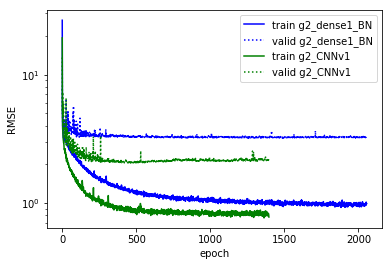

In [55]:
plot_loss([g2_model1BN_hist, g2_model2_hist],['g2_dense1_BN', 'g2_CNNv1'])

### Convolutional model 2 with more layers and tweaked kernel sizes

In [56]:
g2_model3 = Sequential()

g2_model3.add(Conv2D(filters=64,
                 kernel_size=(6, 6),
                 strides=1,
                 activation='elu',
                 input_shape=INPUT_SHAPE))
g2_model3.add(BatchNormalization())
#g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.1))

g2_model3.add(Conv2D(filters=128,
                 kernel_size=(5, 5),
                 strides=1,
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.2))

g2_model3.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.2))

g2_model3.add(Conv2D(filters=512,
                 kernel_size=(3, 3),
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.3))

g2_model3.add(Conv2D(filters=512,
                 kernel_size=(2, 2),
                 activation='elu'))
g2_model3.add(BatchNormalization())
g2_model3.add(MaxPooling2D(pool_size=(2, 2)))
g2_model3.add(Dropout(.4))

g2_model3.add(Flatten())
g2_model3.add(Dense(500, activation = "elu"))
g2_model3.add(BatchNormalization())
g2_model3.add(Dropout(.4))

#g2_model3.add(Dense(500, activation = "elu"))
#g2_model3.add(BatchNormalization())
#g2_model3.add(Dropout(.4))

g2_model3.add(Dense(100, activation = "elu"))
g2_model3.add(BatchNormalization())

g2_model3.add(Dense(8))

print(g2_model3.summary())

g2_model3_hist, g2_model3 = fit_model(g2_model3, data2,
                                    'g2_CNNv2')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 91, 91, 64)        2368      
_________________________________________________________________
batch_normalization_23 (Batc (None, 91, 91, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 91, 91, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 87, 87, 128)       204928    
_________________________________________________________________
batch_normalization_24 (Batc (None, 87, 87, 128)       512       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 43, 43, 128)       0         
__________

3757/3757 [==============================] - 62s 16ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 42/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 43/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 44/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0029 - val_loss: 0.0068
Epoch 45/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 46/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 47/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 48/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 49/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 50/10000
3757/3757 [=================

Epoch 117/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 118/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 119/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0014 - val_loss: 0.2523
Epoch 120/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0014 - val_loss: 0.0189
Epoch 121/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 122/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 123/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 124/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 125/10000
3757/3757 [==============================] - 62s 16ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 126/10000
375

Epoch 191/10000
3757/3757 [==============================] - 96s 25ms/step - loss: 7.9982e-04 - val_loss: 0.0015
Epoch 192/10000
3757/3757 [==============================] - 96s 25ms/step - loss: 8.0415e-04 - val_loss: 0.0017
Epoch 193/10000
3757/3757 [==============================] - 96s 25ms/step - loss: 8.1955e-04 - val_loss: 0.0015
Epoch 194/10000
3757/3757 [==============================] - 96s 25ms/step - loss: 7.9928e-04 - val_loss: 0.0017
Epoch 195/10000
3757/3757 [==============================] - 96s 26ms/step - loss: 8.4171e-04 - val_loss: 0.0016
Epoch 196/10000
3757/3757 [==============================] - 96s 26ms/step - loss: 7.7652e-04 - val_loss: 0.0016
Epoch 197/10000
3757/3757 [==============================] - 96s 26ms/step - loss: 8.1226e-04 - val_loss: 0.0015
Epoch 198/10000
3757/3757 [==============================] - 96s 26ms/step - loss: 8.0392e-04 - val_loss: 0.0016
Epoch 199/10000
3757/3757 [==============================] - 96s 26ms/step - loss: 7.7639e-04 - 

3757/3757 [==============================] - 86s 23ms/step - loss: 6.5138e-04 - val_loss: 0.0016
Epoch 264/10000
3757/3757 [==============================] - 86s 23ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 265/10000
3757/3757 [==============================] - 86s 23ms/step - loss: 7.5118e-04 - val_loss: 0.0015
Epoch 266/10000
3757/3757 [==============================] - 86s 23ms/step - loss: 7.0247e-04 - val_loss: 0.0015
Epoch 267/10000
3757/3757 [==============================] - 72s 19ms/step - loss: 7.1000e-04 - val_loss: 0.0016
Epoch 268/10000
3757/3757 [==============================] - 61s 16ms/step - loss: 6.8918e-04 - val_loss: 0.0015
Epoch 269/10000
3757/3757 [==============================] - 61s 16ms/step - loss: 6.7156e-04 - val_loss: 0.0015
Epoch 270/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 6.9701e-04 - val_loss: 0.0015
Epoch 271/10000
3757/3757 [==============================] - 71s 19ms/step - loss: 6.8315e-04 - val_loss: 0.0015
Epo

3757/3757 [==============================] - 69s 18ms/step - loss: 5.8628e-04 - val_loss: 0.0015
Epoch 336/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.6374e-04 - val_loss: 0.0015
Epoch 337/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.9959e-04 - val_loss: 0.0014
Epoch 338/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 6.1754e-04 - val_loss: 0.0015
Epoch 339/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 6.0733e-04 - val_loss: 0.0015
Epoch 340/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 6.4134e-04 - val_loss: 0.0015
Epoch 341/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 6.0649e-04 - val_loss: 0.0015
Epoch 342/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.9959e-04 - val_loss: 0.0015
Epoch 343/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.9466e-04 - val_loss: 0.0015

3757/3757 [==============================] - 69s 18ms/step - loss: 5.3836e-04 - val_loss: 0.0016
Epoch 408/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.6258e-04 - val_loss: 0.0015
Epoch 409/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.3785e-04 - val_loss: 0.0015
Epoch 410/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.4555e-04 - val_loss: 0.0015
Epoch 411/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.8042e-04 - val_loss: 0.0015
Epoch 412/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.7309e-04 - val_loss: 0.0015
Epoch 413/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.7828e-04 - val_loss: 0.0015
Epoch 414/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.5693e-04 - val_loss: 0.0015
Epoch 415/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.7462e-04 - val_loss: 0.0015

3757/3757 [==============================] - 69s 18ms/step - loss: 5.5214e-04 - val_loss: 0.0015
Epoch 480/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.2807e-04 - val_loss: 0.0015
Epoch 481/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1456e-04 - val_loss: 0.0016
Epoch 482/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.7907e-04 - val_loss: 0.0015
Epoch 483/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.4525e-04 - val_loss: 0.0015
Epoch 484/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.5596e-04 - val_loss: 0.0015
Epoch 485/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.4711e-04 - val_loss: 0.0015
Epoch 486/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.2590e-04 - val_loss: 0.0015
Epoch 487/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.4122e-04 - val_loss: 0.0015

3757/3757 [==============================] - 69s 18ms/step - loss: 5.5621e-04 - val_loss: 0.0015
Epoch 552/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1002e-04 - val_loss: 0.0015
Epoch 553/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1172e-04 - val_loss: 0.0015
Epoch 554/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1688e-04 - val_loss: 0.0015
Epoch 555/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.2952e-04 - val_loss: 0.0015
Epoch 556/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1738e-04 - val_loss: 0.0015
Epoch 557/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.2589e-04 - val_loss: 0.0016
Epoch 558/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.9792e-04 - val_loss: 0.0015
Epoch 559/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.2439e-04 - val_loss: 0.0014

3757/3757 [==============================] - 69s 18ms/step - loss: 5.2371e-04 - val_loss: 0.0015
Epoch 624/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.2675e-04 - val_loss: 0.0014
Epoch 625/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.4978e-04 - val_loss: 0.0015
Epoch 626/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1859e-04 - val_loss: 0.0015
Epoch 627/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1774e-04 - val_loss: 0.0015
Epoch 628/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7051e-04 - val_loss: 0.0015
Epoch 629/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.4272e-04 - val_loss: 0.0016
Epoch 630/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.3761e-04 - val_loss: 0.0015
Epoch 631/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1172e-04 - val_loss: 0.0015

3757/3757 [==============================] - 69s 18ms/step - loss: 4.5612e-04 - val_loss: 0.0015
Epoch 696/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7792e-04 - val_loss: 0.0015
Epoch 697/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6736e-04 - val_loss: 0.0015
Epoch 698/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7828e-04 - val_loss: 0.0015
Epoch 699/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.8718e-04 - val_loss: 0.0015
Epoch 700/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.2997e-04 - val_loss: 0.0014
Epoch 701/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.0879e-04 - val_loss: 0.0014
Epoch 702/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.9830e-04 - val_loss: 0.0015
Epoch 703/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1494e-04 - val_loss: 0.0015

3757/3757 [==============================] - 69s 18ms/step - loss: 5.0402e-04 - val_loss: 0.0016
Epoch 768/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.9055e-04 - val_loss: 0.0015
Epoch 769/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5836e-04 - val_loss: 0.0015
Epoch 770/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.9943e-04 - val_loss: 0.0016
Epoch 771/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.0638e-04 - val_loss: 0.0015
Epoch 772/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.1556e-04 - val_loss: 0.0015
Epoch 773/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6639e-04 - val_loss: 0.0015
Epoch 774/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.8571e-04 - val_loss: 0.0015
Epoch 775/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 5.2587e-04 - val_loss: 0.0015

3757/3757 [==============================] - 69s 18ms/step - loss: 4.5348e-04 - val_loss: 0.0016
Epoch 840/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.8129e-04 - val_loss: 0.0015
Epoch 841/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3846e-04 - val_loss: 0.0015
Epoch 842/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.8391e-04 - val_loss: 0.0015
Epoch 843/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3814e-04 - val_loss: 0.0016
Epoch 844/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.9431e-04 - val_loss: 0.0015
Epoch 845/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7587e-04 - val_loss: 0.0015
Epoch 846/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5015e-04 - val_loss: 0.0015
Epoch 847/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.9334e-04 - val_loss: 0.0015

3757/3757 [==============================] - 69s 18ms/step - loss: 4.9196e-04 - val_loss: 0.0015
Epoch 912/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6778e-04 - val_loss: 0.0015
Epoch 913/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6005e-04 - val_loss: 0.0015
Epoch 914/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6360e-04 - val_loss: 0.0015
Epoch 915/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.4593e-04 - val_loss: 0.0015
Epoch 916/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7676e-04 - val_loss: 0.0014
Epoch 917/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5873e-04 - val_loss: 0.0015
Epoch 918/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6734e-04 - val_loss: 0.0015
Epoch 919/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.9453e-04 - val_loss: 0.0015

3757/3757 [==============================] - 69s 18ms/step - loss: 4.9390e-04 - val_loss: 0.0015
Epoch 984/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5563e-04 - val_loss: 0.0015
Epoch 985/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.8911e-04 - val_loss: 0.0015
Epoch 986/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.4693e-04 - val_loss: 0.0015
Epoch 987/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5554e-04 - val_loss: 0.0015
Epoch 988/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.8796e-04 - val_loss: 0.0015
Epoch 989/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6986e-04 - val_loss: 0.0015
Epoch 990/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6554e-04 - val_loss: 0.0014
Epoch 991/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6327e-04 - val_loss: 0.0015

3757/3757 [==============================] - 69s 18ms/step - loss: 4.6187e-04 - val_loss: 0.0015
Epoch 1056/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.9269e-04 - val_loss: 0.0015
Epoch 1057/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7575e-04 - val_loss: 0.0014
Epoch 1058/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7865e-04 - val_loss: 0.0015
Epoch 1059/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3309e-04 - val_loss: 0.0015
Epoch 1060/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6285e-04 - val_loss: 0.0015
Epoch 1061/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6100e-04 - val_loss: 0.0015
Epoch 1062/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.4870e-04 - val_loss: 0.0015
Epoch 1063/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6218e-04 - val_loss

3757/3757 [==============================] - 69s 18ms/step - loss: 4.4209e-04 - val_loss: 0.0015
Epoch 1128/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5409e-04 - val_loss: 0.0015
Epoch 1129/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5828e-04 - val_loss: 0.0014
Epoch 1130/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7676e-04 - val_loss: 0.0016
Epoch 1131/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.2052e-04 - val_loss: 0.0015
Epoch 1132/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7364e-04 - val_loss: 0.0015
Epoch 1133/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3995e-04 - val_loss: 0.0015
Epoch 1134/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7898e-04 - val_loss: 0.0015
Epoch 1135/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3921e-04 - val_loss

3757/3757 [==============================] - 69s 18ms/step - loss: 4.5655e-04 - val_loss: 0.0015
Epoch 1200/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3689e-04 - val_loss: 0.0015
Epoch 1201/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3047e-04 - val_loss: 0.0015
Epoch 1202/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6908e-04 - val_loss: 0.0015
Epoch 1203/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3964e-04 - val_loss: 0.0015
Epoch 1204/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.4254e-04 - val_loss: 0.0015
Epoch 1205/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5385e-04 - val_loss: 0.0015
Epoch 1206/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7173e-04 - val_loss: 0.0015
Epoch 1207/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5421e-04 - val_loss

3757/3757 [==============================] - 69s 18ms/step - loss: 4.2132e-04 - val_loss: 0.0015
Epoch 1272/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5623e-04 - val_loss: 0.0015
Epoch 1273/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3693e-04 - val_loss: 0.0015
Epoch 1274/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.4057e-04 - val_loss: 0.0015
Epoch 1275/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6340e-04 - val_loss: 0.0015
Epoch 1276/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.9784e-04 - val_loss: 0.0015
Epoch 1277/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5693e-04 - val_loss: 0.0015
Epoch 1278/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5317e-04 - val_loss: 0.0015
Epoch 1279/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.7006e-04 - val_loss

3757/3757 [==============================] - 69s 18ms/step - loss: 4.2499e-04 - val_loss: 0.0016
Epoch 1344/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5767e-04 - val_loss: 0.0015
Epoch 1345/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.1278e-04 - val_loss: 0.0015
Epoch 1346/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.2510e-04 - val_loss: 0.0015
Epoch 1347/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6648e-04 - val_loss: 0.0015
Epoch 1348/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.4862e-04 - val_loss: 0.0015
Epoch 1349/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3569e-04 - val_loss: 0.0015
Epoch 1350/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.6480e-04 - val_loss: 0.0015
Epoch 1351/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5169e-04 - val_loss

3757/3757 [==============================] - 69s 18ms/step - loss: 4.4325e-04 - val_loss: 0.0015
Epoch 1416/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.2323e-04 - val_loss: 0.0015
Epoch 1417/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5152e-04 - val_loss: 0.0015
Epoch 1418/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3861e-04 - val_loss: 0.0014
Epoch 1419/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.4045e-04 - val_loss: 0.0017
Epoch 1420/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3169e-04 - val_loss: 0.0014
Epoch 1421/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3656e-04 - val_loss: 0.0015
Epoch 1422/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.5856e-04 - val_loss: 0.0015
Epoch 1423/10000
3757/3757 [==============================] - 69s 18ms/step - loss: 4.3432e-04 - val_loss

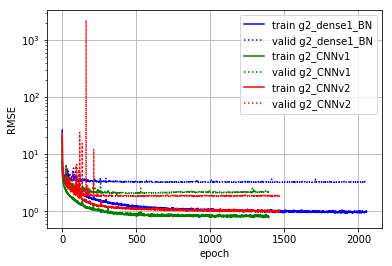

In [57]:
plot_loss([g2_model1BN_hist, g2_model2_hist, g2_model3_hist],['g2_dense1_BN', 'g2_CNNv1', 'g2_CNNv2'])

### Supplementing the model 3 with augmented data

In [58]:
g2_datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X2_train,Y2_train,whichlabels=list(labels2), batch_size=32)

In [59]:
g2_model4 = Sequential()

g2_model4.add(Conv2D(filters=64,
                 kernel_size=(6, 6),
                 strides=1,
                 activation='elu',
                 input_shape=INPUT_SHAPE))
g2_model4.add(BatchNormalization())
#g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.1))

g2_model4.add(Conv2D(filters=128,
                 kernel_size=(5, 5),
                 strides=1,
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.2))

g2_model4.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.2))

g2_model4.add(Conv2D(filters=512,
                 kernel_size=(3, 3),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.3))

g2_model4.add(Conv2D(filters=512,
                 kernel_size=(2, 2),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.4))

g2_model4.add(Flatten())
g2_model4.add(Dense(500, activation = "elu"))
g2_model4.add(BatchNormalization())
g2_model4.add(Dropout(.4))

#g2_model4.add(Dense(500, activation = "elu"))
#g2_model4.add(BatchNormalization())
#g2_model4.add(Dropout(.4))

g2_model4.add(Dense(100, activation = "elu"))
g2_model4.add(BatchNormalization())

g2_model4.add(Dense(8))

print(g2_model4.summary())

g2_model4_hist, g2_model4 = fit_model(g2_model4, data2,
                                'g2_CNNv2_aug', g2_datagen,
                                patience=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 91, 91, 64)        2368      
_________________________________________________________________
batch_normalization_30 (Batc (None, 91, 91, 64)        256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 91, 91, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 87, 87, 128)       204928    
_________________________________________________________________
batch_normalization_31 (Batc (None, 87, 87, 128)       512       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 43, 43, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 43, 43, 128)       0         
__________

117/117 [==============================] - 71s 610ms/step - loss: 0.0043 - val_loss: 0.0079
Epoch 43/10000
117/117 [==============================] - 69s 588ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 44/10000
117/117 [==============================] - 69s 590ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 45/10000
117/117 [==============================] - 69s 589ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 46/10000
117/117 [==============================] - 69s 589ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 47/10000
117/117 [==============================] - 69s 586ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 48/10000
117/117 [==============================] - 69s 588ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 49/10000
117/117 [==============================] - 69s 590ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 50/10000
117/117 [==============================] - 69s 589ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 51/10000
117/117 [============================

117/117 [==============================] - 60s 512ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 119/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 120/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 121/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 122/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 123/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 124/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 125/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0023 - val_loss: 0.0245
Epoch 126/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 127/10000
117/117 [===================

Epoch 194/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 195/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 196/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 197/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 198/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 199/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 200/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 201/10000
117/117 [==============================] - 60s 515ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 202/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 203/10000
117/117 [===

Epoch 270/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 271/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 272/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 273/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 274/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 275/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 276/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0016 - val_loss: 0.0112
Epoch 277/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 278/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0016 - val_loss: 0.2814
Epoch 279/10000
117/117 [===

Epoch 346/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 347/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 348/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 349/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 350/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 351/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 352/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 353/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 354/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 355/10000
117/117 [===

Epoch 422/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 423/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 424/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 425/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 426/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 427/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 428/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 429/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 430/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 431/10000
117/117 [===

Epoch 498/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 499/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 500/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 501/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 502/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 503/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 504/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 505/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 506/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 507/10000
117/117 [===

Epoch 574/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 575/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 576/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 577/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 578/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 579/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 580/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 581/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 582/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 583/10000
117/117 [===

Epoch 650/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 651/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 652/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 653/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 654/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 655/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 656/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 657/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 658/10000
117/117 [==============================] - 60s 509ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 659/10000
117/117 [===

Epoch 726/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 727/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 728/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 729/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 730/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 731/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 732/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 733/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 734/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 735/10000
117/117 [===

Epoch 802/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 803/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 804/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 805/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 806/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 807/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 808/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 809/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 810/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 811/10000
117/117 [===

Epoch 878/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 879/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 880/10000
117/117 [==============================] - 60s 510ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 881/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 882/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 883/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 884/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 885/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 886/10000
117/117 [==============================] - 60s 512ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 887/10000
117/117 [===

Epoch 954/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 955/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 956/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 957/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 958/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 959/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 960/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 961/10000
117/117 [==============================] - 60s 514ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 962/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 963/10000
117/117 [===

117/117 [==============================] - 61s 521ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 1030/10000
117/117 [==============================] - 61s 519ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1031/10000
117/117 [==============================] - 60s 517ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 1032/10000
117/117 [==============================] - 61s 520ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 1033/10000
117/117 [==============================] - 61s 518ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 1034/10000
117/117 [==============================] - 61s 518ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 1035/10000
117/117 [==============================] - 60s 516ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1036/10000
117/117 [==============================] - 61s 520ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 1037/10000
117/117 [==============================] - 61s 519ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1038/10000
117/117 [==========

117/117 [==============================] - 61s 519ms/step - loss: 9.7309e-04 - val_loss: 0.0013
Epoch 1104/10000
117/117 [==============================] - 60s 516ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 1105/10000
117/117 [==============================] - 61s 517ms/step - loss: 9.9226e-04 - val_loss: 0.0012
Epoch 1106/10000
117/117 [==============================] - 61s 520ms/step - loss: 9.9807e-04 - val_loss: 0.0013
Epoch 1107/10000
117/117 [==============================] - 60s 516ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 1108/10000
117/117 [==============================] - 61s 520ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 1109/10000
117/117 [==============================] - 61s 518ms/step - loss: 9.5196e-04 - val_loss: 0.0012
Epoch 1110/10000
117/117 [==============================] - 61s 518ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1111/10000
117/117 [==============================] - 61s 520ms/step - loss: 9.6930e-04 - val_loss: 0.0012
Epoch 1112/10000

117/117 [==============================] - 60s 515ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1178/10000
117/117 [==============================] - 60s 517ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1179/10000
117/117 [==============================] - 60s 515ms/step - loss: 9.8581e-04 - val_loss: 0.0012
Epoch 1180/10000
117/117 [==============================] - 60s 515ms/step - loss: 9.8174e-04 - val_loss: 0.0013
Epoch 1181/10000
117/117 [==============================] - 60s 515ms/step - loss: 9.6717e-04 - val_loss: 0.0012
Epoch 1182/10000
117/117 [==============================] - 60s 516ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1183/10000
117/117 [==============================] - 60s 515ms/step - loss: 9.8909e-04 - val_loss: 0.0012
Epoch 1184/10000
117/117 [==============================] - 60s 515ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1185/10000
117/117 [==============================] - 60s 515ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1186/10000
117

117/117 [==============================] - 60s 510ms/step - loss: 9.5340e-04 - val_loss: 0.0013
Epoch 1251/10000
117/117 [==============================] - 60s 514ms/step - loss: 9.8433e-04 - val_loss: 0.0014
Epoch 1252/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.5628e-04 - val_loss: 0.0012
Epoch 1253/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.0932e-04 - val_loss: 0.0012
Epoch 1254/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.3696e-04 - val_loss: 0.0013
Epoch 1255/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.6893e-04 - val_loss: 0.0012
Epoch 1256/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.4849e-04 - val_loss: 0.0012
Epoch 1257/10000
117/117 [==============================] - 60s 510ms/step - loss: 9.7952e-04 - val_loss: 0.0012
Epoch 1258/10000
117/117 [==============================] - 60s 514ms/step - loss: 9.5271e-04 - val_loss: 0.0013


117/117 [==============================] - 60s 513ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1324/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.7638e-04 - val_loss: 0.0014
Epoch 1325/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.6413e-04 - val_loss: 0.0013
Epoch 1326/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.9159e-04 - val_loss: 0.0013
Epoch 1327/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.4204e-04 - val_loss: 0.0012
Epoch 1328/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.5442e-04 - val_loss: 0.0013
Epoch 1329/10000
117/117 [==============================] - 60s 514ms/step - loss: 9.6211e-04 - val_loss: 0.0012
Epoch 1330/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.9581e-04 - val_loss: 0.0013
Epoch 1331/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.3759e-04 - val_loss: 0.0012
Epoc

117/117 [==============================] - 60s 512ms/step - loss: 9.6844e-04 - val_loss: 0.0013
Epoch 1397/10000
117/117 [==============================] - 60s 516ms/step - loss: 9.7665e-04 - val_loss: 0.0014
Epoch 1398/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1399/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.5906e-04 - val_loss: 0.0013
Epoch 1400/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.9855e-04 - val_loss: 0.0013
Epoch 1401/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1402/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 1403/10000
117/117 [==============================] - 60s 513ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 1404/10000
117/117 [==============================] - 60s 513ms/step - loss: 9.6056e-04 - val_loss: 0.0014
Epoch 1405/10000

117/117 [==============================] - 61s 519ms/step - loss: 9.6531e-04 - val_loss: 0.0013
Epoch 1470/10000
117/117 [==============================] - 61s 517ms/step - loss: 9.9759e-04 - val_loss: 0.0014
Epoch 1471/10000
117/117 [==============================] - 61s 519ms/step - loss: 9.3119e-04 - val_loss: 0.0012
Epoch 1472/10000
117/117 [==============================] - 61s 519ms/step - loss: 9.0423e-04 - val_loss: 0.0013
Epoch 1473/10000
117/117 [==============================] - 61s 523ms/step - loss: 9.4002e-04 - val_loss: 0.0013
Epoch 1474/10000
117/117 [==============================] - 61s 521ms/step - loss: 9.9468e-04 - val_loss: 0.0013
Epoch 1475/10000
117/117 [==============================] - 61s 522ms/step - loss: 9.6500e-04 - val_loss: 0.0015
Epoch 1476/10000
117/117 [==============================] - 61s 522ms/step - loss: 9.4218e-04 - val_loss: 0.0013
Epoch 1477/10000
117/117 [==============================] - 61s 521ms/step - loss: 0.0010 - val_loss: 0.0013
Epoc

Epoch 1542/10000
117/117 [==============================] - 61s 518ms/step - loss: 9.4948e-04 - val_loss: 0.0013
Epoch 1543/10000
117/117 [==============================] - 61s 520ms/step - loss: 9.5026e-04 - val_loss: 0.0012
Epoch 1544/10000
117/117 [==============================] - 61s 520ms/step - loss: 9.4210e-04 - val_loss: 0.0012
Epoch 1545/10000
117/117 [==============================] - 61s 520ms/step - loss: 9.3731e-04 - val_loss: 0.0012
Epoch 1546/10000
117/117 [==============================] - 61s 521ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 1547/10000
117/117 [==============================] - 61s 520ms/step - loss: 9.3531e-04 - val_loss: 0.0012
Epoch 1548/10000
117/117 [==============================] - 61s 520ms/step - loss: 9.5360e-04 - val_loss: 0.0013
Epoch 1549/10000
117/117 [==============================] - 61s 522ms/step - loss: 9.3761e-04 - val_loss: 0.0013
Epoch 1550/10000
117/117 [==============================] - 61s 518ms/step - loss: 9.6513e-04 - val_

117/117 [==============================] - 60s 511ms/step - loss: 9.2699e-04 - val_loss: 0.0013
Epoch 1615/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.3044e-04 - val_loss: 0.0012
Epoch 1616/10000
117/117 [==============================] - 60s 511ms/step - loss: 9.1670e-04 - val_loss: 0.0012
Epoch 1617/10000
117/117 [==============================] - 60s 511ms/step - loss: 9.3969e-04 - val_loss: 0.0012
Epoch 1618/10000
117/117 [==============================] - 60s 511ms/step - loss: 8.8734e-04 - val_loss: 0.0012
Epoch 1619/10000
117/117 [==============================] - 60s 512ms/step - loss: 8.9232e-04 - val_loss: 0.0012
Epoch 1620/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.3304e-04 - val_loss: 0.0012
Epoch 1621/10000
117/117 [==============================] - 60s 511ms/step - loss: 9.0573e-04 - val_loss: 0.0012
Epoch 1622/10000
117/117 [==============================] - 60s 511ms/step - loss: 0.0010 - val_loss: 0.0013
Epoc

117/117 [==============================] - 60s 512ms/step - loss: 9.1242e-04 - val_loss: 0.0014
Epoch 1687/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.7105e-04 - val_loss: 0.0012
Epoch 1688/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.2441e-04 - val_loss: 0.0013
Epoch 1689/10000
117/117 [==============================] - 60s 512ms/step - loss: 9.6183e-04 - val_loss: 0.0012
Epoch 1690/10000
117/117 [==============================] - 60s 513ms/step - loss: 8.8422e-04 - val_loss: 0.0012
Epoch 1691/10000
117/117 [==============================] - 60s 511ms/step - loss: 9.1753e-04 - val_loss: 0.0013
Epoch 1692/10000
117/117 [==============================] - 60s 510ms/step - loss: 9.1223e-04 - val_loss: 0.0013
Epoch 01692: early stopping


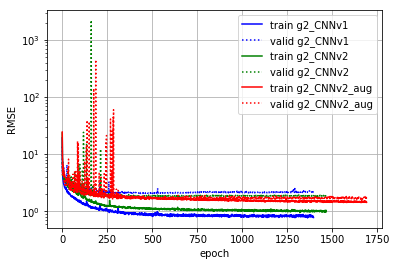

In [60]:
plot_loss([g2_model2_hist, g2_model3_hist, g2_model4_hist],['g2_CNNv1', 'g2_CNNv2', 'g2_CNNv2_aug'])

## Create Predictions
### Load the Testing Time Images

In [ ]:
out_images, _ , _ = loaderV2(test=True, seed=None, keeplabels=None)

### Create the Predictions

In [ ]:
# TO DO: need to combine best models for group1 and group2 to make predictions
final_model = g1_model2
prediction = final_model.predict(out_images)

### Plot some example predictions

In [ ]:
# first image
plot_image(out_images[0], 48*prediction[0]+48, labels)



# images that have labels outside the image
for i in np.where(np.max(np.abs(prediction),axis=1)>1)[0]:
    plot_image(out_images[i],
        48*prediction[i]+48, labels,title='test image # ' + str(i))




### Put the predictions into the submission format

In [ ]:
IdLookupTable = read_csv('../data/IdLookupTable.csv')
IdLookupTable.head()

In [ ]:
label_locs = {}
for i, label in enumerate(labels):
    label_locs[label]=i

IdLookupTable['test'] = IdLookupTable['FeatureName'].replace(label_locs)
IdLookupTable['Location'] = (48*prediction[IdLookupTable['ImageId']-1,
                                       IdLookupTable['test']]) + 48

IdLookupTable['Location'] = (IdLookupTable['Location'].
                             where(IdLookupTable['Location']<=96, 96).
                             where(IdLookupTable['Location']>=0, 0)
                            )
IdLookupTable.head()

In [ ]:
Submission = IdLookupTable[['RowId','Location']]
Submission.head()

In [ ]:
Submission.to_csv(path_or_buf='./Submissions/CNN_wdatAugment.csv',
                  index=False)

In [ ]:
Submission.describe()